In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import gym
import numpy as np
from IPython.display import display, clear_output   
from time import sleep

In [3]:
policy_y = np.array([[0, 3, 0, 0, 0]
, [0, 0, 0, 3, 0]
, [0, 3, 3, 3, 3]
, [0, 1, 3, 1, 1]
, [0, 1, 1, 1, 3]])
policy_g = np.array([[2, 0, 2, 2, 0]
, [2, 0, 1, 1, 1]
, [2, 2, 1, 1, 1]
, [1, 2, 1, 2, 1]
, [1, 1, 1, 2, 1]])
policy_r = np.array([[0, 3, 0, 3, 3]
, [1, 1, 0, 3, 0]
, [1, 1, 3, 3, 3]
, [1, 1, 1, 1, 1]
, [1, 1, 3, 1, 1]])
policy_b = np.array([[0, 0, 0, 0, 0]
, [2, 0, 2, 0, 0]
, [2, 2, 2, 0, 0]
, [1, 1, 1, 0, 0]
, [1, 2, 1, 0, 3]])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
env = gym.make("Taxi-v3")

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [5]:
def average_episode_time(Q):
  steps = []
  trajectories_ep = []
  for i in range(1000):
    state = env.reset()
    done = False
    t = 0
    trajectory = []
    while not done:
      action = np.argmax(Q[state])
      if action<6:
        next_state,reward,done,_ = env.step(action)
        trajectory.append([state,action,next_state,reward,False])
        state = next_state
        t+=1
      if action>=6:
        optdone = False
        while not optdone:

          row_t,col_t,_,_ = env.decode(state)
          optaction = options[action][row_t][col_t] 
          next_state,reward,done,_ = env.step(optaction)
          trajectory.append([state,optaction,next_state,reward,True])
          t+=1
          state= next_state
          row_t_1,col_t_1,_,_ = env.decode(next_state)
          next_state_is_terminal = True if (5*(row_t_1) + col_t_1) == termination_dict[action] else False 
          if next_state_is_terminal:
            optdone = True
          state = next_state
    steps.append(t)
    trajectories_ep.append(trajectory)


  print("Average number of steps taken for given hyperparameters is: ",np.array(steps).mean())
  return(np.array(steps).mean()),steps,trajectories_ep

In [6]:
def SMDP_Learning(ALPHA,GAMMA,EPS,NUM_EPS):
  
  actions = [0,1,2,3,4,5,6,7,8,9] #6-9 options in the order -> y,g,r,b
  termination_dict = {6:20,7:4,8:0,9:23}
  options             = [None,None,None,None,None,None,policy_y,policy_g,policy_r,policy_b]
  Q_SMDP = np.zeros((env.observation_space.n,len(actions))) 
  Update_Frequency_SMDP_q_learning = np.zeros((env.observation_space.n,len(actions)))
  alpha = ALPHA
  gamma = GAMMA
  cumul_reward_SMDP = []
  def average_episode_time(Q):
    steps = []
    trajectories_ep = []
    for i in range(1000):
      state = env.reset()
      done = False
      t = 0
      trajectory = []
      while not done:
        action = np.argmax(Q[state])
        if action<6:
          next_state,reward,done,_ = env.step(action)
          trajectory.append([state,action,next_state,reward,False])
          state = next_state
          t+=1
        if action>=6:
          optdone = False
          while not optdone:

            row_t,col_t,_,_ = env.decode(state)
            optaction = options[action][row_t][col_t] 
            next_state,reward,done,_ = env.step(optaction)
            trajectory.append([state,optaction,next_state,reward,True])
            t+=1
            state= next_state
            row_t_1,col_t_1,_,_ = env.decode(next_state)
            next_state_is_terminal = True if (5*(row_t_1) + col_t_1) == termination_dict[action] else False 
            if next_state_is_terminal:
              optdone = True
            state = next_state
      steps.append(t)
      trajectories_ep.append(trajectory)


    #print("Average number of steps taken for given hyperparameters is: ",np.array(steps).mean())
    return(np.array(steps).mean()),steps,trajectories_ep
  def return_action(state,epsilon,Q):
    if np.random.rand()>eps:
      return np.argmax(Q[state])
    else:
      return np.random.choice(np.arange((len(actions))),1)[0]
  # While episode is not over
  # Iterate over 1000 episodes
  for ep in range(int(NUM_EPS)):
      #print(ep)
      state = env.reset()    
      done = False
      r = 0
      tmax = 0
      # While episode is not over
      while not done:
      
          eps = max((0.99**ep)*0.9,EPS)
          # Choose action        
          action = return_action(state,eps,Q_SMDP)
          
          # Checking if primitive action
          if action < 6:
              # Perform regular Q-Learning update for state-action pair
              next_state, reward, done,_ = env.step(action)
              #r+= gamma**(tmax-1) * reward
              r+=reward
              tmax +=1
              update = reward + gamma * max(Q_SMDP[next_state]) - Q_SMDP[state][action]
              Q_SMDP[state][action] +=  alpha*(update)
              Update_Frequency_SMDP_q_learning[state][action] += 1
              state = next_state
          
          # Checking if action chosen is an option
          
          if action>=6:
            reward_bar = 0
            current_state = state
            optdone = False
            tau = 0
            done_ = False
            while (optdone==False):
              taxi_row,taxi_col,_,_  = env.decode(state)
              optaction = options[action][taxi_row][taxi_col]
              next_state,reward,done_,_ = env.step(optaction)
              tau +=1
              tmax+=1
              reward_bar = reward_bar + (gamma**(tau-1))*reward
              state = next_state
              row_t_1,col_t_1,_,_ = env.decode(next_state)
              next_state_is_terminal = True if (5*(row_t_1) + col_t_1) == termination_dict[action] else False 
              if next_state_is_terminal:
                optdone = True
            update = reward_bar + (gamma**(tau) * max(Q_SMDP[state])) - Q_SMDP[current_state][action]
            Q_SMDP[current_state][action] +=  alpha * update
            #r+= gamma**(tmax-1) * reward_bar
            r+=reward_bar
            Update_Frequency_SMDP_q_learning[current_state][action] += 1
      cumul_reward_SMDP.append(r)      
          

  
  plt.figure(figsize = (15,15))
  sns.heatmap(Update_Frequency_SMDP_q_learning,annot = False)
  plt.xlabel("Actions(0-6) and Options(6-9)")
  plt.ylabel("States")
  plt.savefig(str("Update_frequency ")+str(alpha)+str(EPS)+str(GAMMA)+".png")
  plt.show()
  plt.figure(figsize = (15,15))
  sns.heatmap(Q_SMDP,annot = False)
  plt.xlabel("Actions(0-6) and Options(6-9)")
  plt.ylabel("States")
  plt.savefig(str("SMDP ")+str(alpha)+str(EPS)+str(GAMMA)+".png")
  plt.show()
  
  plt.plot(cumul_reward_SMDP)
  plt.xlabel("Number of episodes")
  plt.ylabel("Cummulative reward")
  plt.savefig(str("Reward ")+str(alpha)+str(EPS)+str(GAMMA)+".png")
  plt.show()
  
  mean_steps,_,_ =  average_episode_time(Q_SMDP)
  return mean_steps
  


In [8]:
def Q_intra_option_Q_learning(ALPHA,GAMMA,EPS,NUM_EPS):
  actions = [0,1,2,3,4,5,6,7,8,9] #6-9 options in the order -> y,g,r,b
  termination_dict = {6:20,7:4,8:0,9:23}
  options             = [None,None,None,None,None,None,policy_y,policy_g,policy_r,policy_b]
  Q_intra_option_Q = np.zeros((env.observation_space.n,len(actions))) 
  Update_Frequency_intra_q_learning = np.zeros((env.observation_space.n,len(actions)))
  alpha = ALPHA
  gamma = GAMMA
  cumul_reward_intra = []
  ep_steps = []
  def return_action(state,epsilon,Q):
    if np.random.rand()>epsilon:
      return np.argmax(Q[state])
    else:
      return np.random.choice(np.arange((len(actions))),1)[0]
  def average_episode_time(Q):
    steps = []
    trajectories_ep = []
    for i in range(1000):
      state = env.reset()
      done = False
      t = 0
      trajectory = []
      while not done:
        action = np.argmax(Q[state])
        if action<6:
          next_state,reward,done,_ = env.step(action)
          trajectory.append([state,action,next_state,reward,False])
          state = next_state
          t+=1
        if action>=6:
          optdone = False
          while not optdone:

            row_t,col_t,_,_ = env.decode(state)
            optaction = options[action][row_t][col_t] 
            next_state,reward,done,_ = env.step(optaction)
            trajectory.append([state,optaction,next_state,reward,True])
            t+=1
            state= next_state
            row_t_1,col_t_1,_,_ = env.decode(next_state)
            next_state_is_terminal = True if (5*(row_t_1) + col_t_1) == termination_dict[action] else False 
            if next_state_is_terminal:
              optdone = True
            state = next_state
      steps.append(t)
      trajectories_ep.append(trajectory)


    #print("Average number of steps taken for given hyperparameters is: ",np.array(steps).mean())
    return(np.array(steps).mean()),steps,trajectories_ep
  def update_intraoption_action(state,action,next_state,reward): #here action is a primitive action
    Q_intra_option_Q[state][action] += alpha*(reward + gamma*max(Q_intra_option_Q[next_state]) - Q_intra_option_Q[state][action])
    Update_Frequency_intra_q_learning[state][action] +=1 
    row_t,col_t,_,_ = env.decode(state)
    row_t_1,col_t_1,_,_ = env.decode(next_state)
    
    for option in range(6,10):
      optaction  = options[option][row_t][col_t]
      next_state_is_terminal = True if (5*(row_t_1) + col_t_1) == termination_dict[option] else False 
      if optaction == action:
        if next_state_is_terminal == False:
          Q_intra_option_Q[state][option] += alpha*(reward + (gamma*Q_intra_option_Q[next_state][option]) - Q_intra_option_Q[state][option])
          Update_Frequency_intra_q_learning[state][option] += 1  
        else:
          Q_intra_option_Q[state][option] += alpha*(reward + gamma*max(Q_intra_option_Q[next_state]) - Q_intra_option_Q[state][option])
          Update_Frequency_intra_q_learning[state][option] += 1  

  for ep in range(int(NUM_EPS)):
    state = env.reset()
    done = False
    t = 0
    r = 0
    while not done:
      eps = max((0.99**ep)*0.9,EPS)
      action = return_action(state,eps,Q_intra_option_Q)
      if action <6:
        next_state,reward,done,_ = env.step(action)
        r+=  reward
        t+=1
        update_intraoption_action(state,action,next_state,reward)
        state = next_state
        #print(state,action,next_state,reward)
      if action>=6:
        #print("current_option: ",action)
        optdone = False
        while not optdone:

          row_t,col_t,_,_ = env.decode(state)
          optaction = options[action][row_t][col_t] 
          next_state,reward,done,_ = env.step(optaction) 
          r+= reward
          t+=1
          update_intraoption_action(state,optaction,next_state,reward)
          state= next_state
          row_t_1,col_t_1,_,_ = env.decode(next_state)
          next_state_is_terminal = True if (5*(row_t_1) + col_t_1) == termination_dict[action] else False 
          #print(state,optaction,next_state,reward,termination_dict[action])
          if next_state_is_terminal:
            optdone = True
    cumul_reward_intra.append(r)
    ep_steps.append(t)

  plt.figure(figsize = (15,15))
  sns.heatmap(Update_Frequency_intra_q_learning,annot = False)
  plt.xlabel("Actions(0-6) and Options(6-9)")
  plt.ylabel("States")
  plt.savefig(str("Update_frequency_intra ")+str(alpha)+str(EPS)+str(GAMMA)+".png")
  plt.show()
  plt.figure(figsize = (15,15))
  sns.heatmap(Q_intra_option_Q,annot = False)
  plt.xlabel("Actions(0-6) and Options(6-9)")
  plt.ylabel("States")
  plt.savefig(str("Intra_option ")+str(alpha)+str(EPS)+str(GAMMA)+".png")
  plt.show()
  
  plt.plot(cumul_reward_intra)
  plt.xlabel("Number of episodes")
  plt.ylabel("Cummulative reward")
  plt.savefig(str("Reward_intra ")+str(alpha)+str(EPS)+str(GAMMA)+".png")
  plt.show()
  
  plt.plot(ep_steps)
  plt.xlabel("Number of episodes")
  plt.ylabel("Number of steps taken to solve the environment")
  plt.savefig(str("time_steps_intra ")+str(alpha)+str(EPS)+str(GAMMA)+".png")
  plt.show()

  mean_steps,_,_ =  average_episode_time(Q_intra_option_Q)
  return mean_steps

In [ ]:
!pip install wandb 
import wandb
!wandb login --relogin

import pprint
import numpy as np

sweep_config = {
    'method': 'bayes'
}

metric = {
    'name' : 'Average steps Intra option_Q learning',
    'goal' : 'minimize'
}
sweep_config['metric'] = metric

parameters_dict ={
    'NUM_EPISODES': {
      'values': [1e4,5e4,1e5,2e5]
    }

    }
sweep_config['parameters'] = parameters_dict

import math
parameters_dict.update({
    'LR': {
      'values': [1e-2,1e-1,0.2,0.3,0.5,1]
      },
    'EPS': {
      'distribution': 'uniform',
      'max': 0.3,
      'min': 0.05
      }
  
    })

pprint.pprint(sweep_config)

sweep_id = wandb.sweep(sweep_config, project="Intra_option Q learning")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
{'method': 'bayes',
 'metric': {'goal': 'minimize',
            'name': 'Average steps Intra option_Q learning'},
 'parameters': {'EPS': {'distribution': 'uniform', 'max': 0.3, 'min': 0.05},
                'LR': {'values': [0.01, 0.1, 0.2, 0.3, 0.5, 1]},
                'NUM_EPISODES': {'values': [10000.0,
                                            50000.0,
                                            100000.0,
                                            200000.0]}}}
Create sweep with ID: uy4ji861
Sweep URL: https://wandb.ai/me19b190/Intra_option%20Q%20l

In [ ]:
def train_intra_option_Q(config = None):
  with wandb.init(config = config):
    config = wandb.config
    LR = config.LR               ## learning rate 
    NUM_EPS = config.NUM_EPISODES
    EPS = config.EPS
    num_steps = Q_intra_option_Q_learning(LR,0.9,EPS,NUM_EPS)
    wandb.log({'Average steps Intra option_Q learning':num_steps})

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


wandb: Agent Starting Run: it2ehzcz with config:
wandb: 	EPS: 0.15750629449964282
wandb: 	LR: 1
wandb: 	NUM_EPISODES: 50000
wandb: Currently logged in as: me19b190. Use `wandb login --relogin` to force relogin


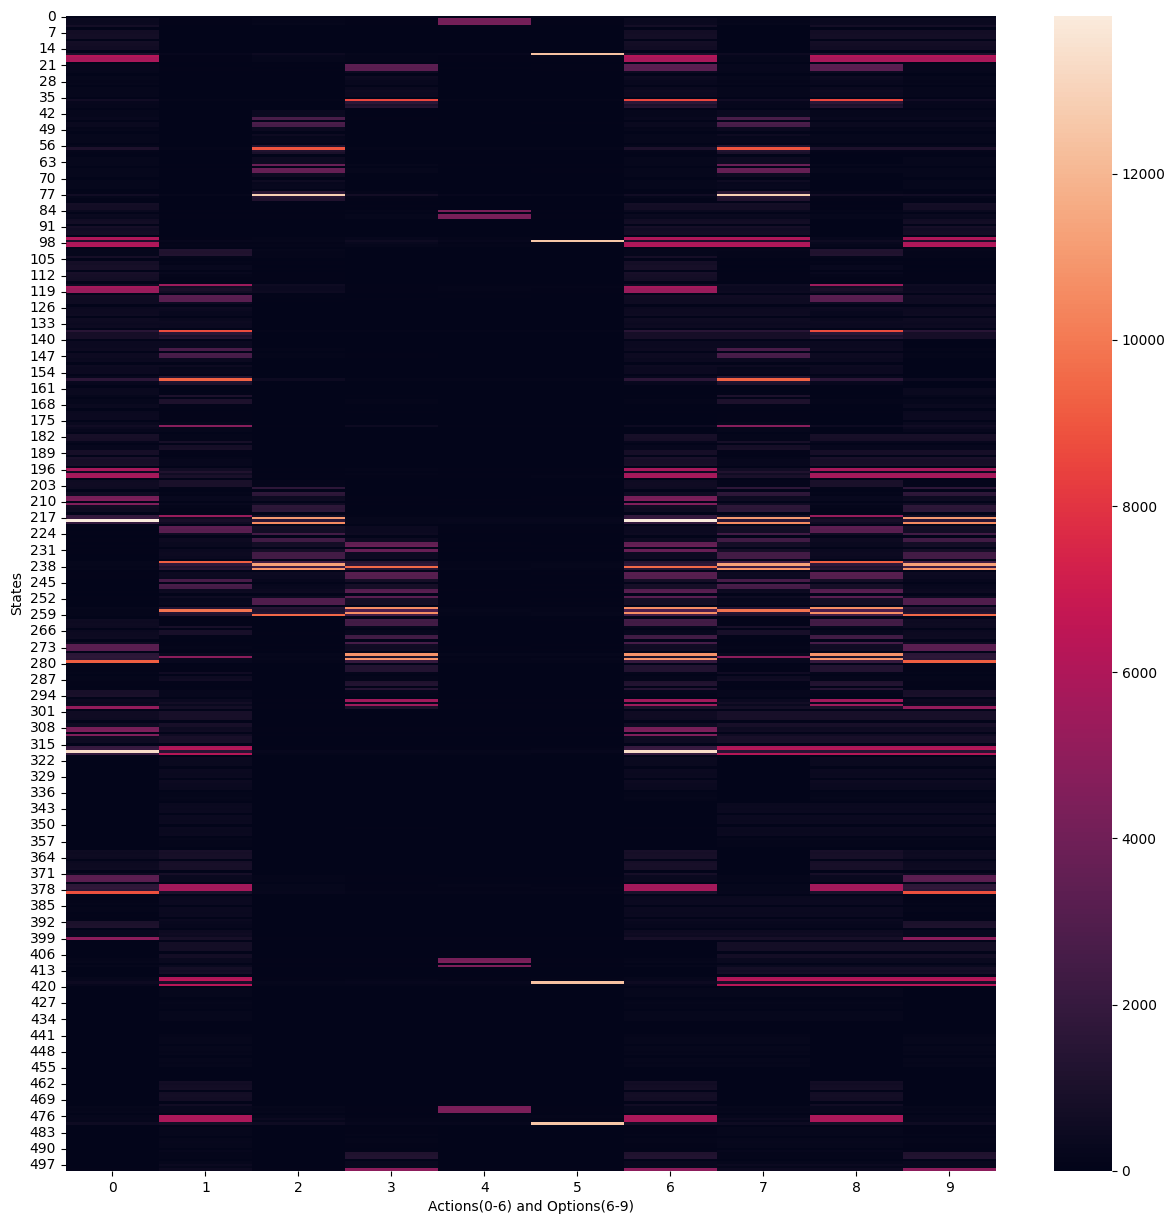

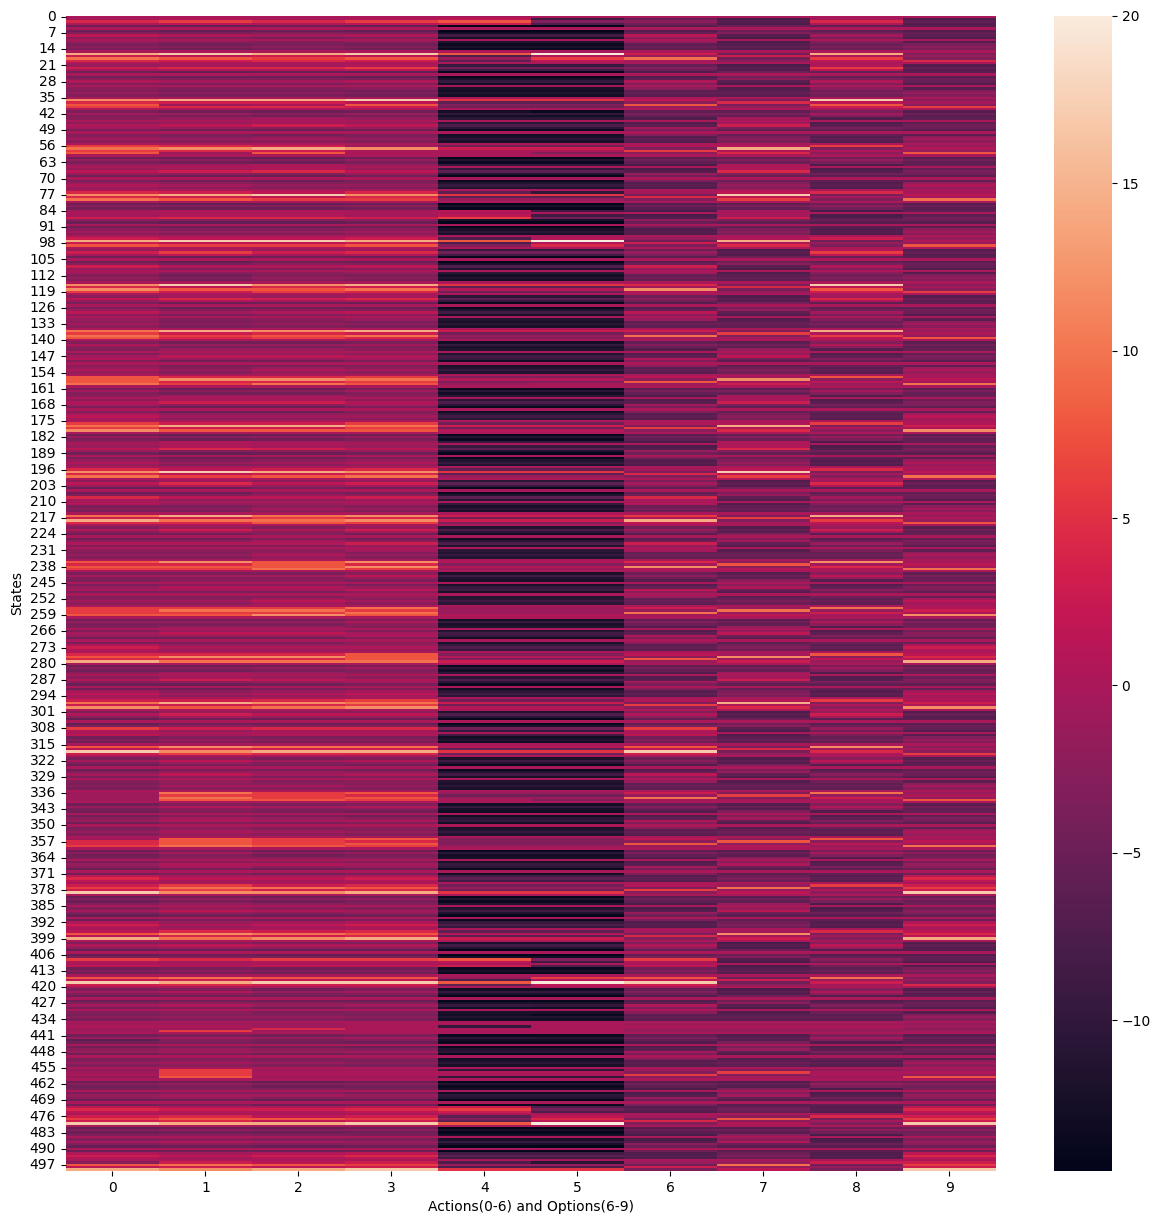

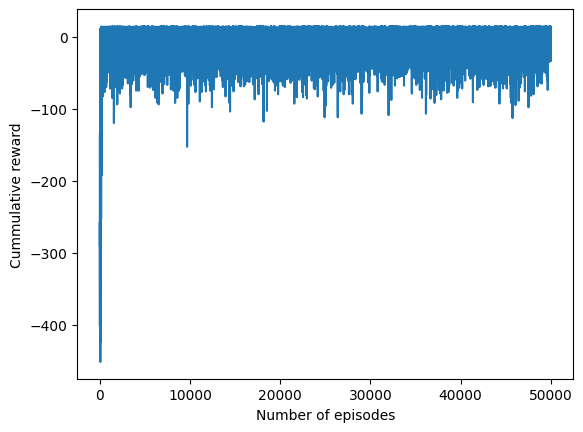

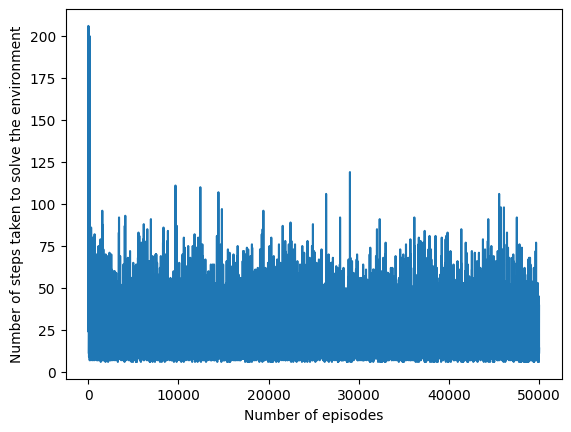

wandb: Agent Starting Run: it19l2h1 with config:
wandb: 	EPS: 0.12742108587548123
wandb: 	LR: 1
wandb: 	NUM_EPISODES: 200000


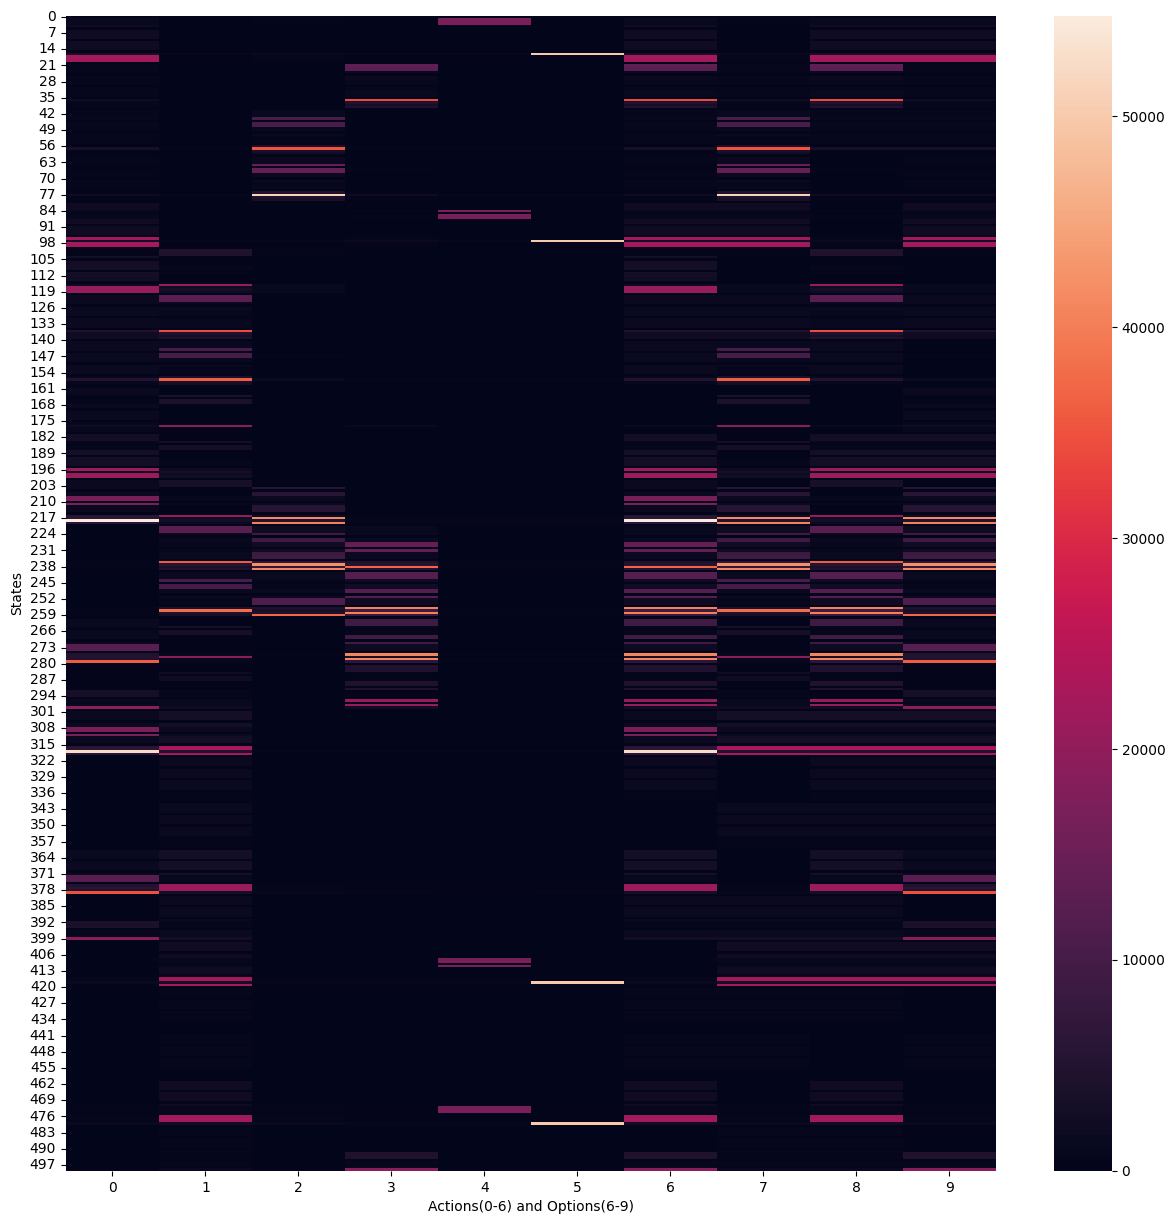

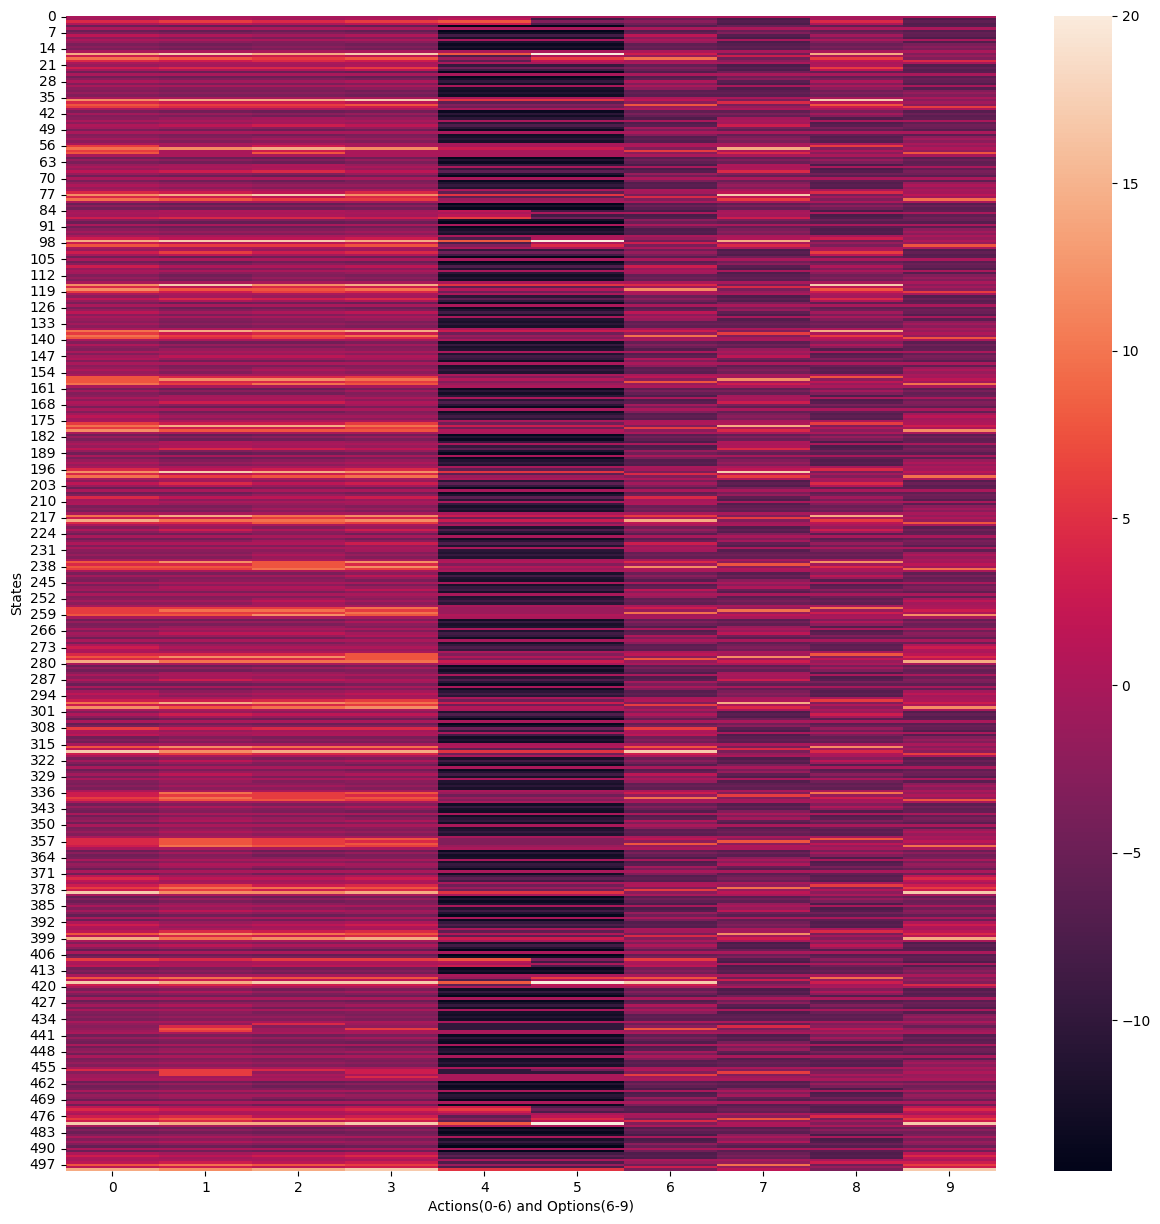

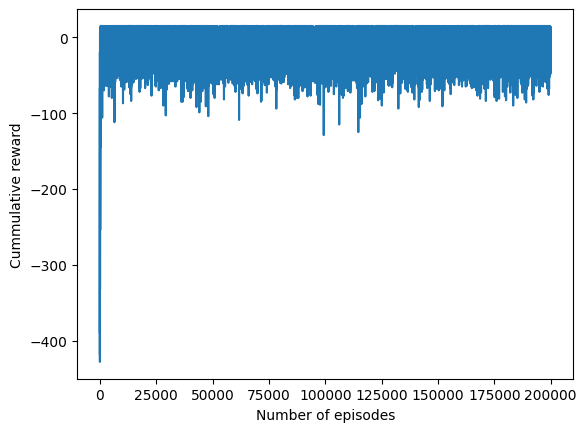

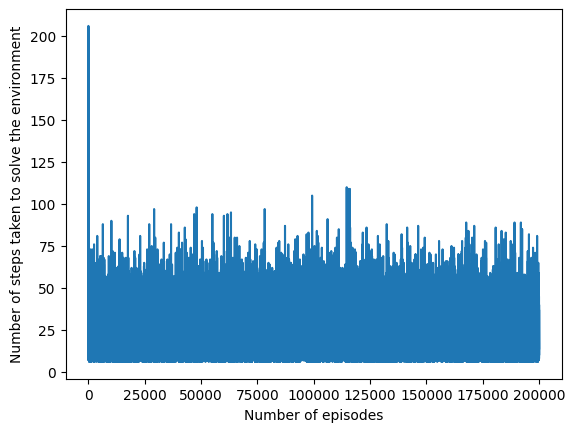

wandb: Agent Starting Run: bkcvpgav with config:
wandb: 	EPS: 0.14178683835662045
wandb: 	LR: 1
wandb: 	NUM_EPISODES: 200000


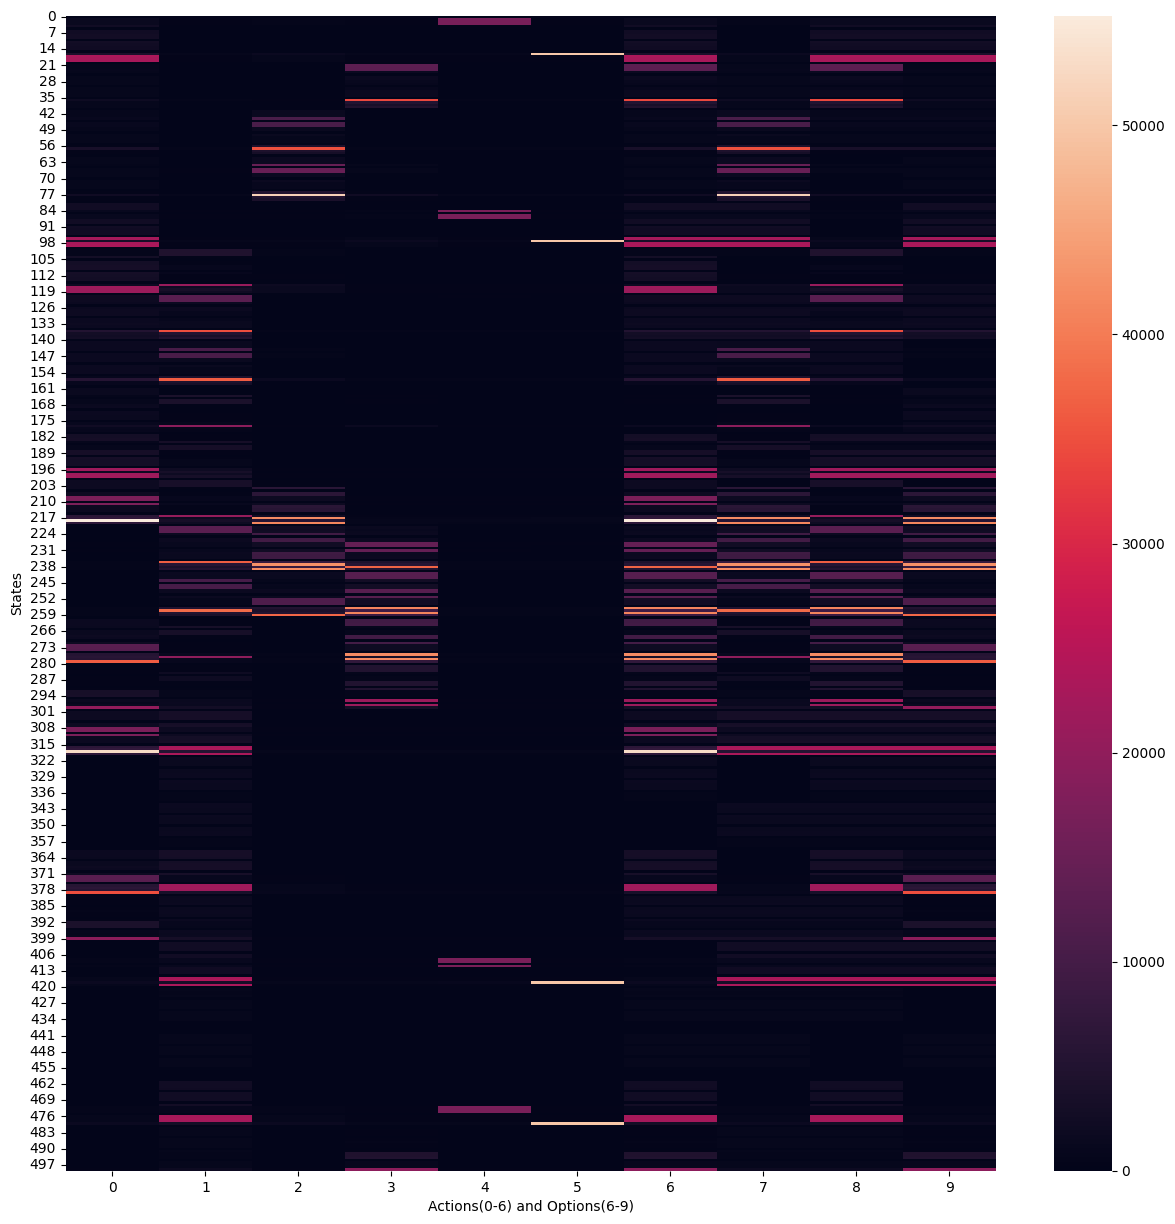

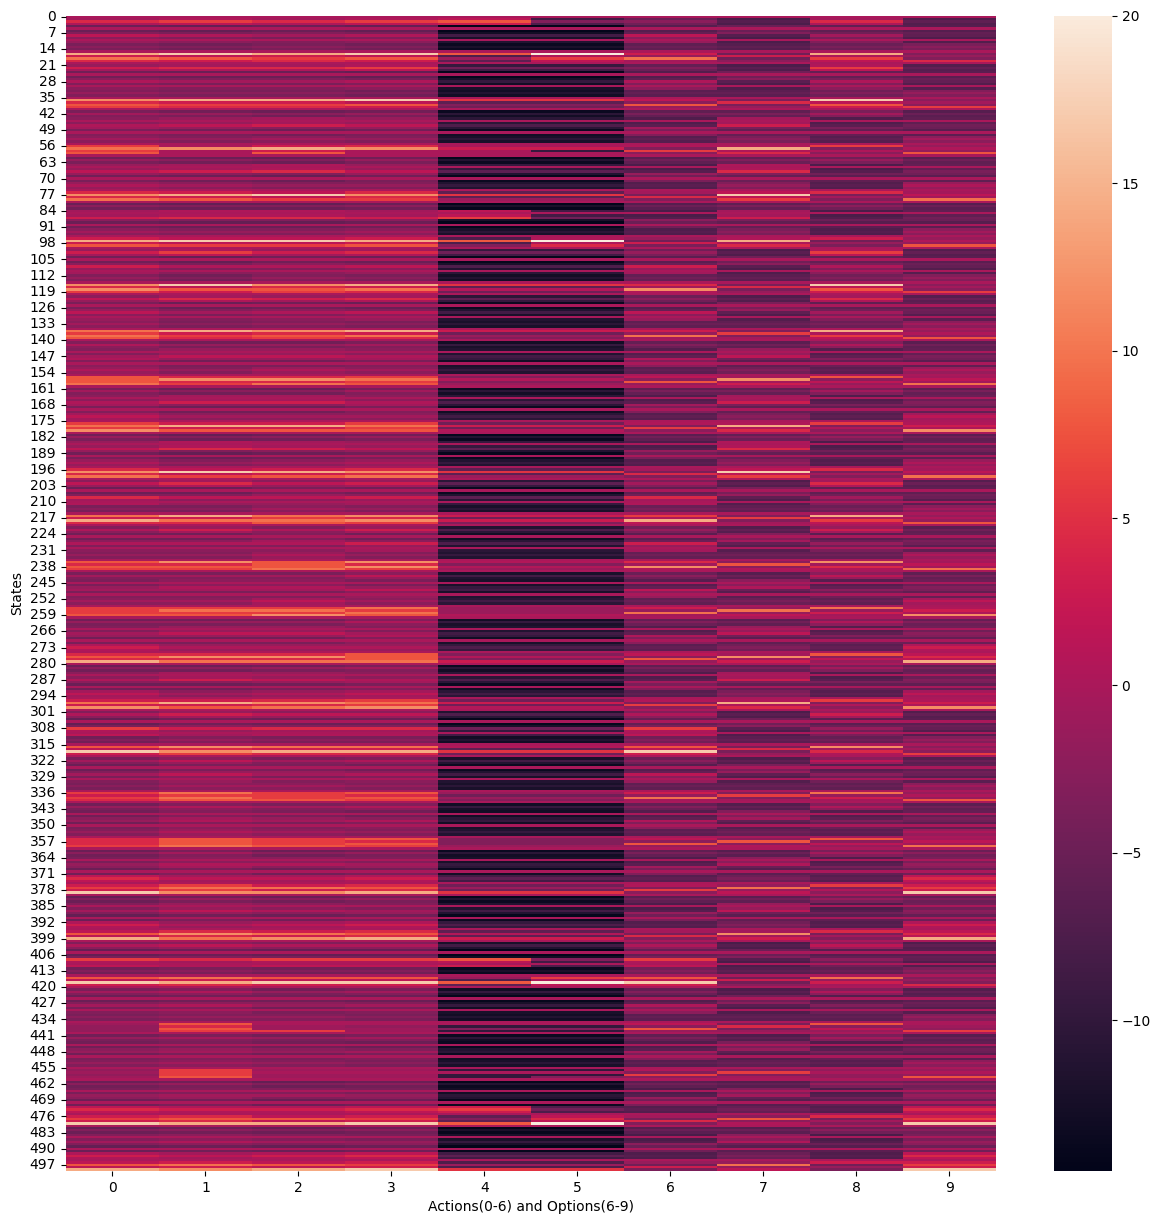

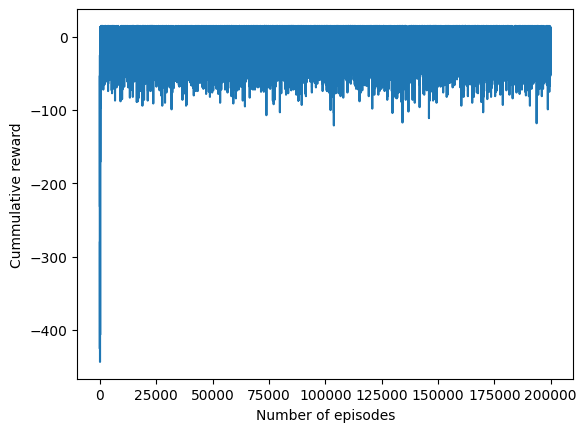

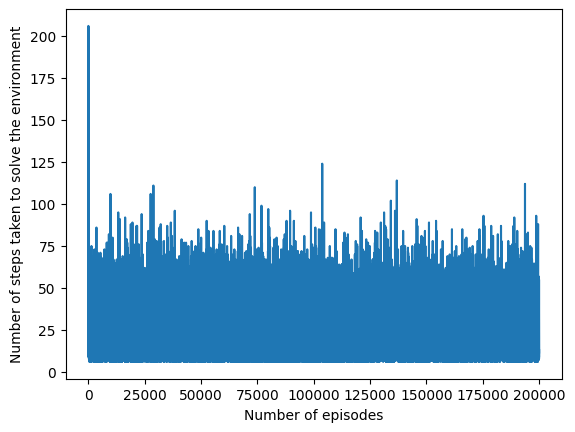

wandb: Agent Starting Run: v31ka884 with config:
wandb: 	EPS: 0.21259763132180728
wandb: 	LR: 0.01
wandb: 	NUM_EPISODES: 100000


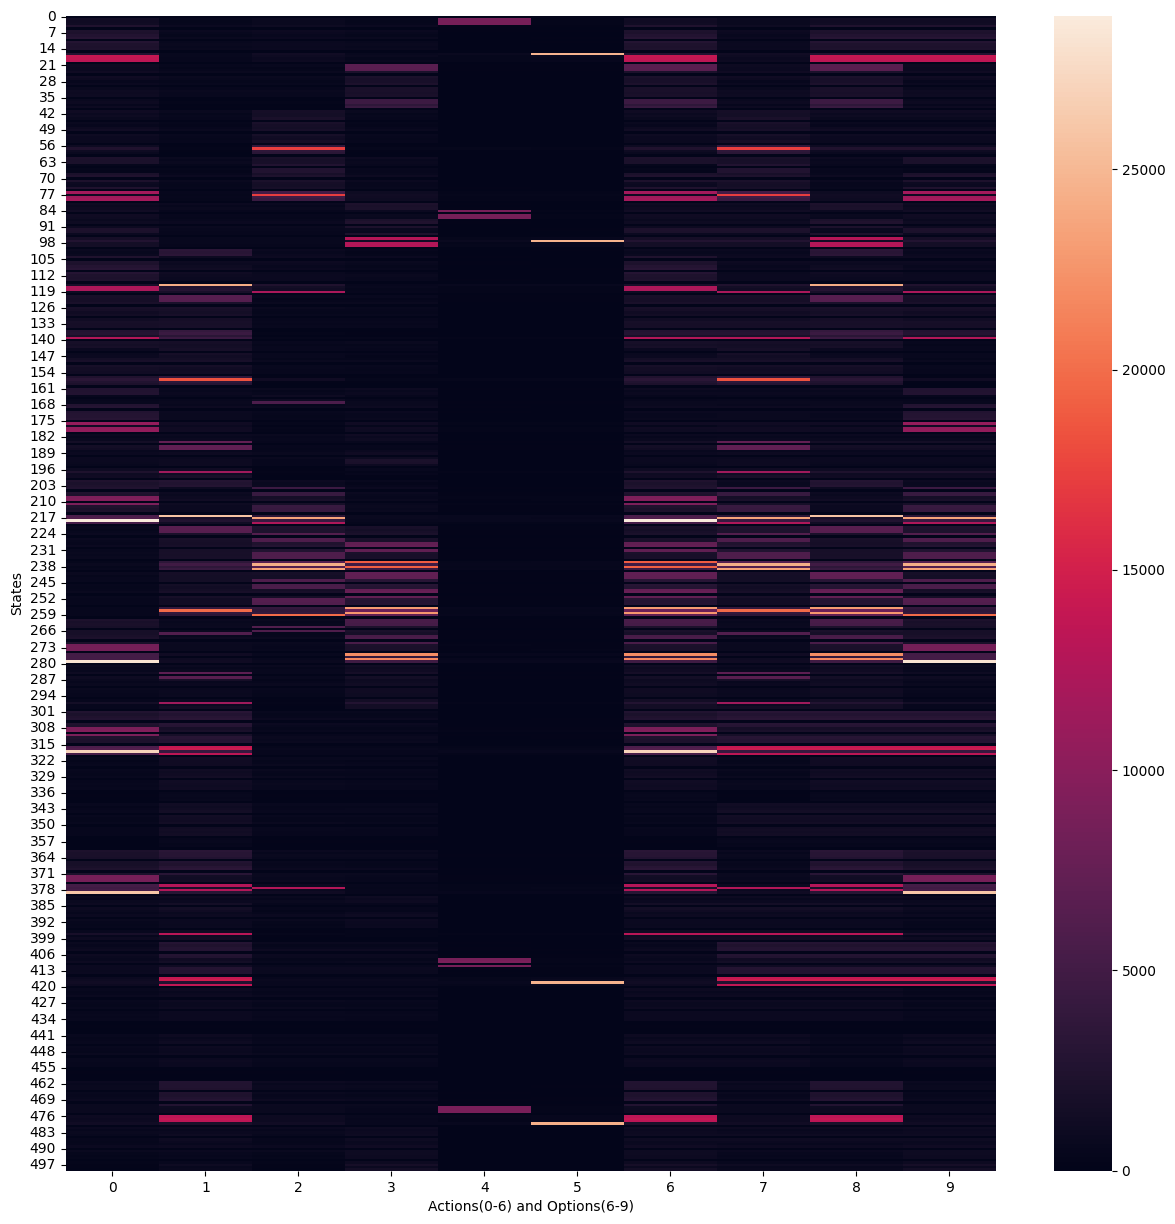

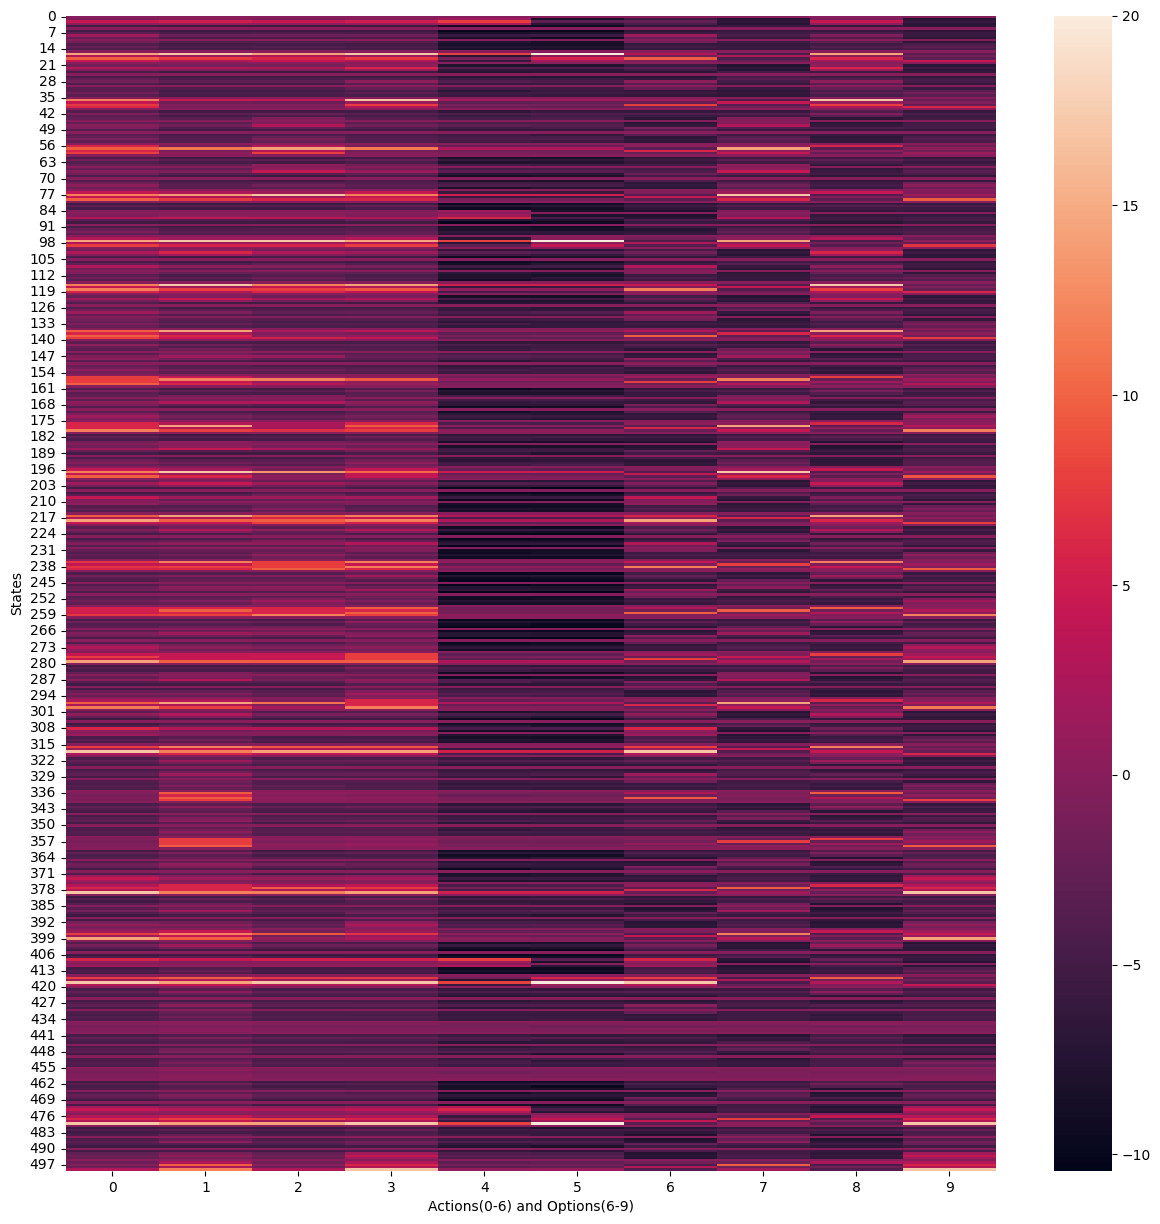

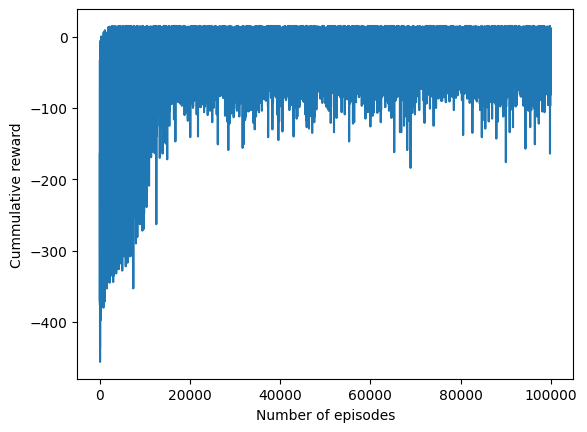

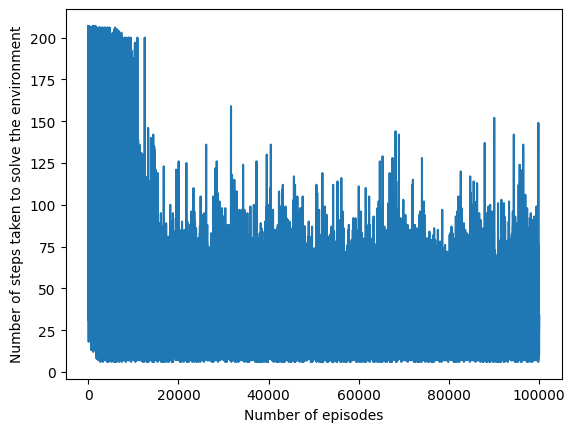

wandb: Agent Starting Run: lm3od5qp with config:
wandb: 	EPS: 0.07090224181026285
wandb: 	LR: 0.3
wandb: 	NUM_EPISODES: 10000


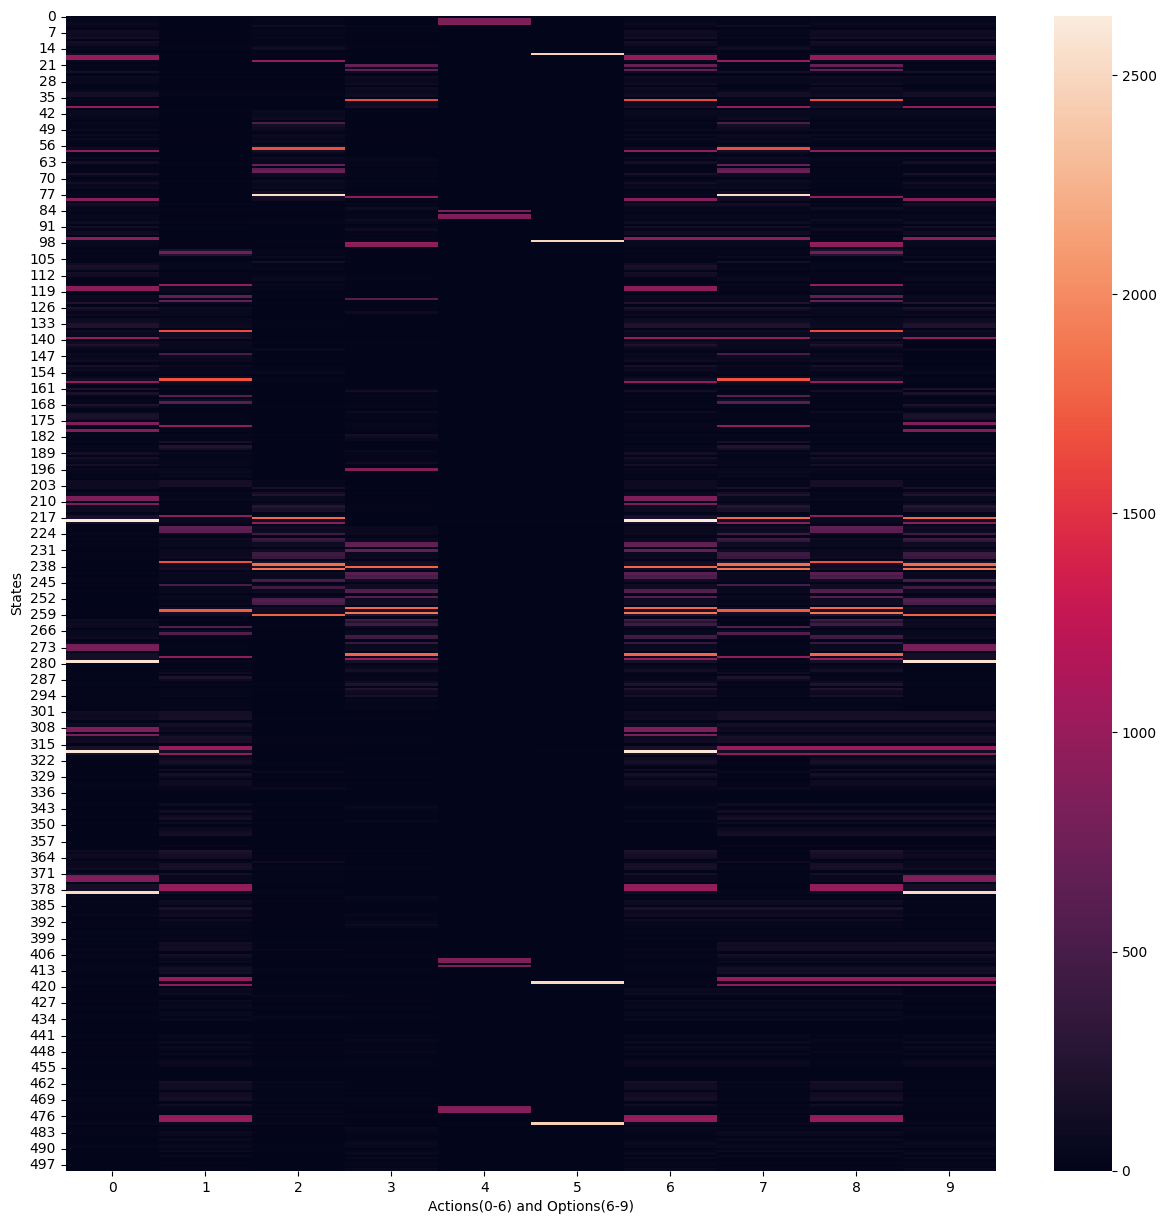

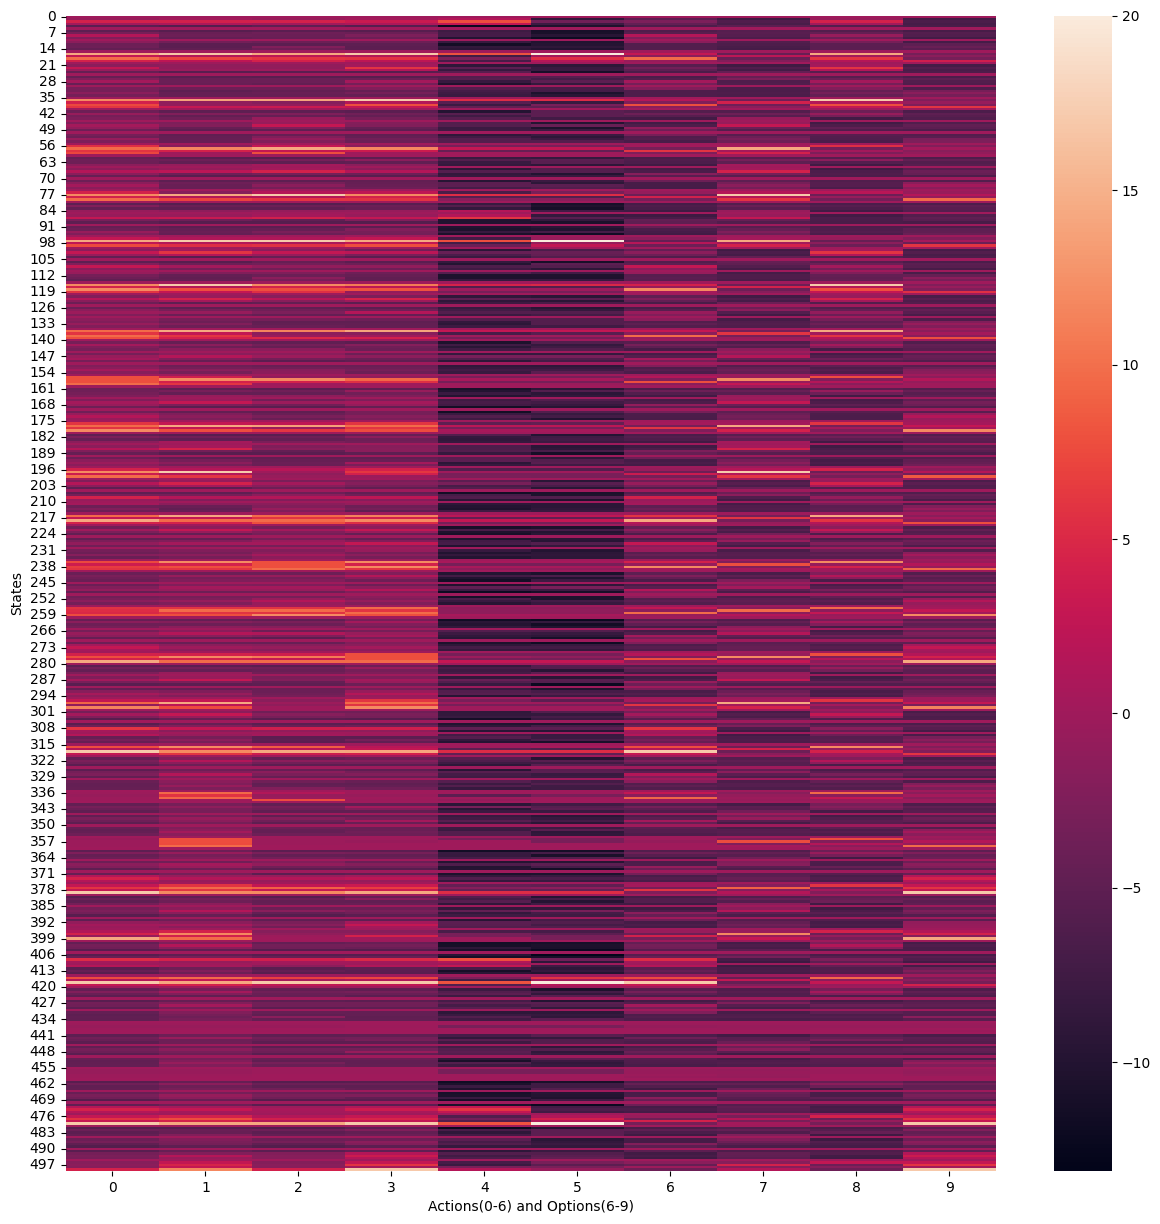

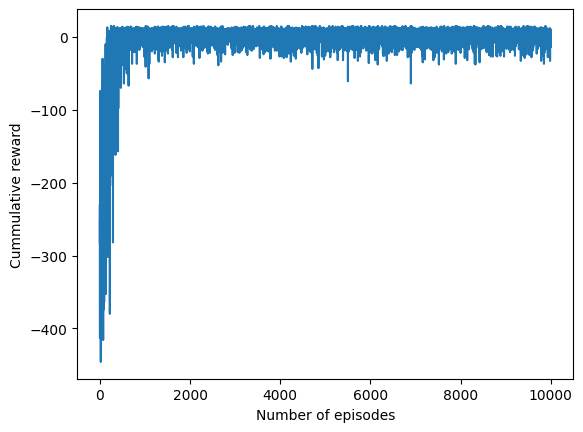

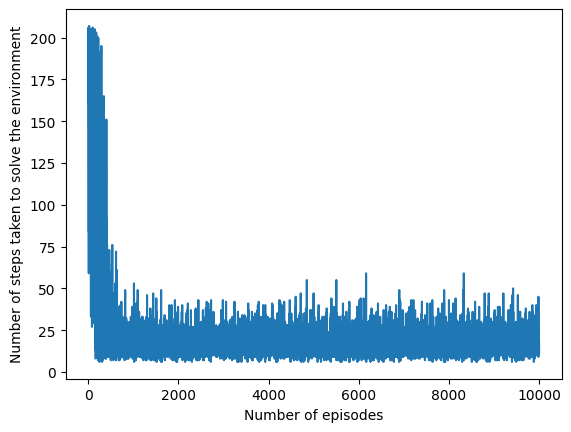

wandb: Agent Starting Run: 22k646ip with config:
wandb: 	EPS: 0.2295021794683157
wandb: 	LR: 0.1
wandb: 	NUM_EPISODES: 200000


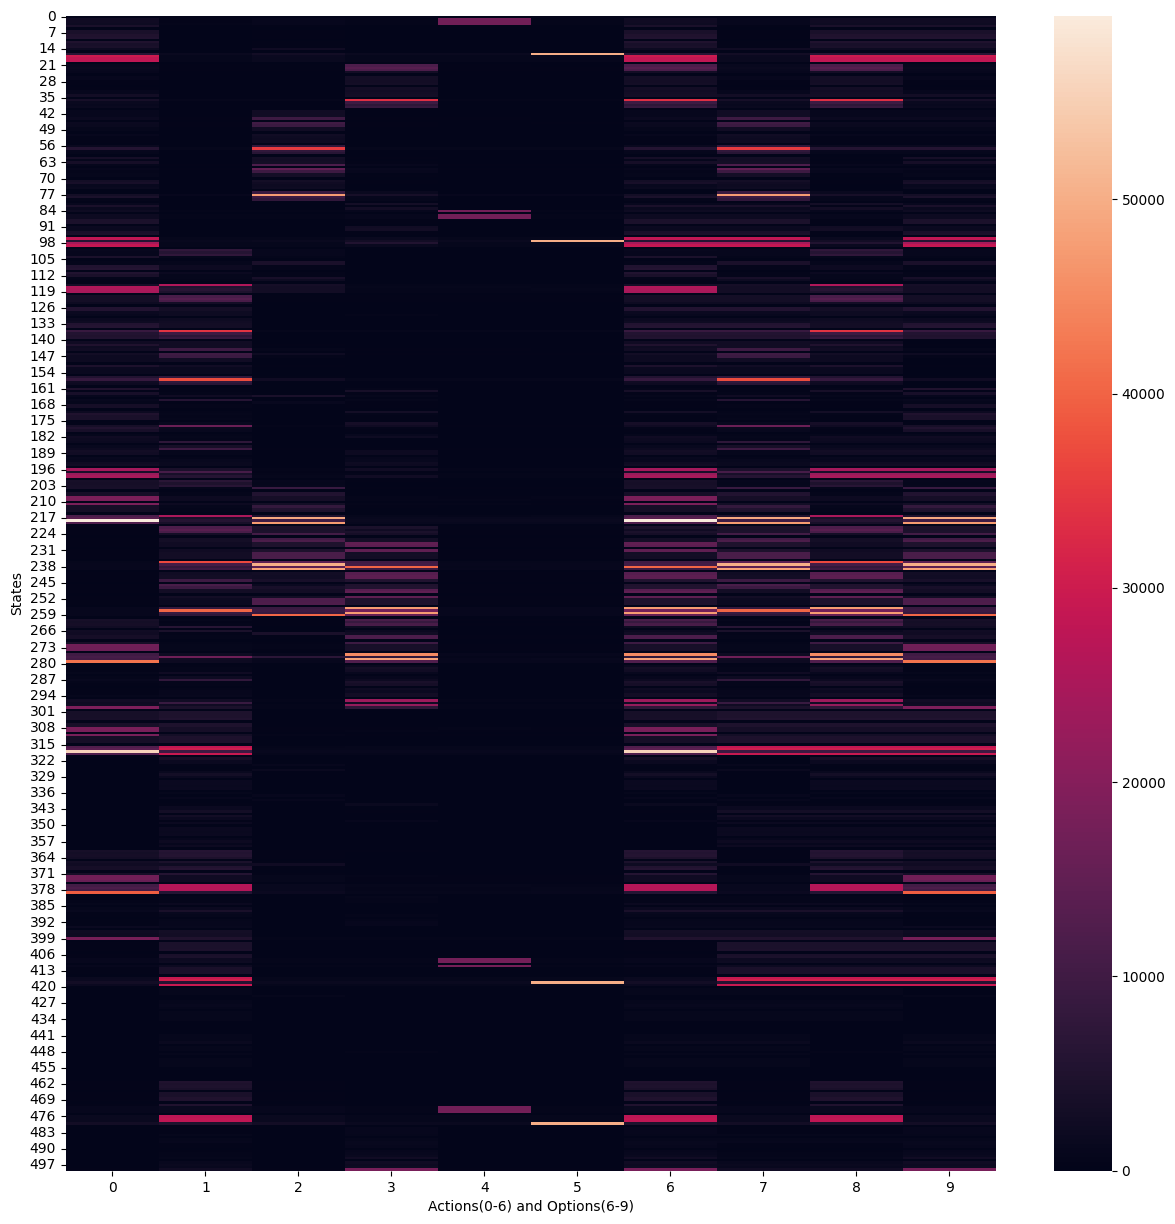

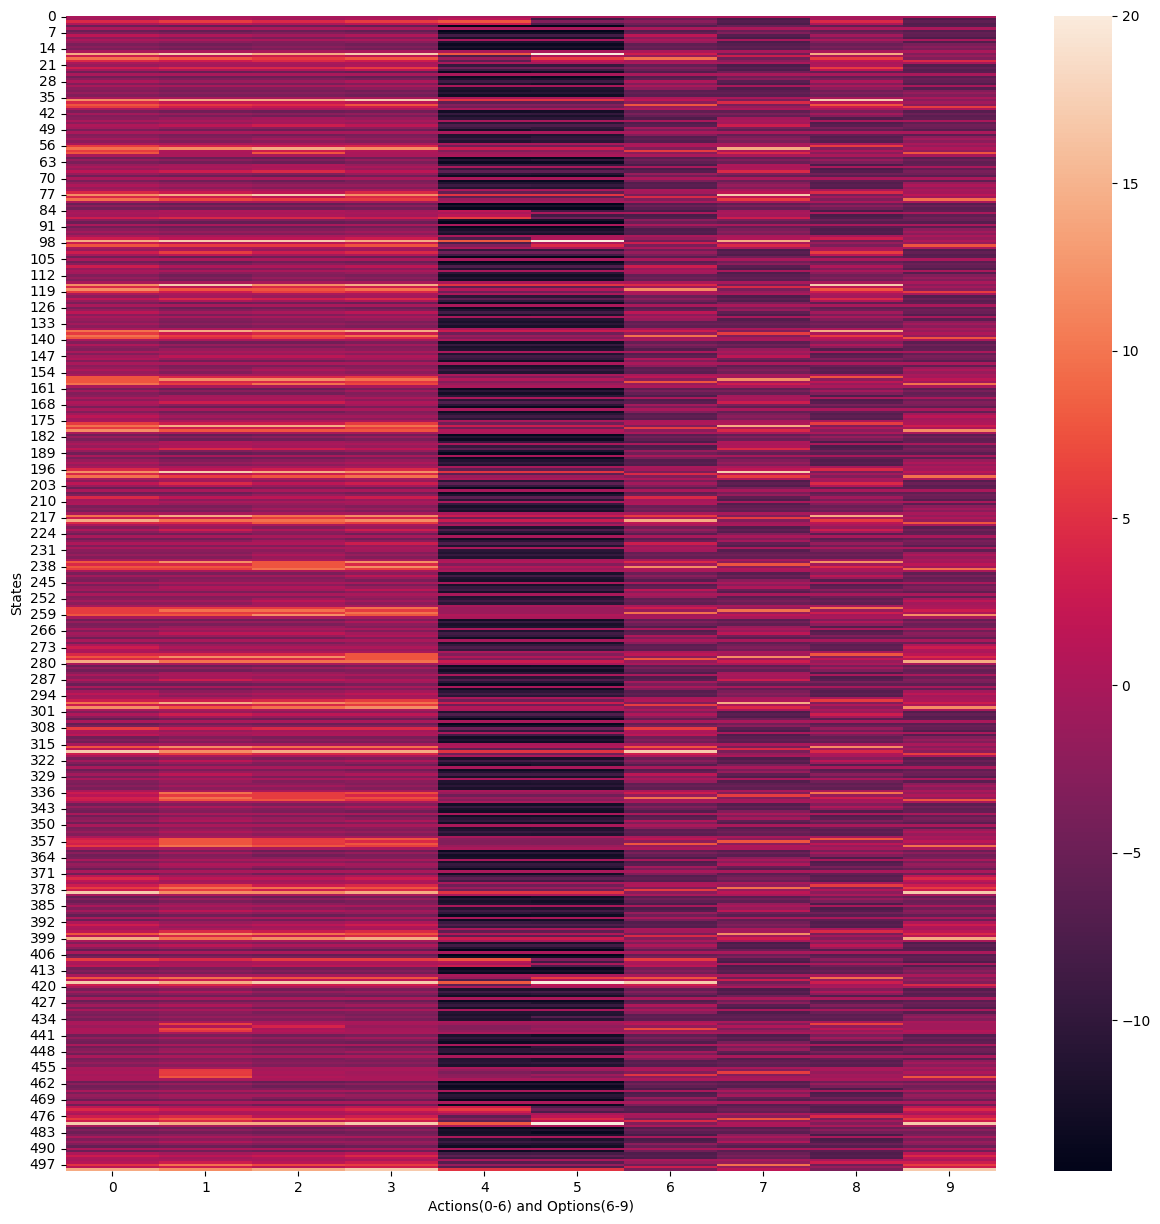

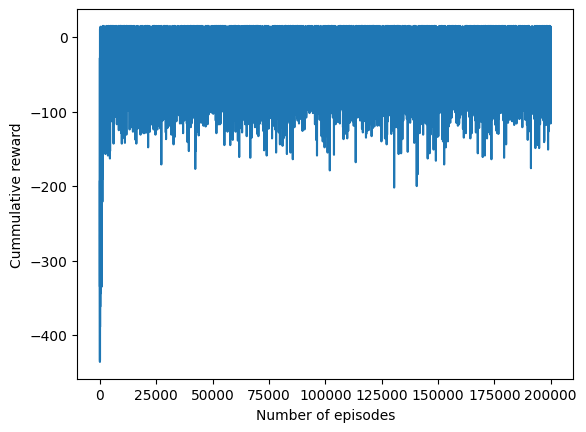

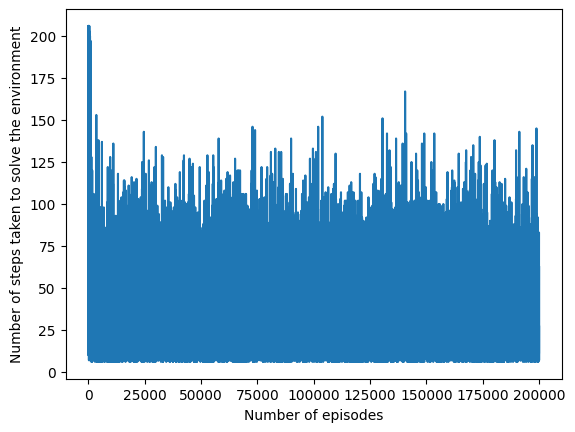

wandb: Agent Starting Run: udjg6c4e with config:
wandb: 	EPS: 0.18383877693095912
wandb: 	LR: 1
wandb: 	NUM_EPISODES: 50000


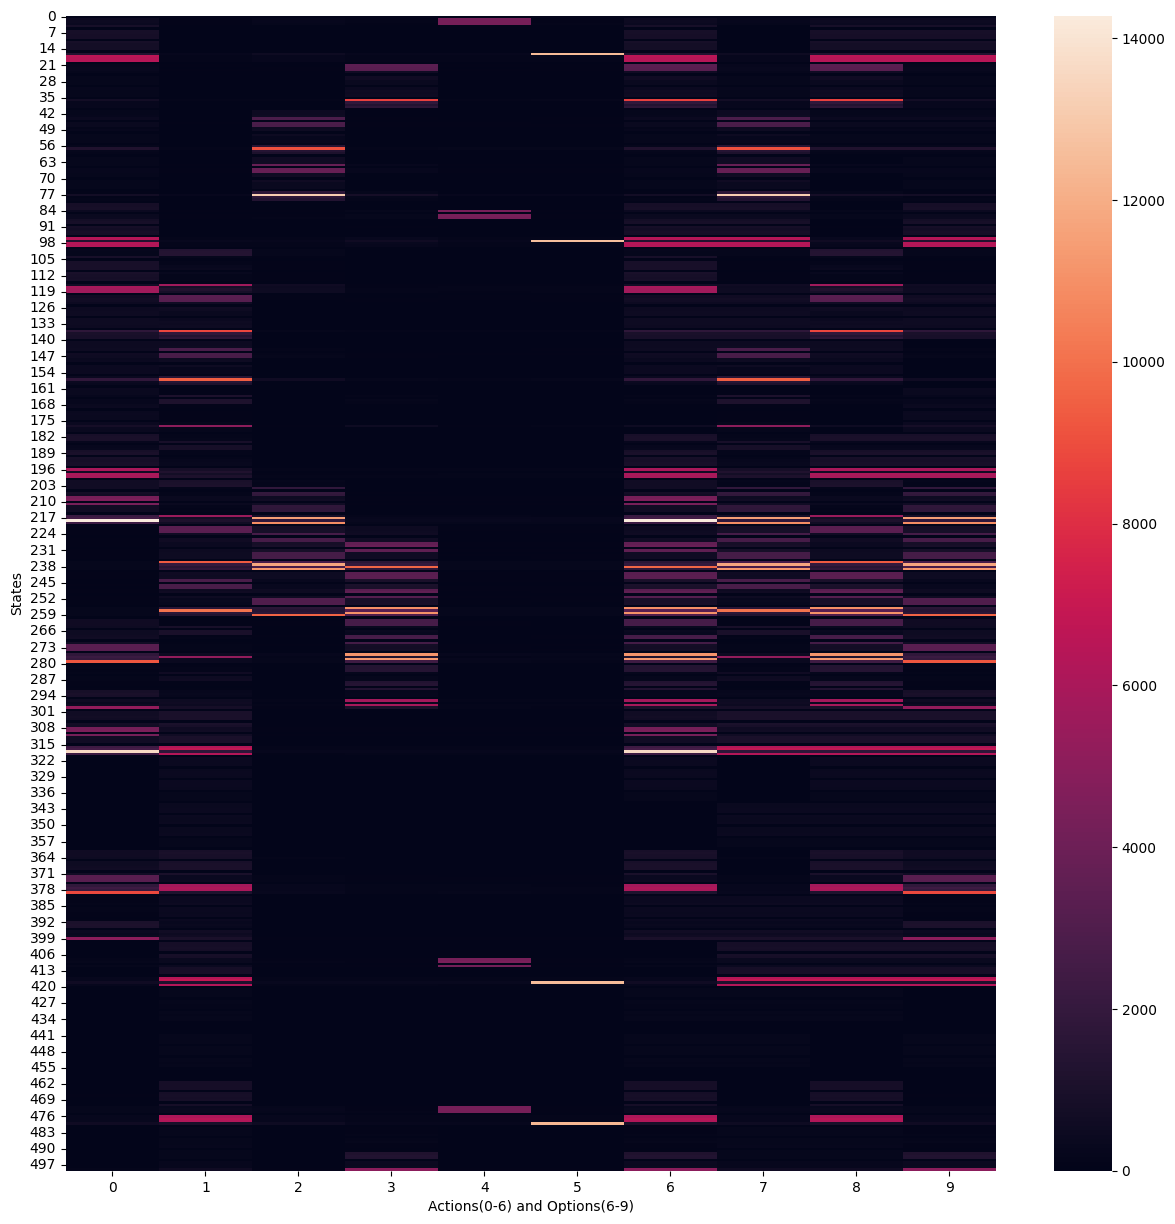

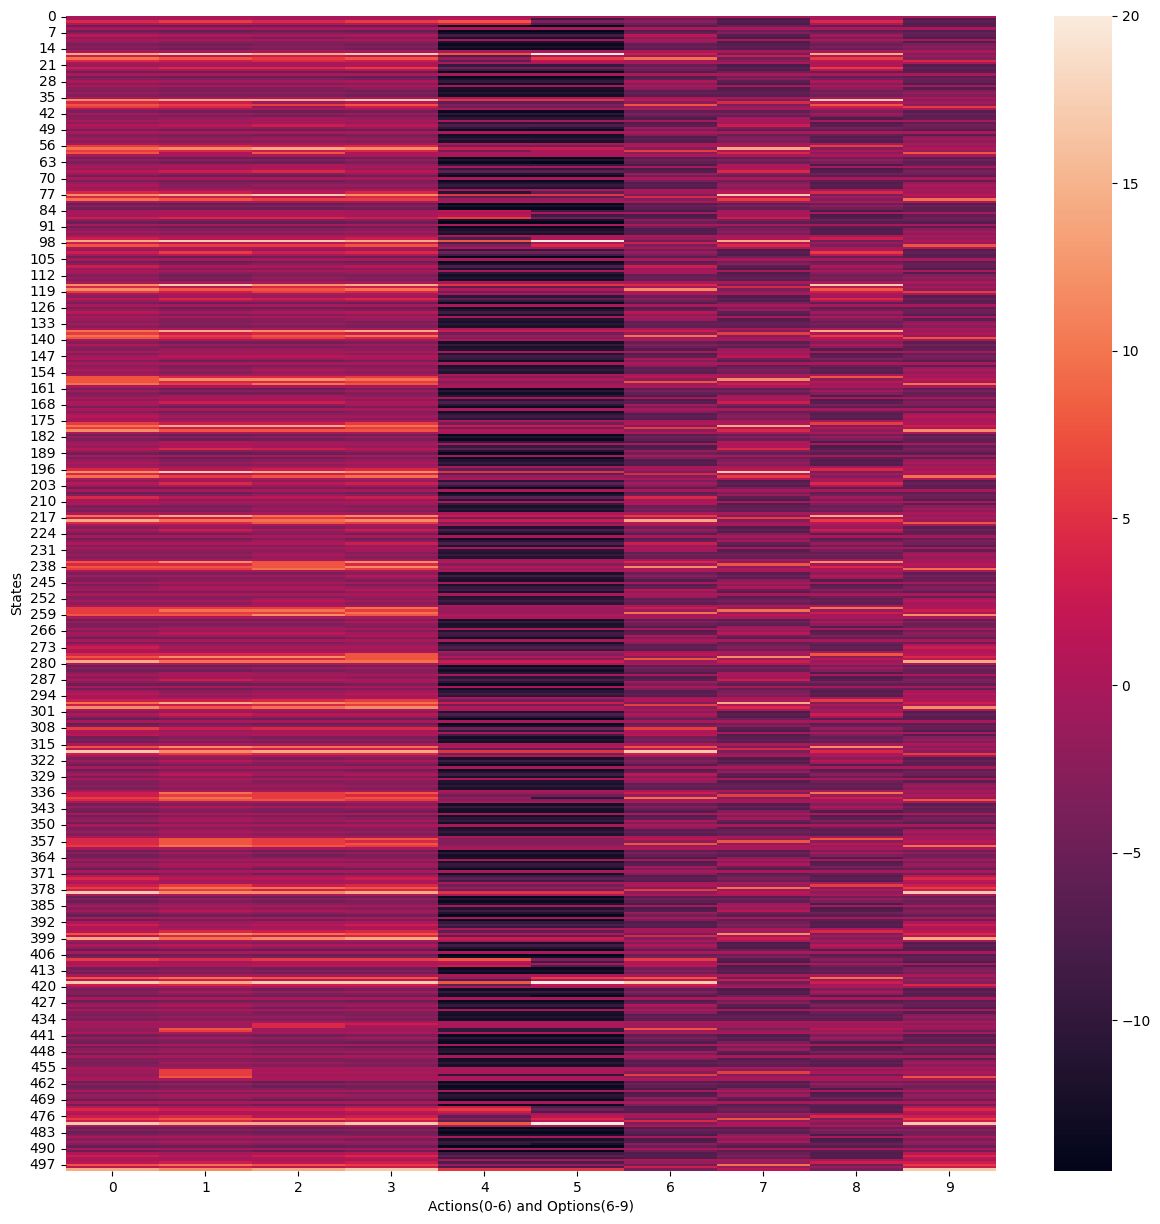

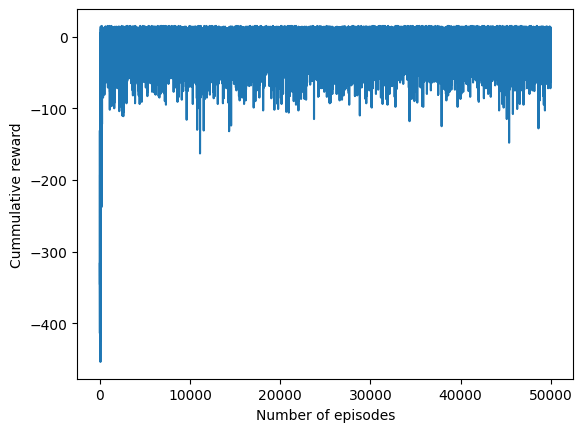

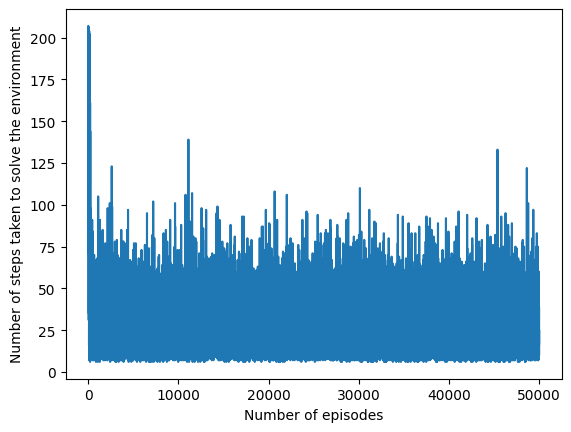

wandb: Agent Starting Run: 5g11rg00 with config:
wandb: 	EPS: 0.1856618296002445
wandb: 	LR: 0.01
wandb: 	NUM_EPISODES: 200000


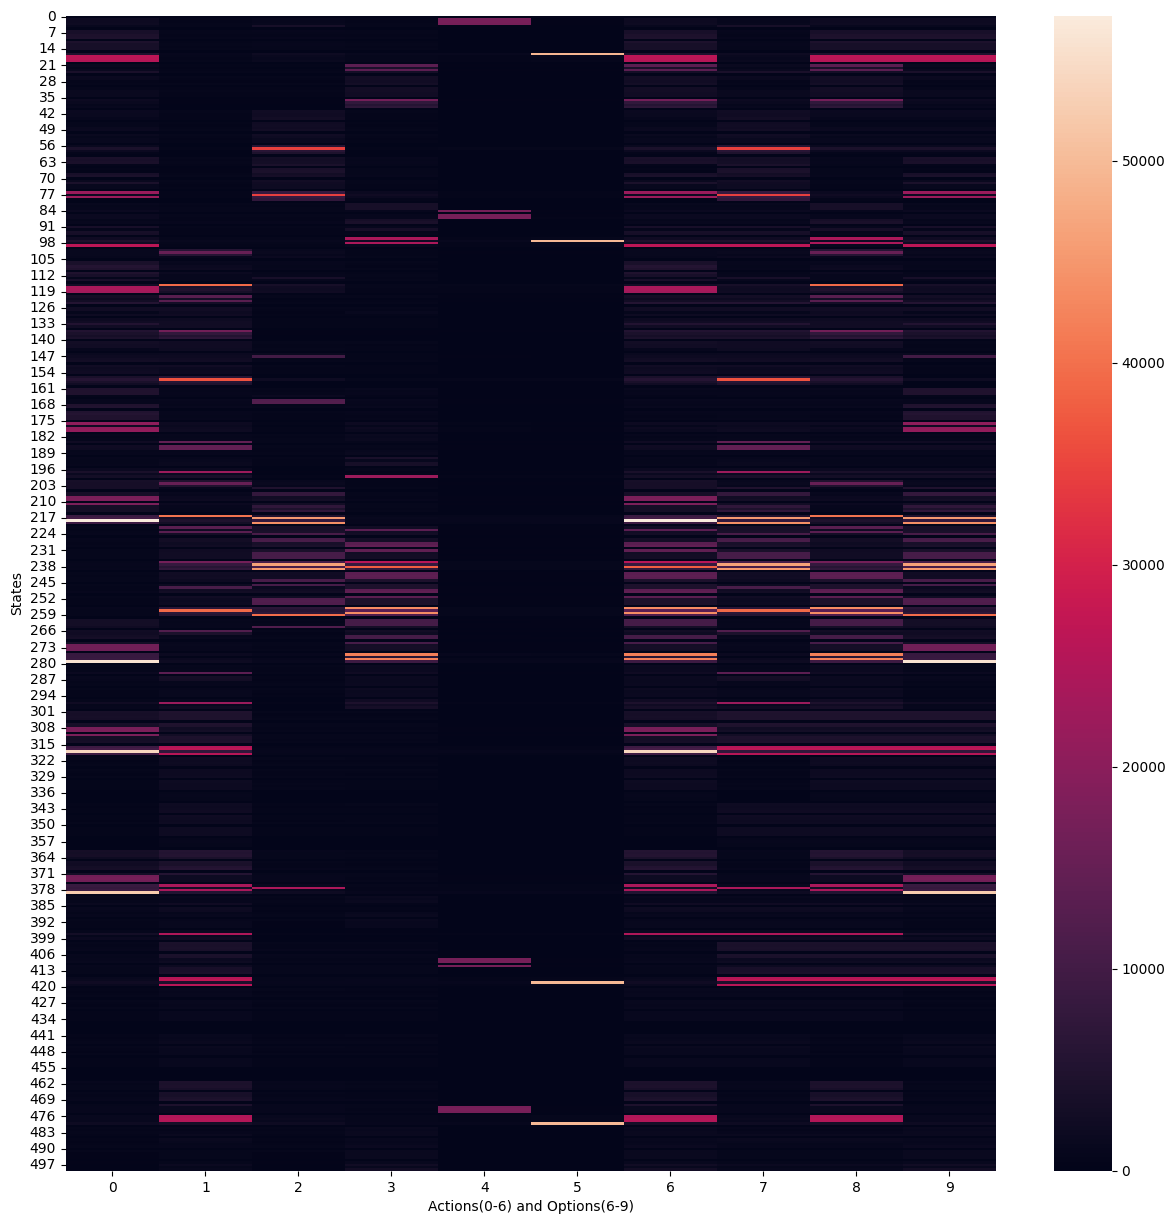

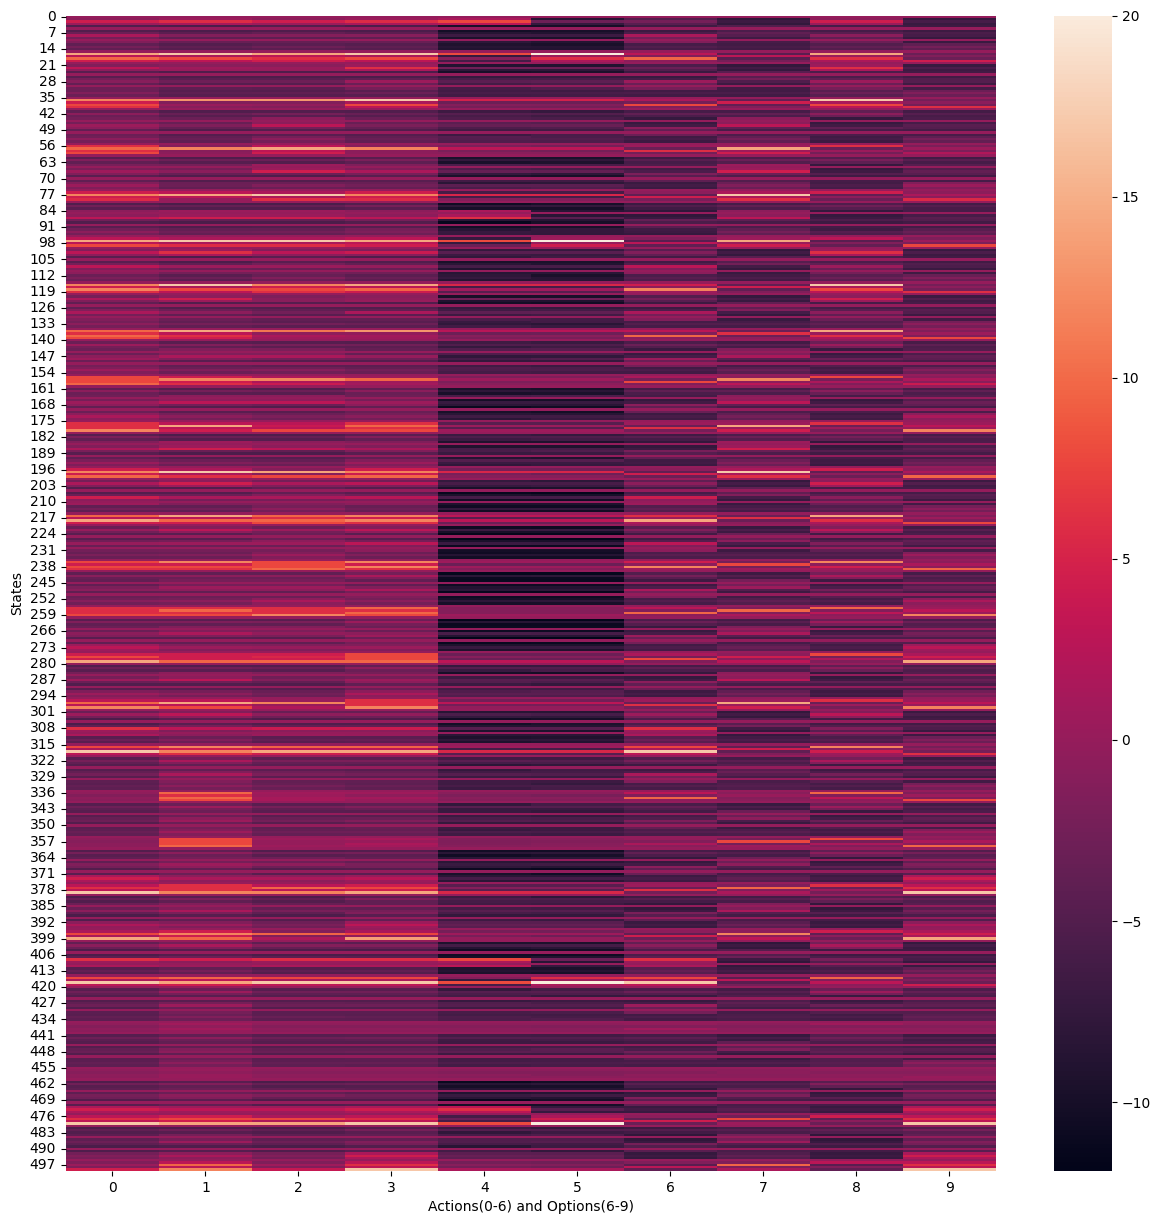

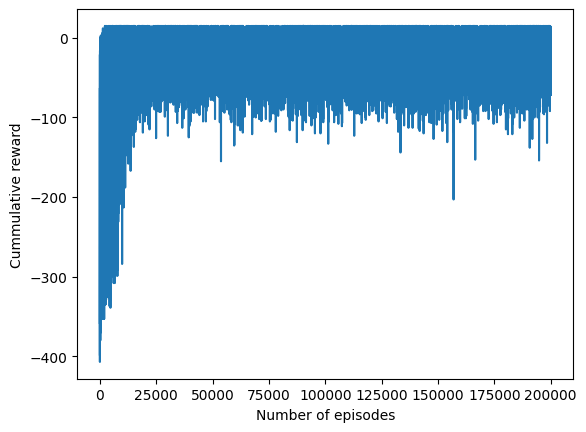

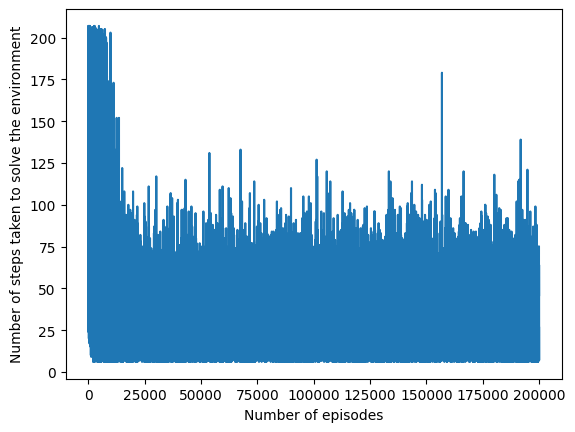

wandb: Agent Starting Run: 6bfe555w with config:
wandb: 	EPS: 0.29709632146296255
wandb: 	LR: 1
wandb: 	NUM_EPISODES: 100000


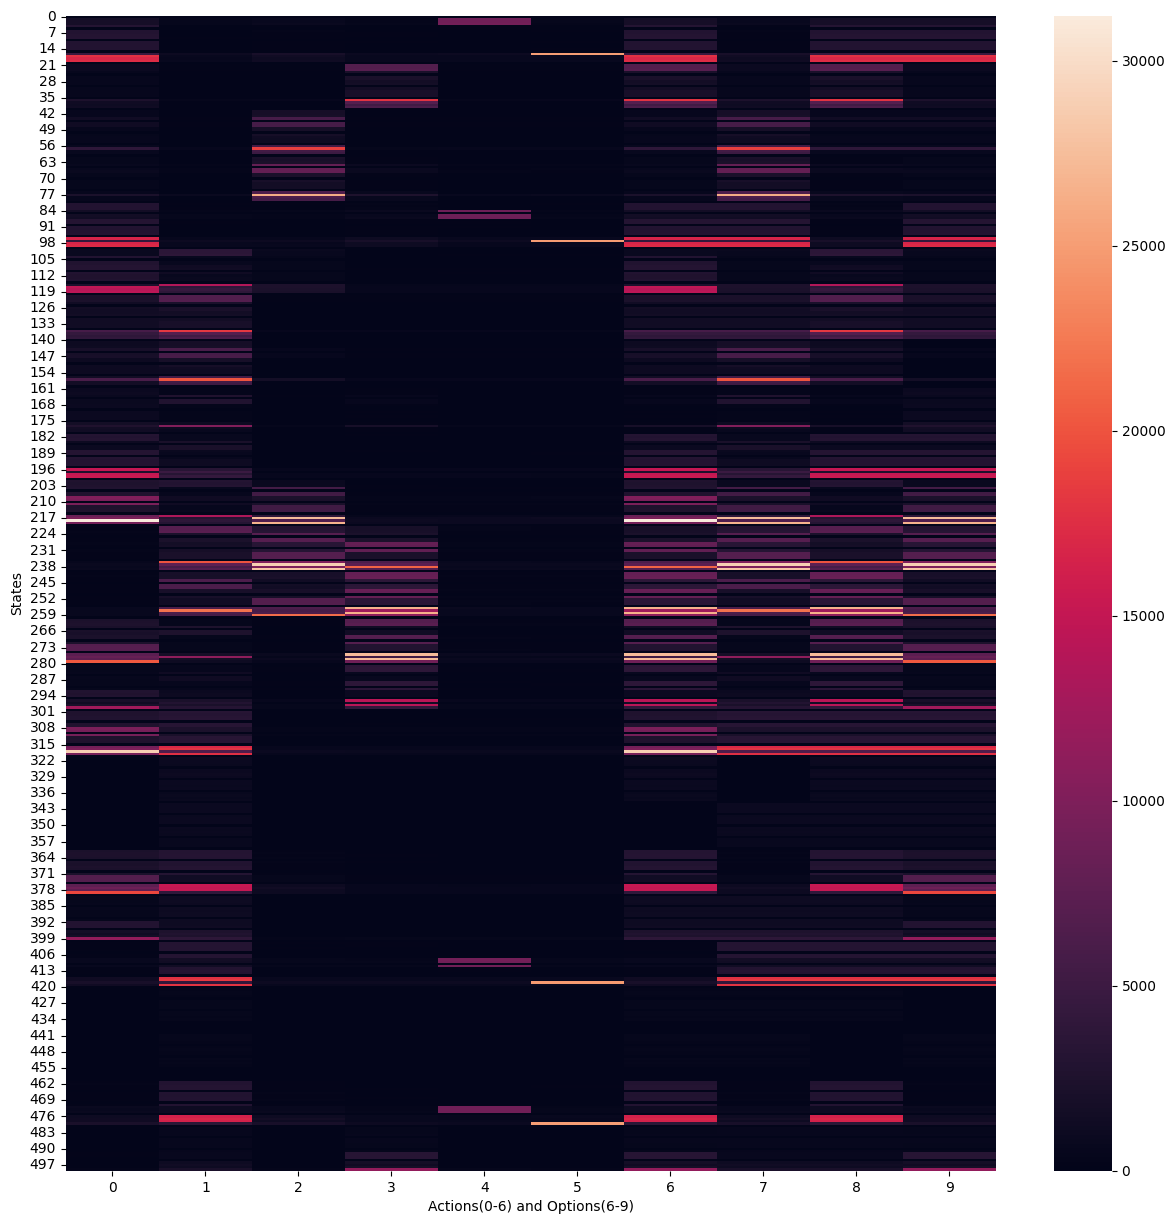

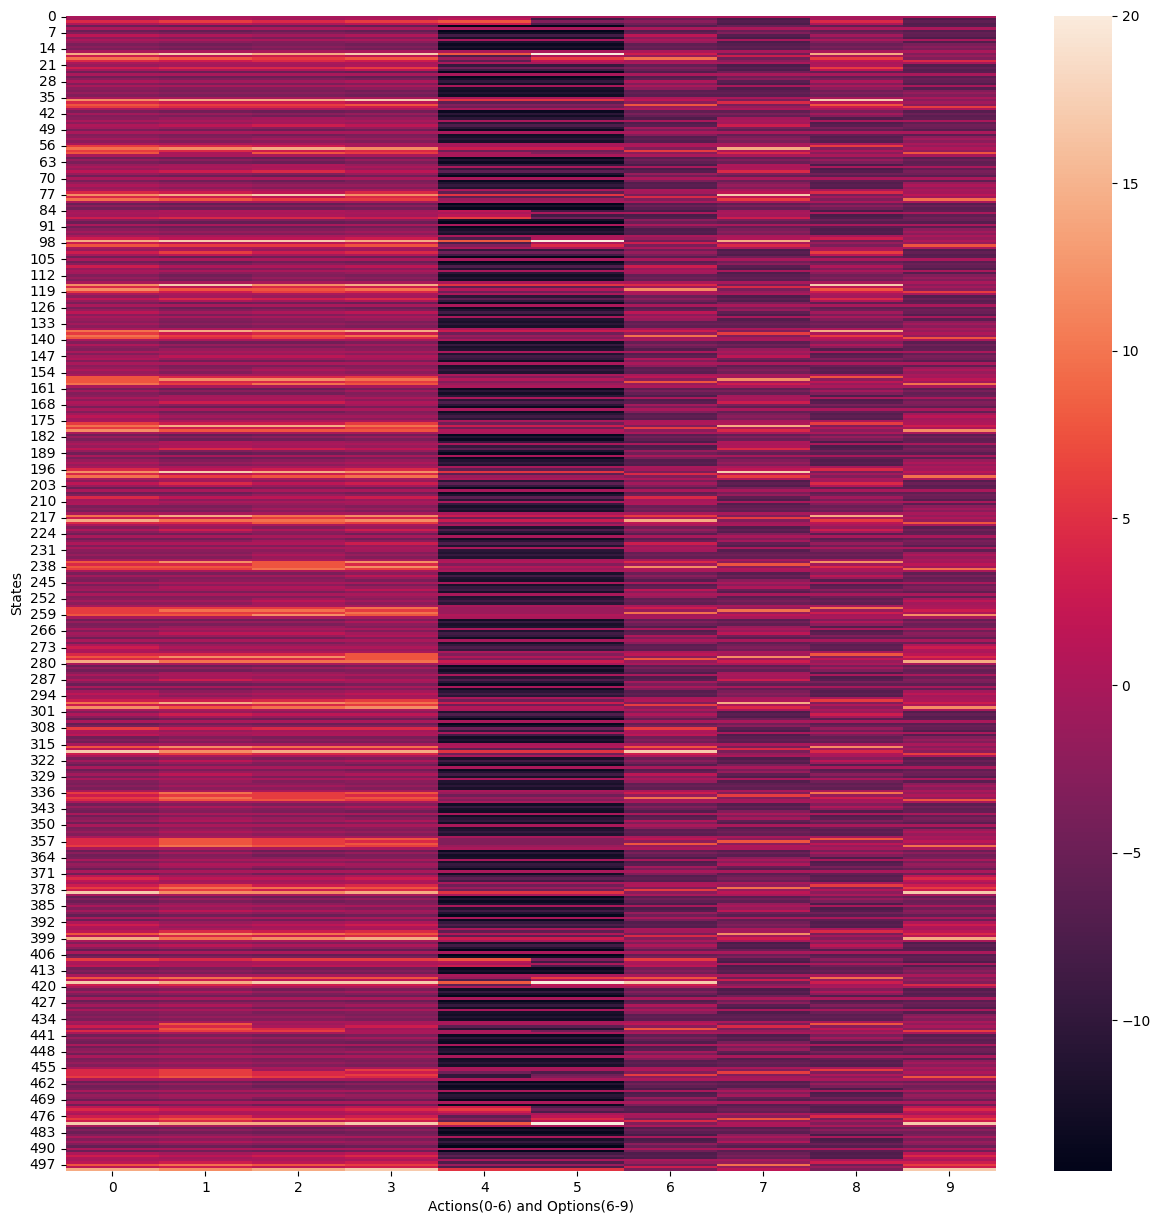

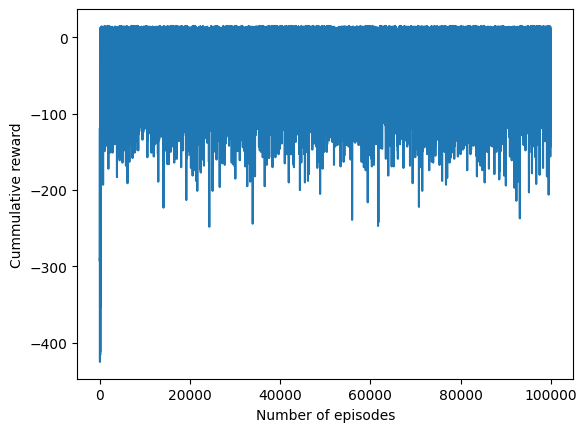

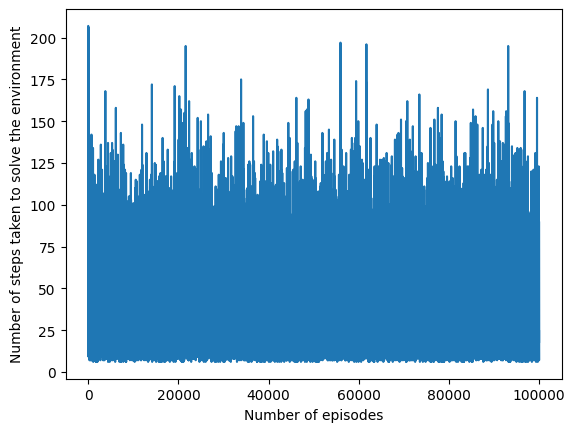

wandb: Agent Starting Run: cxhttsit with config:
wandb: 	EPS: 0.2132653166952979
wandb: 	LR: 0.2
wandb: 	NUM_EPISODES: 100000


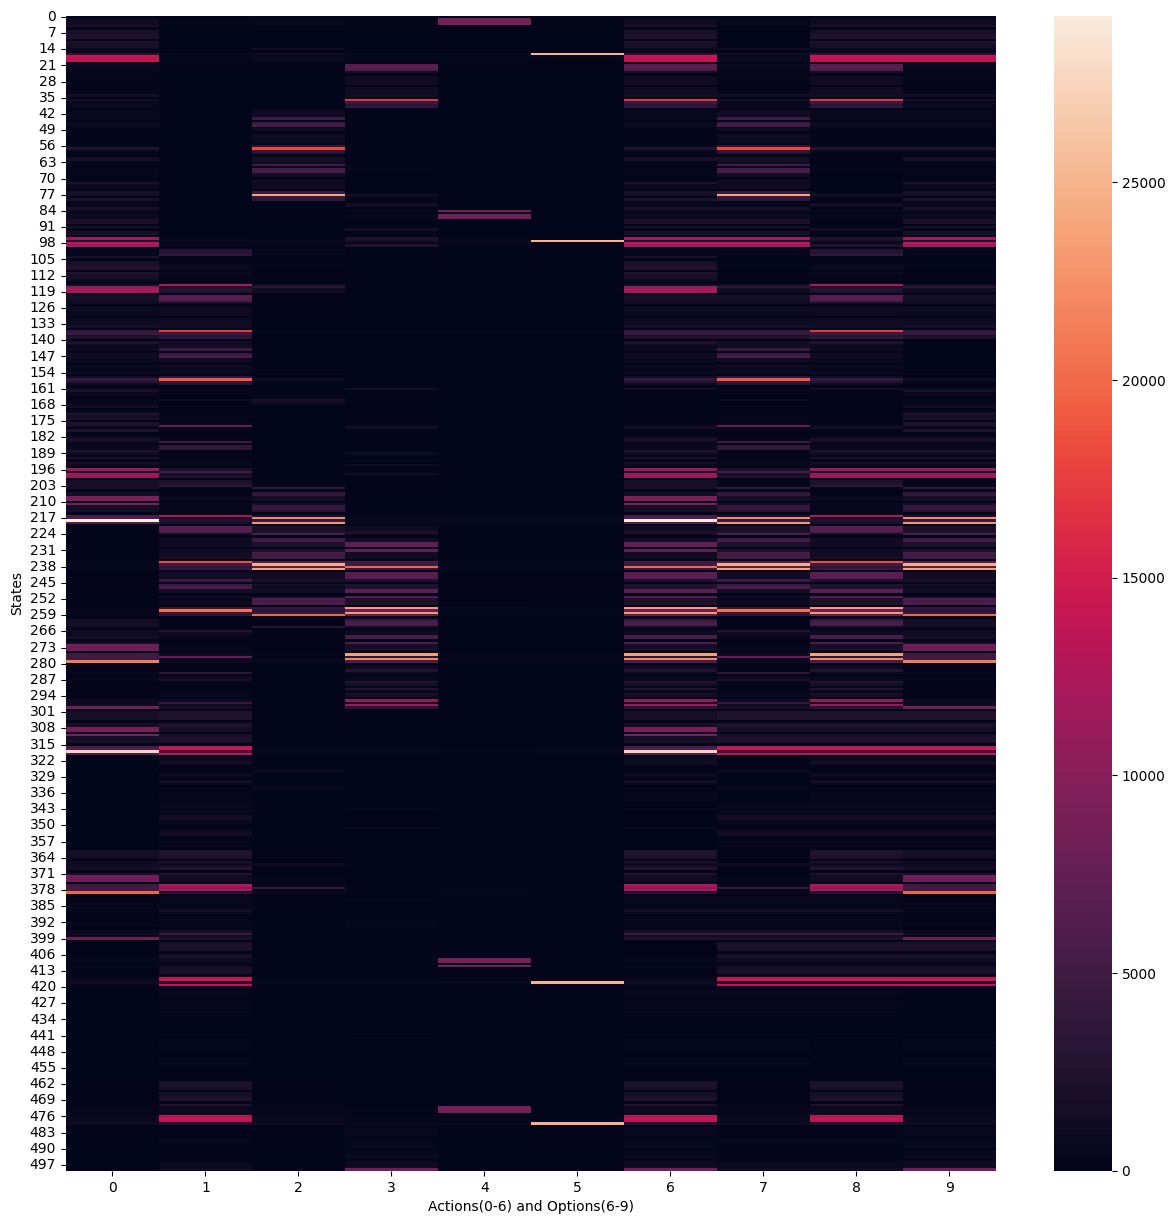

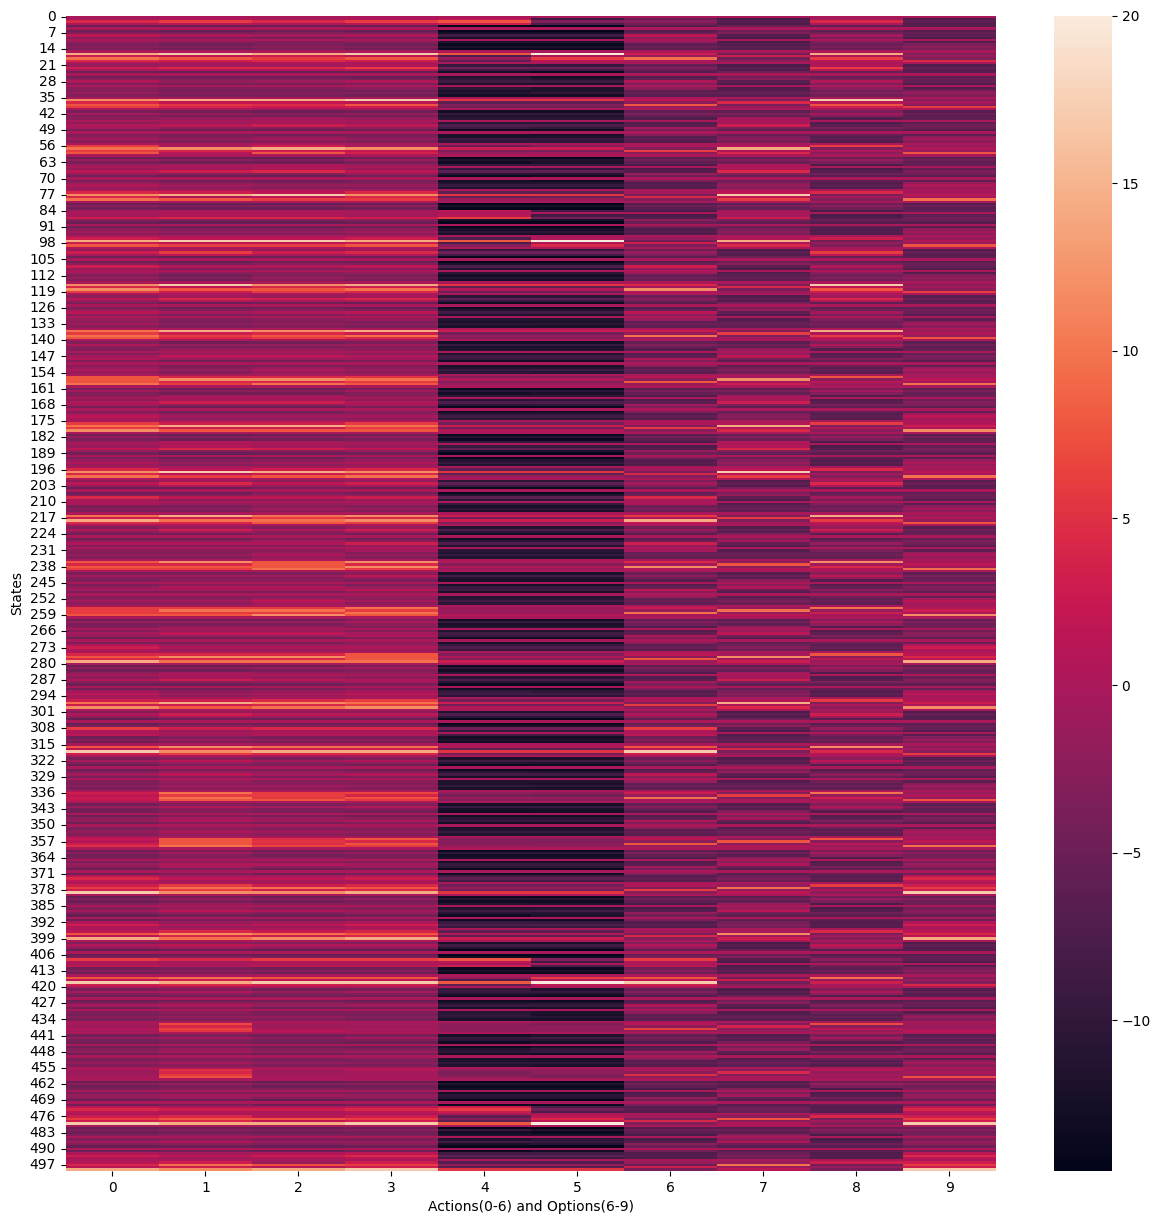

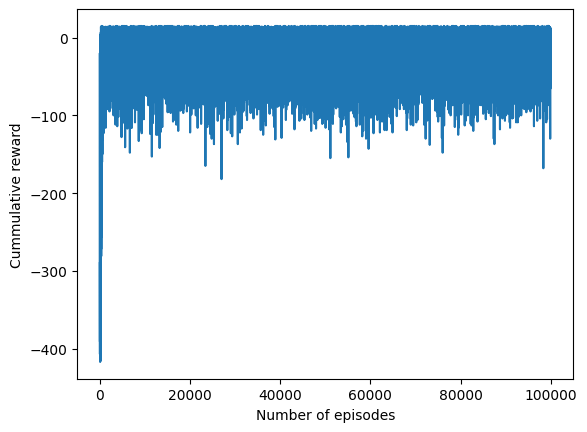

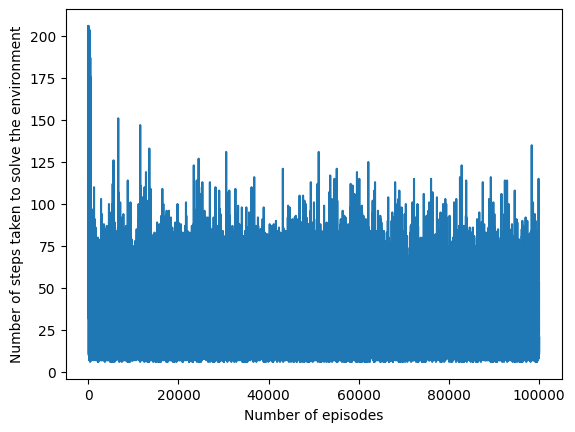

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2lu7dpj2 with config:
wandb: 	EPS: 0.055434371231188426
wandb: 	LR: 0.3
wandb: 	NUM_EPISODES: 100000


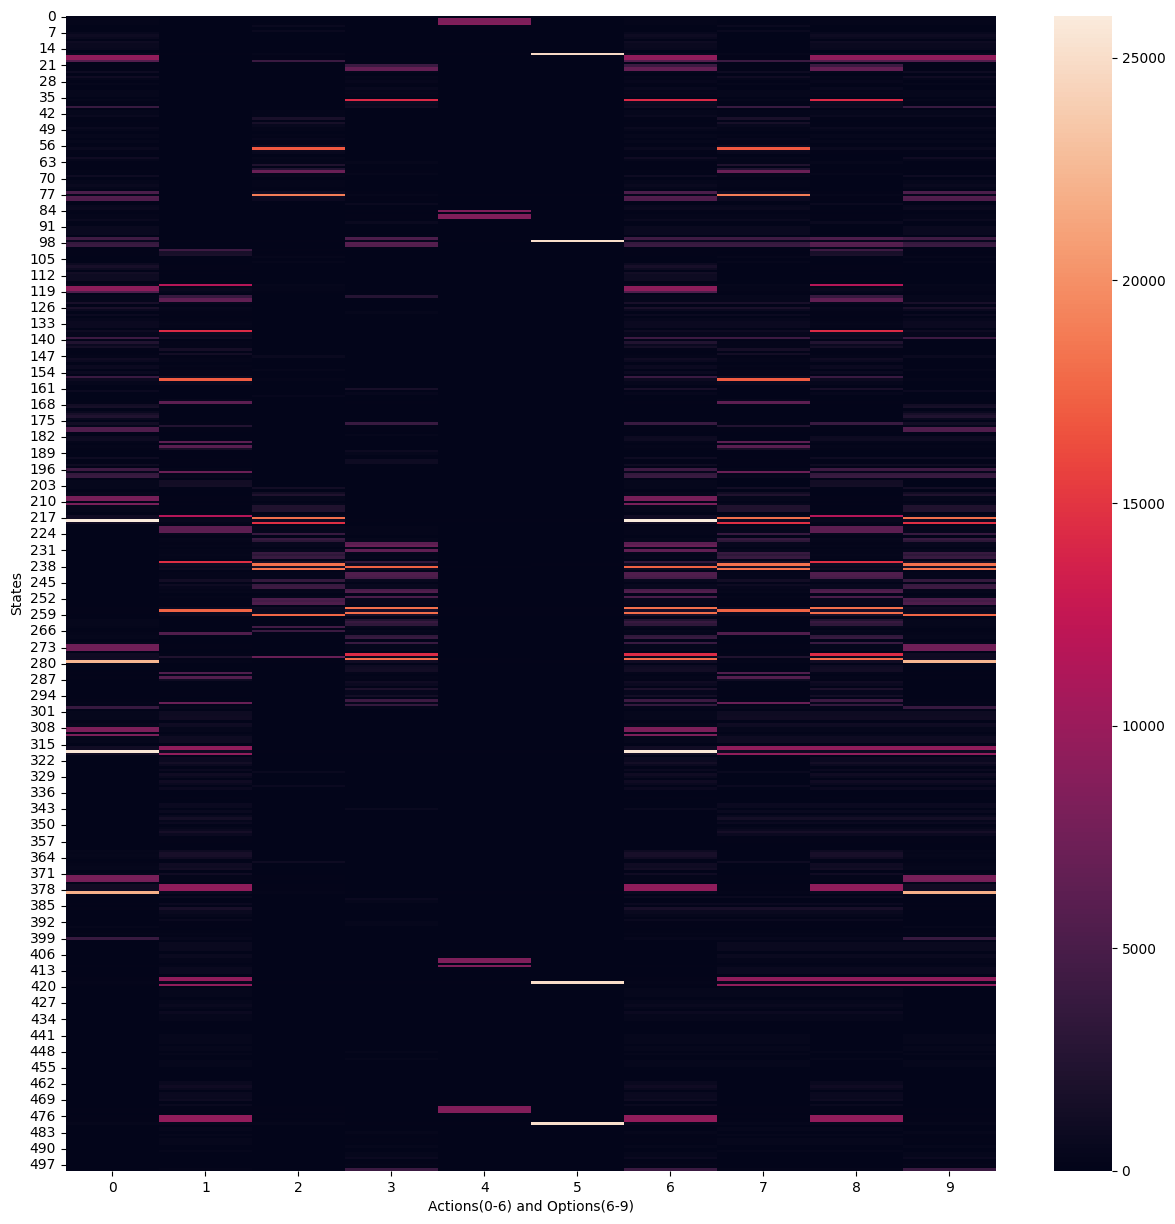

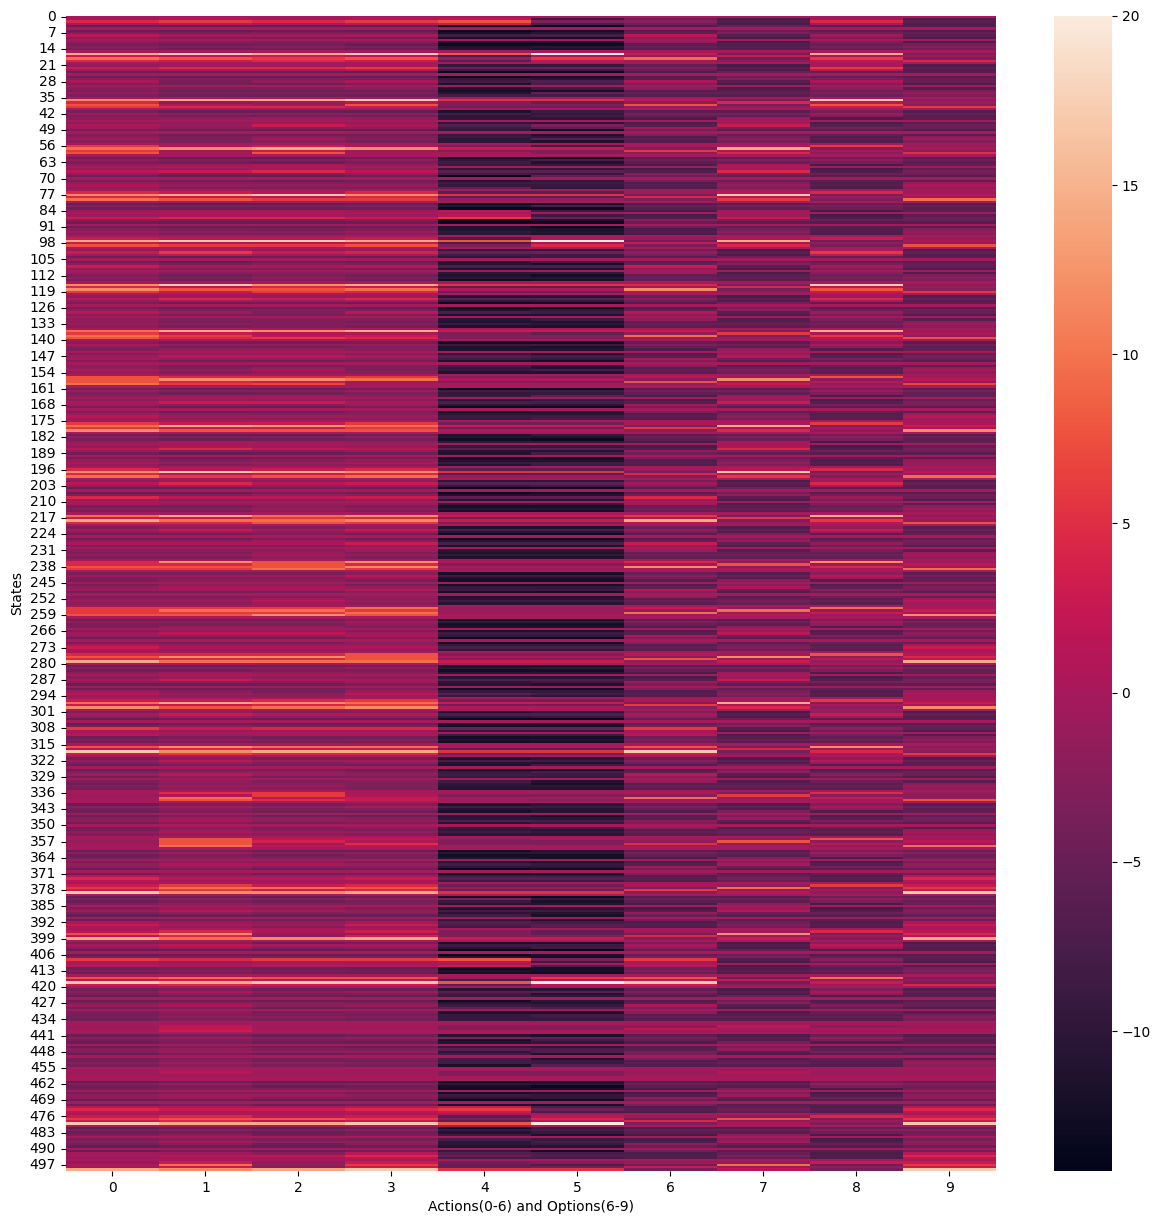

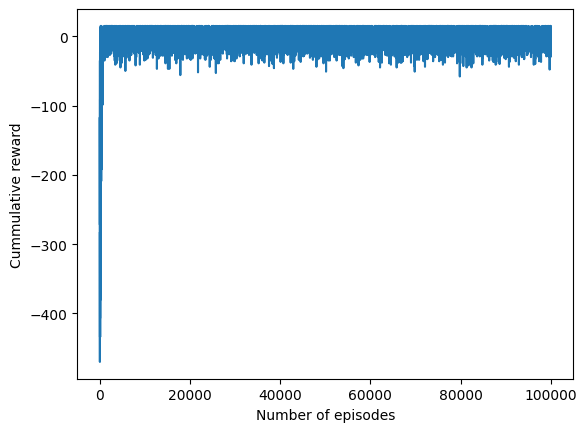

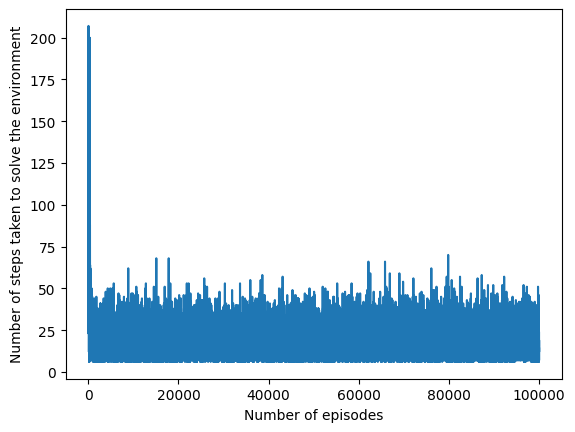

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: clh8ucqi with config:
wandb: 	EPS: 0.28081890329499354
wandb: 	LR: 0.5
wandb: 	NUM_EPISODES: 100000


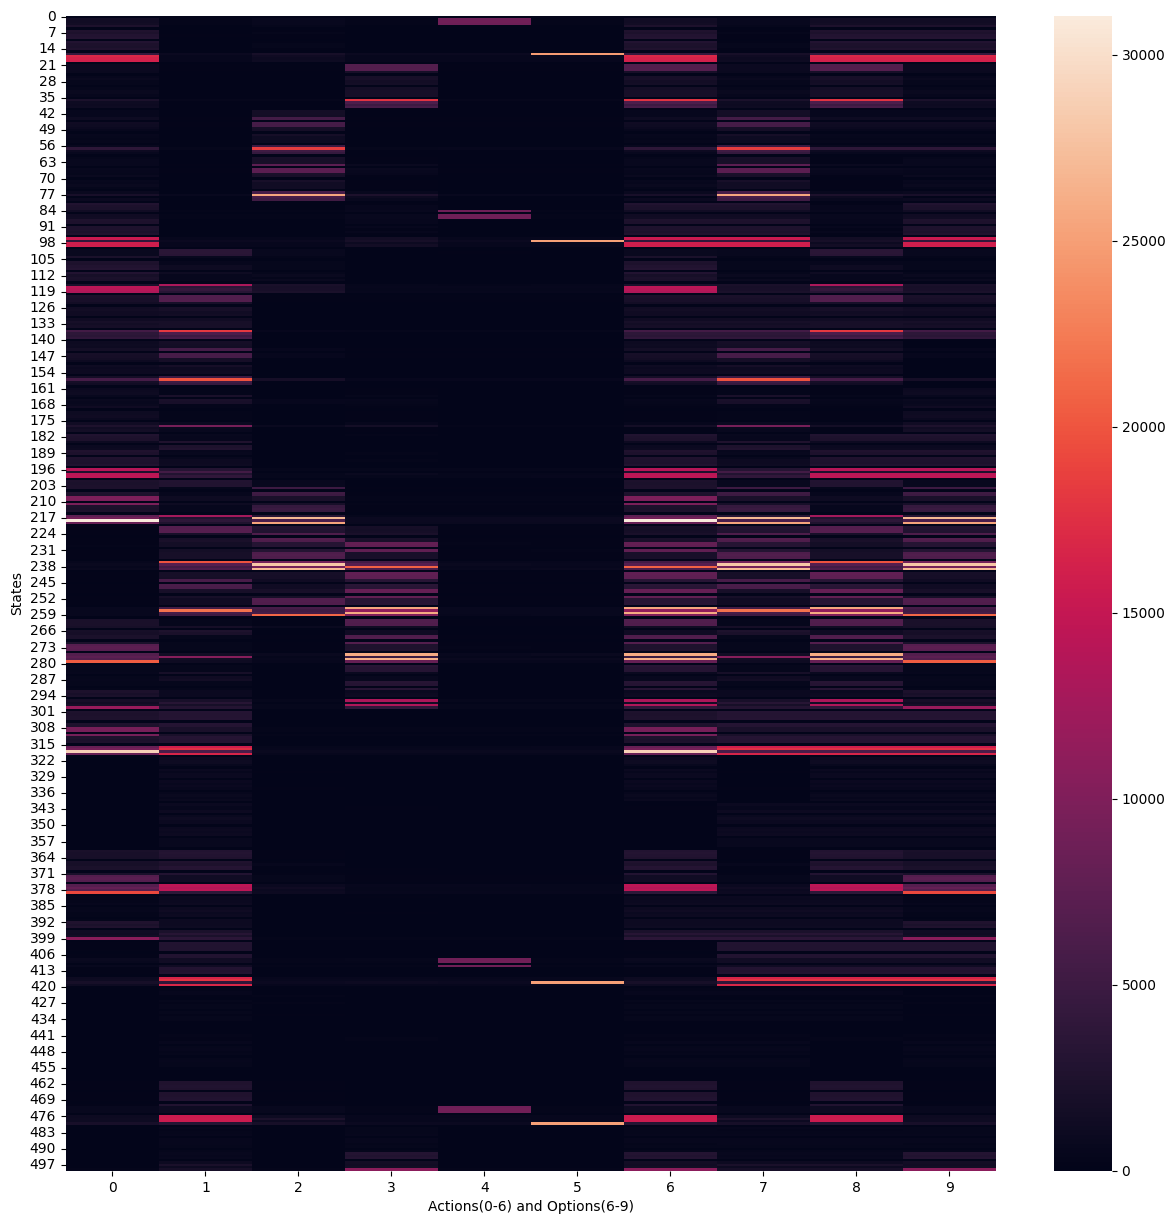

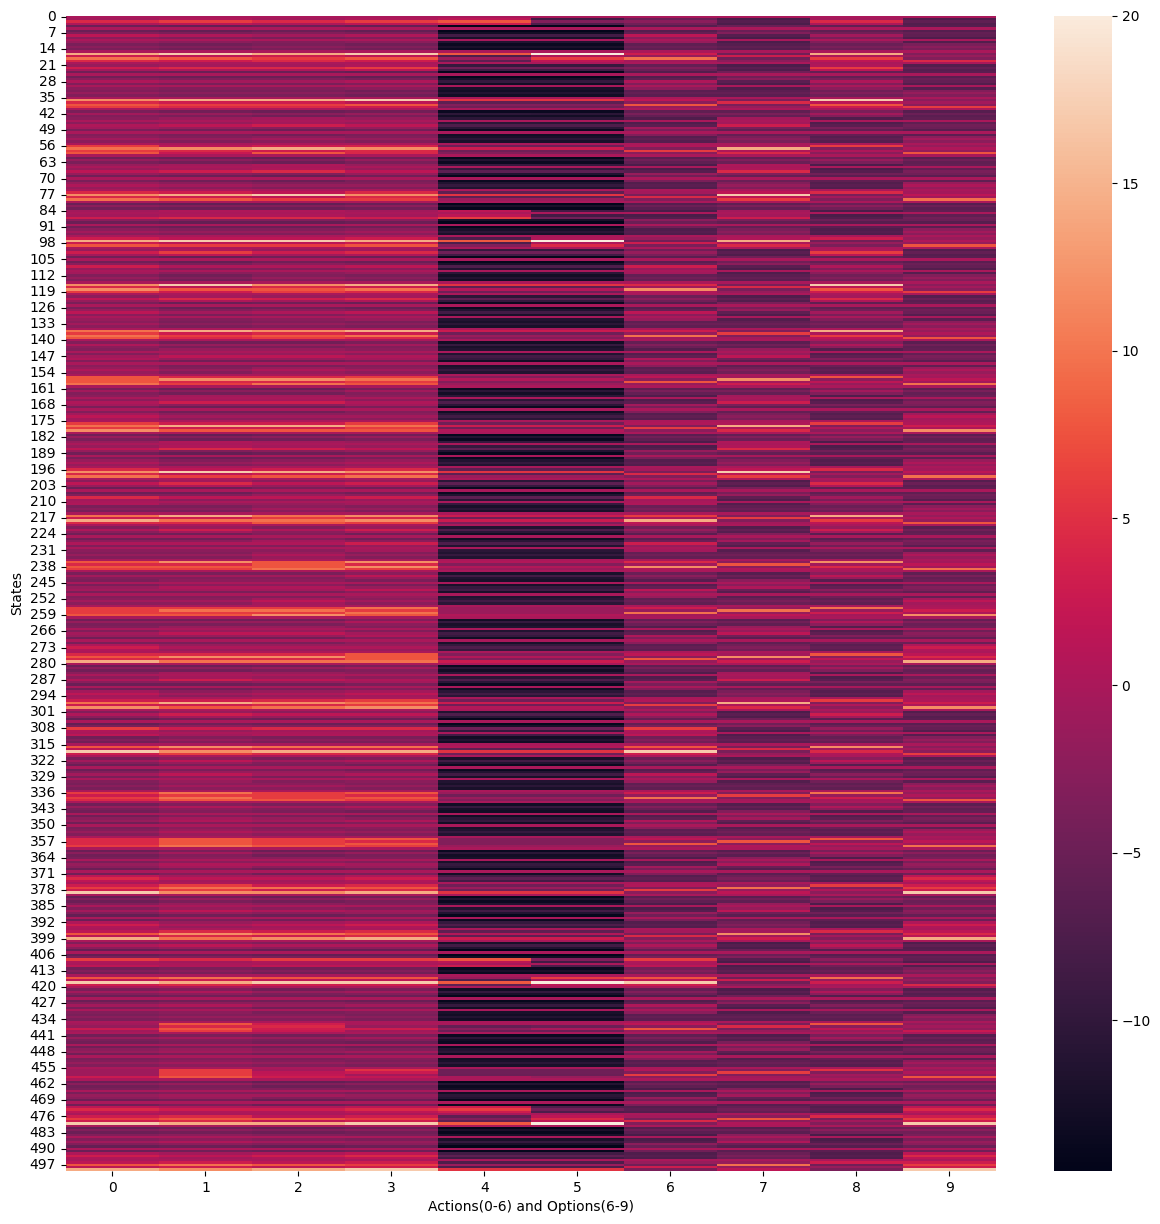

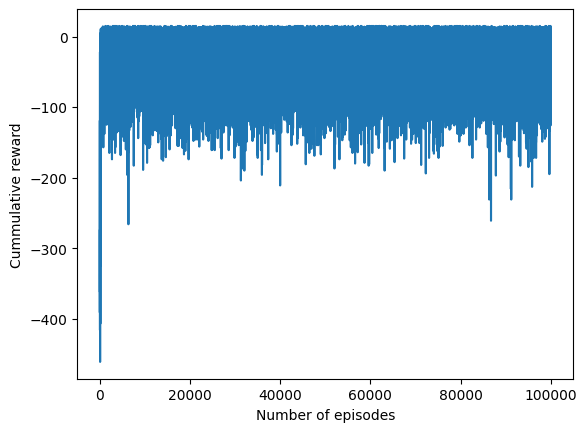

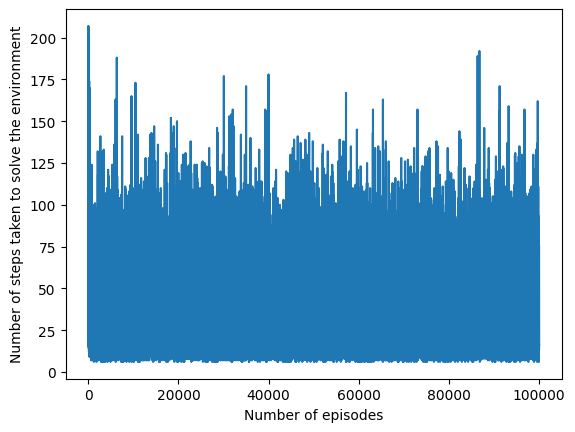

wandb: Agent Starting Run: sbfqqk85 with config:
wandb: 	EPS: 0.11906878968544111
wandb: 	LR: 0.5
wandb: 	NUM_EPISODES: 200000


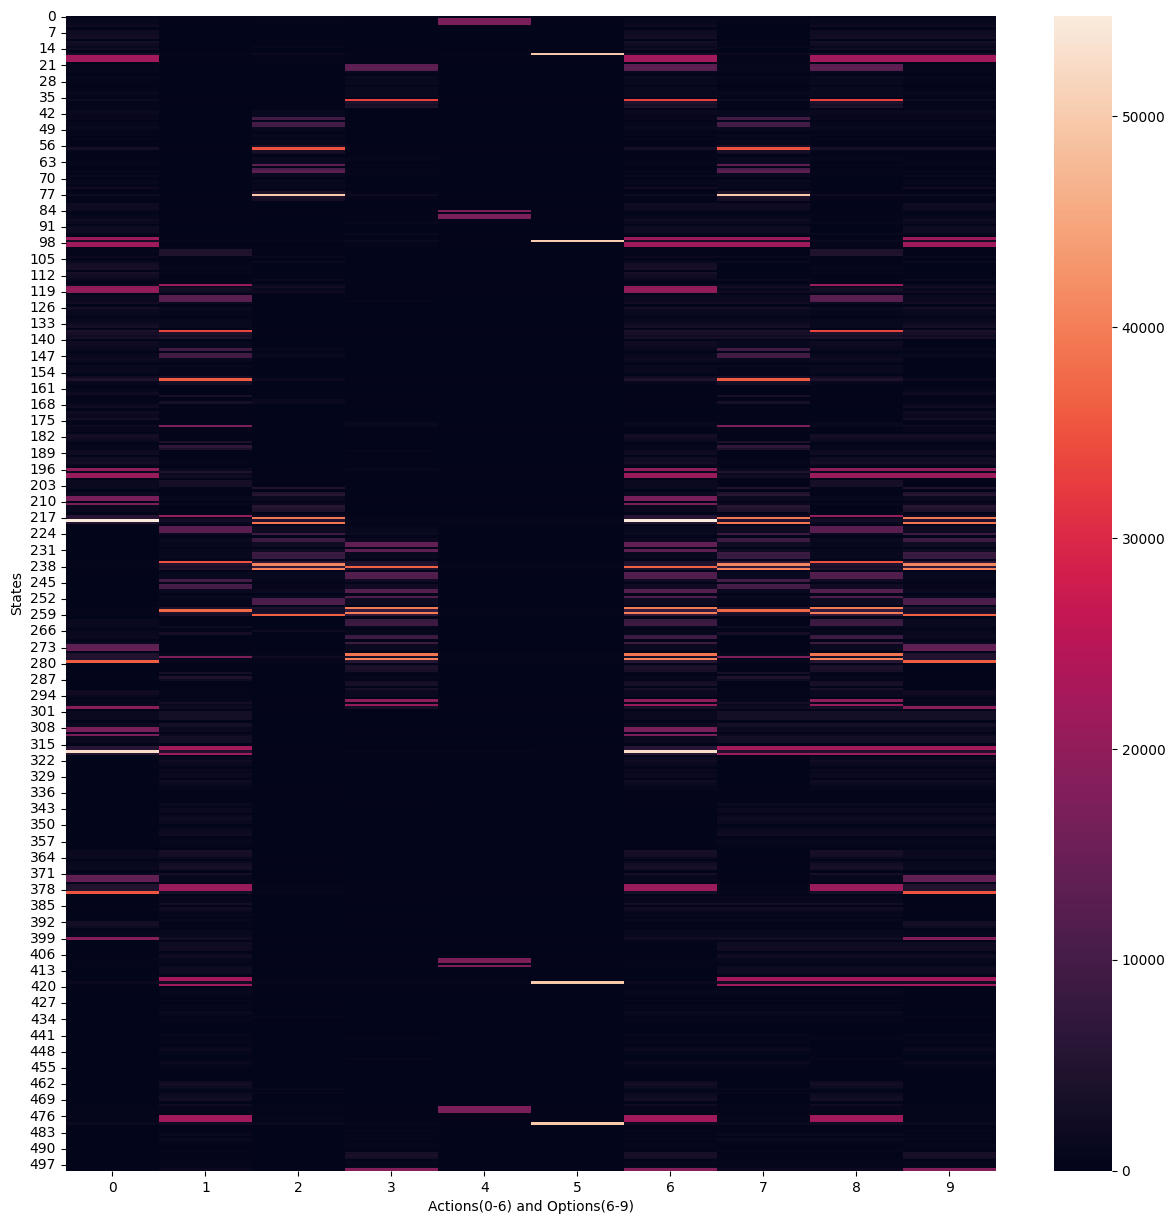

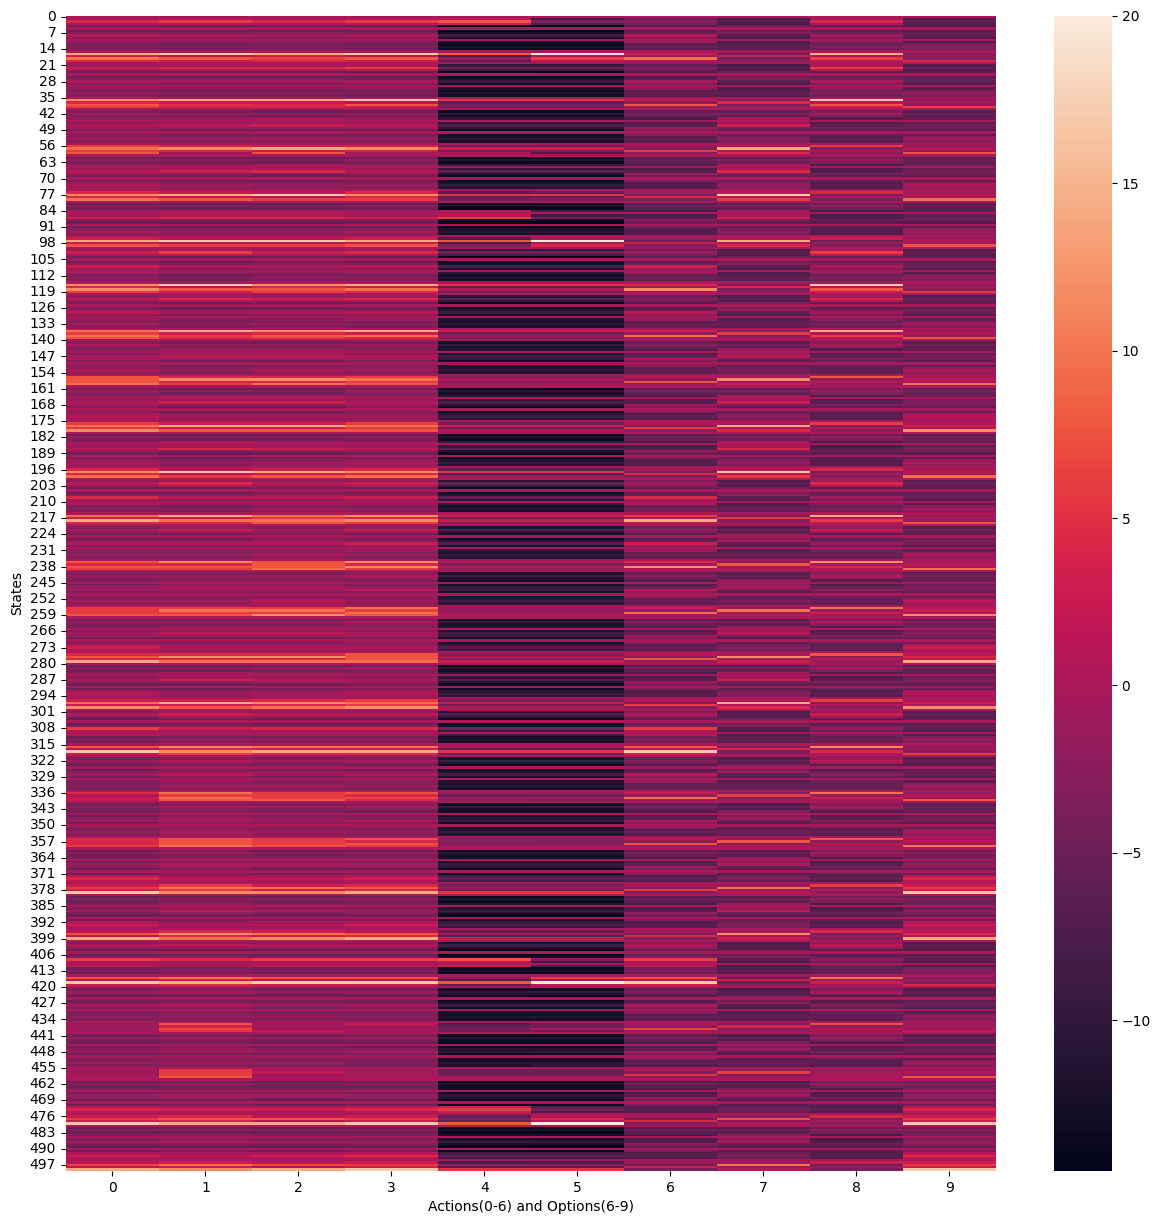

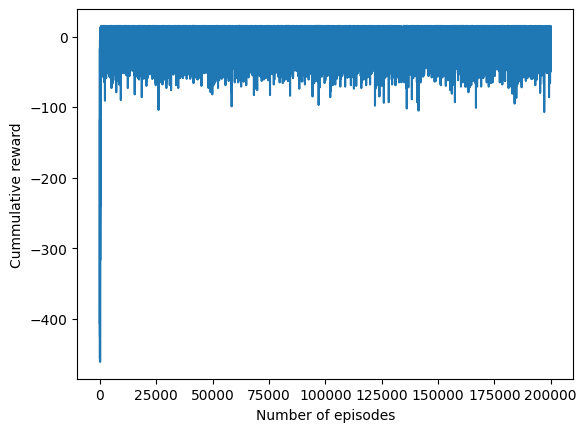

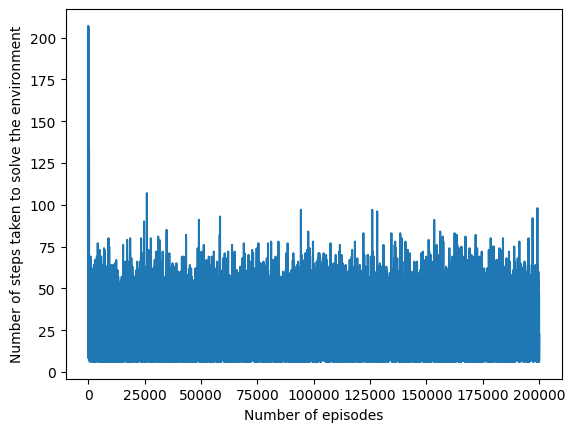

wandb: Agent Starting Run: 7qa4hds5 with config:
wandb: 	EPS: 0.2821205539214263
wandb: 	LR: 1
wandb: 	NUM_EPISODES: 10000


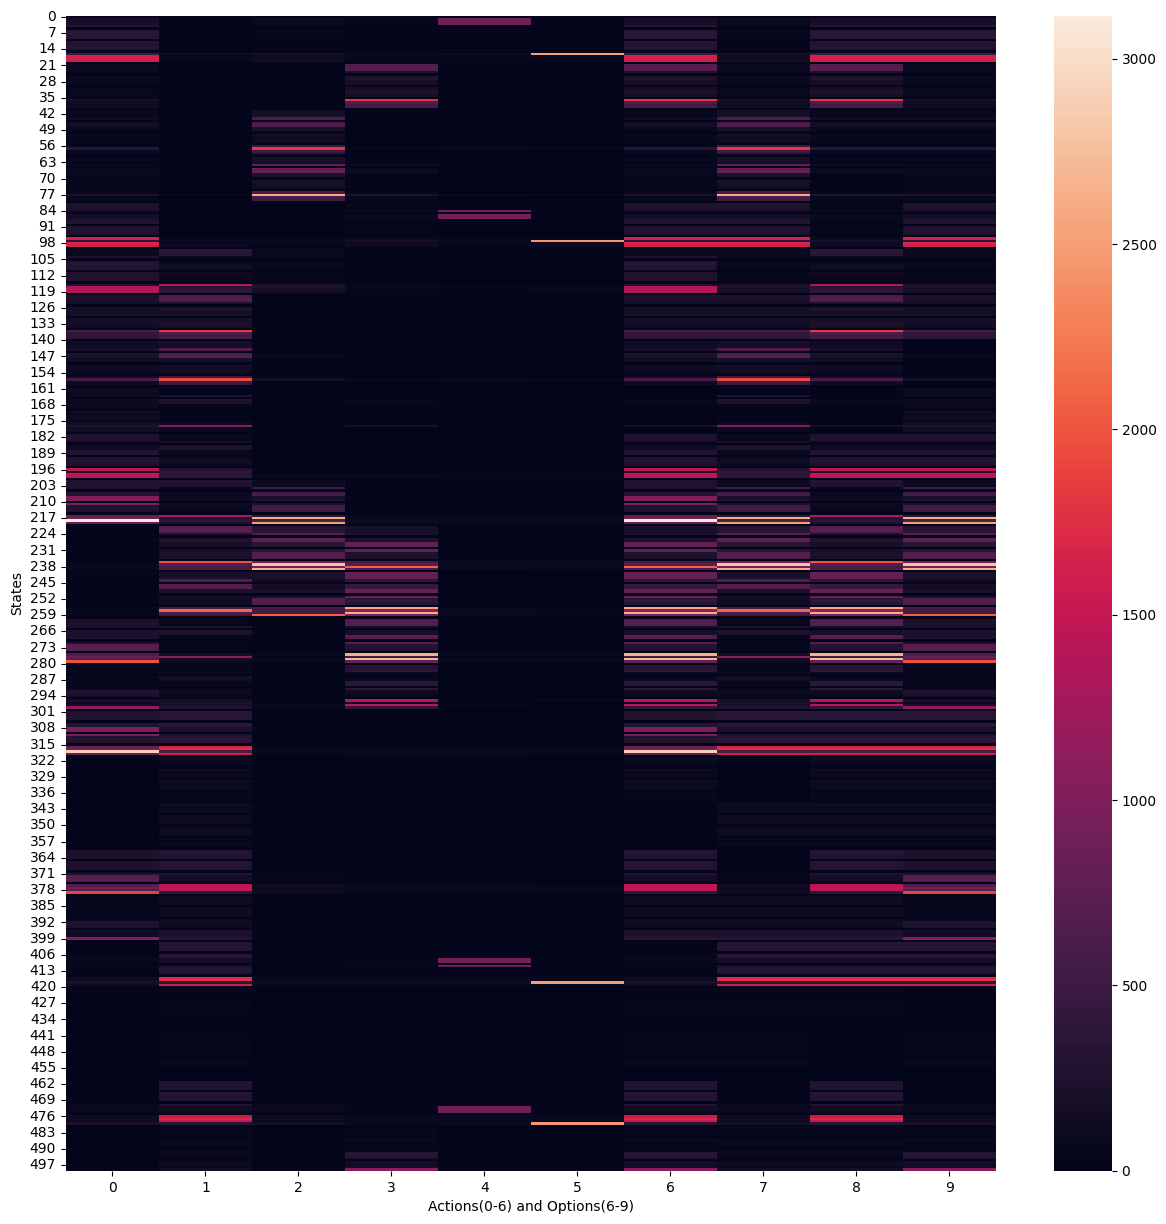

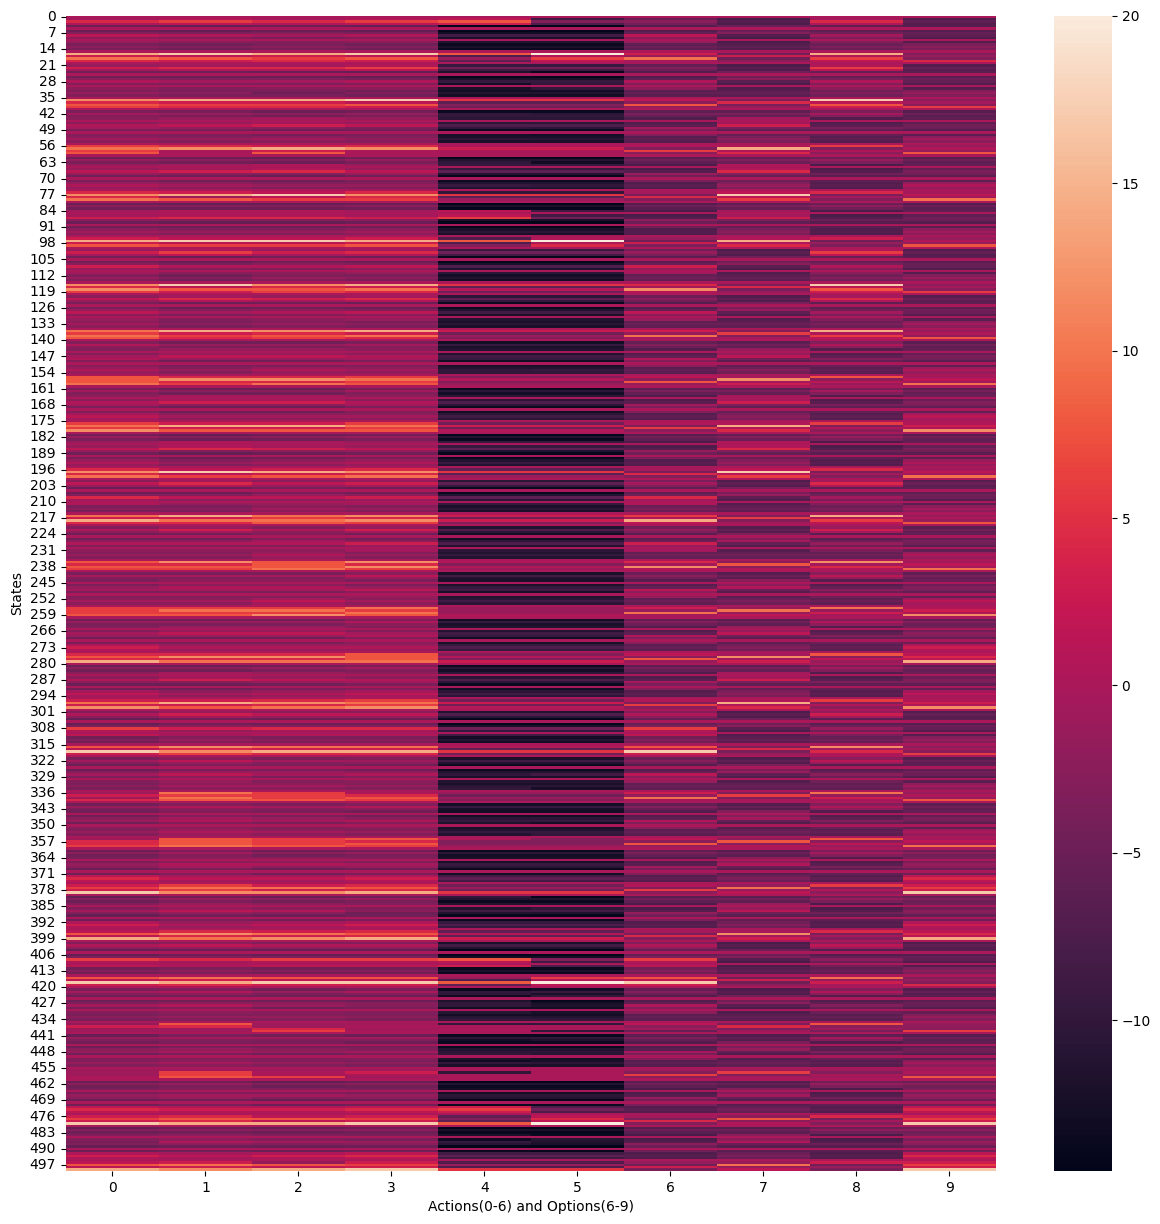

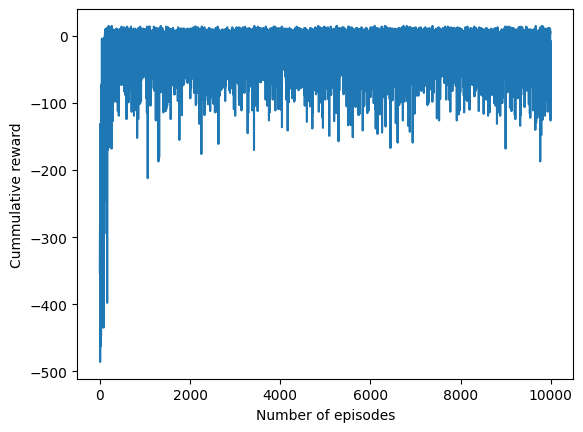

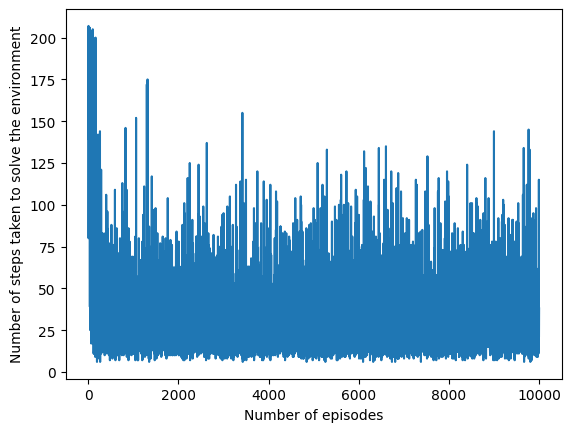

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8yh4d5bw with config:
wandb: 	EPS: 0.1946151933933401
wandb: 	LR: 0.5
wandb: 	NUM_EPISODES: 50000


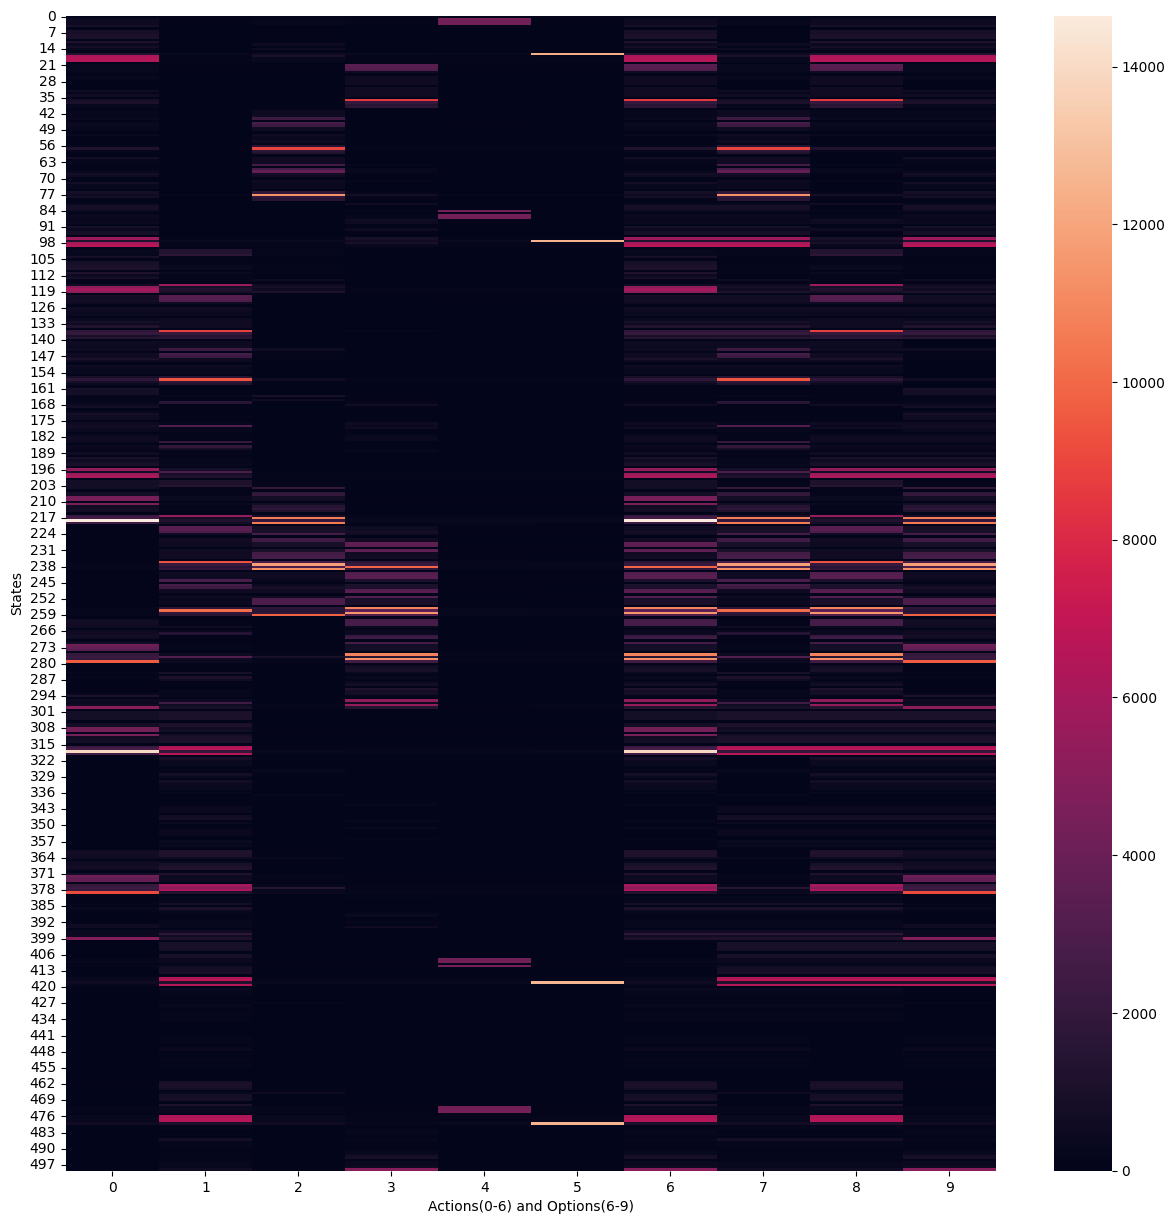

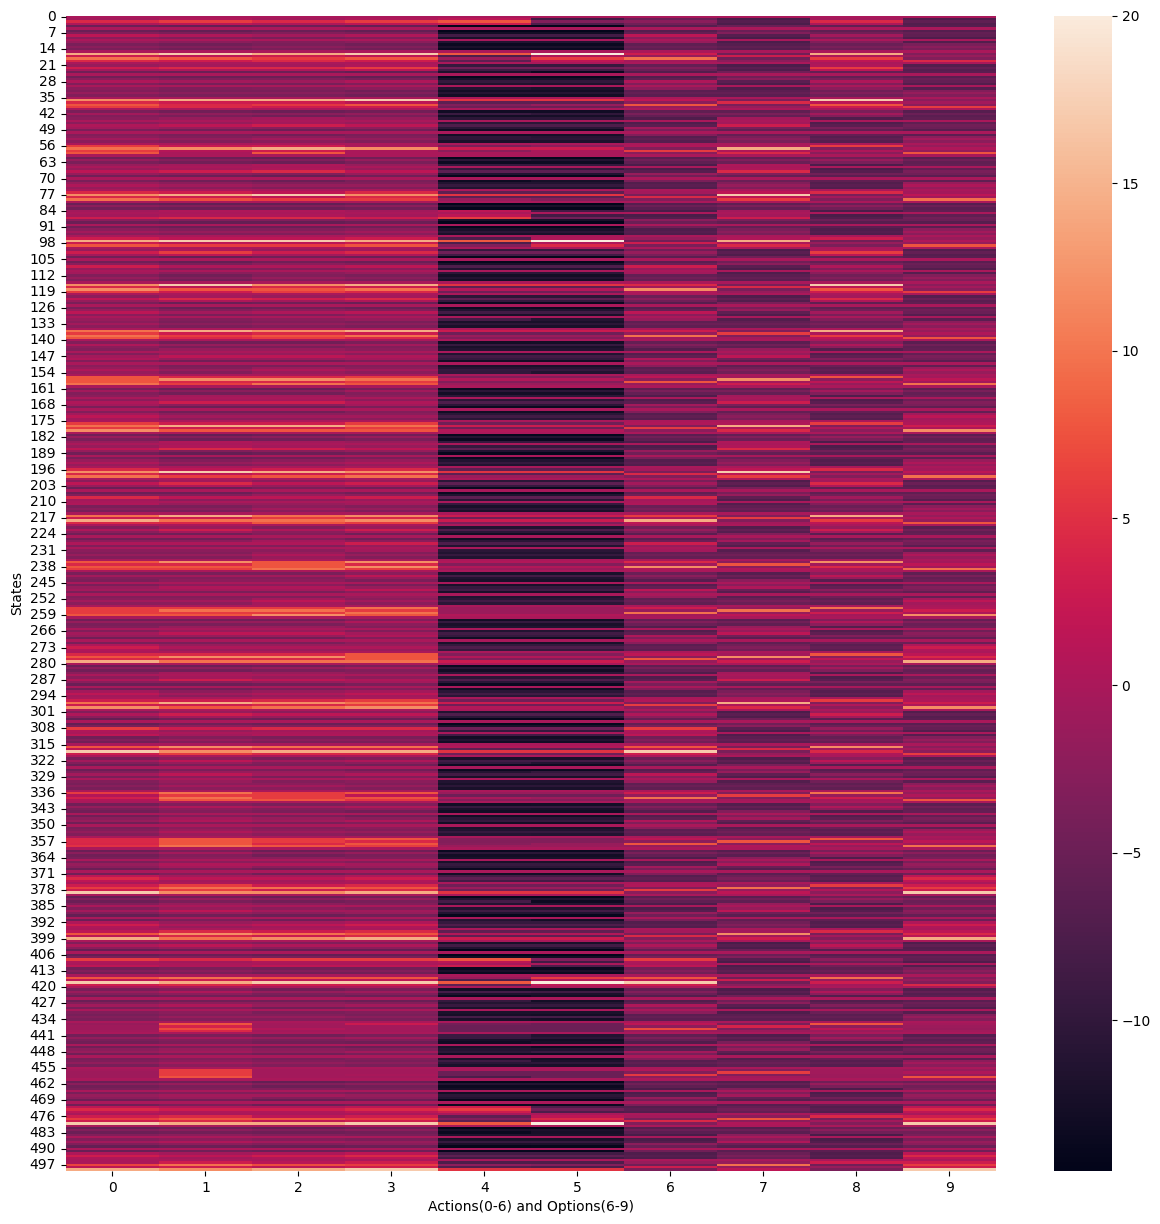

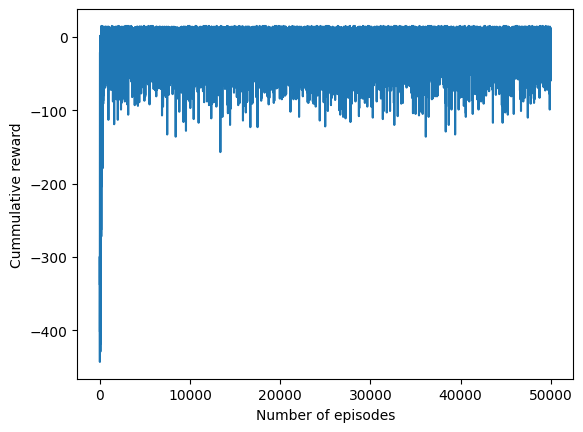

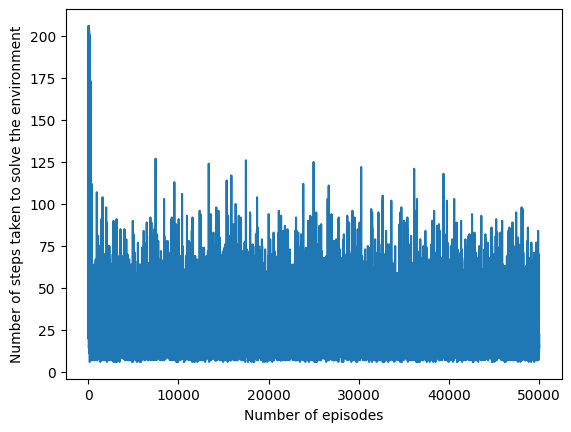

wandb: Agent Starting Run: 9hhgdkxm with config:
wandb: 	EPS: 0.23157230132783635
wandb: 	LR: 0.1
wandb: 	NUM_EPISODES: 50000


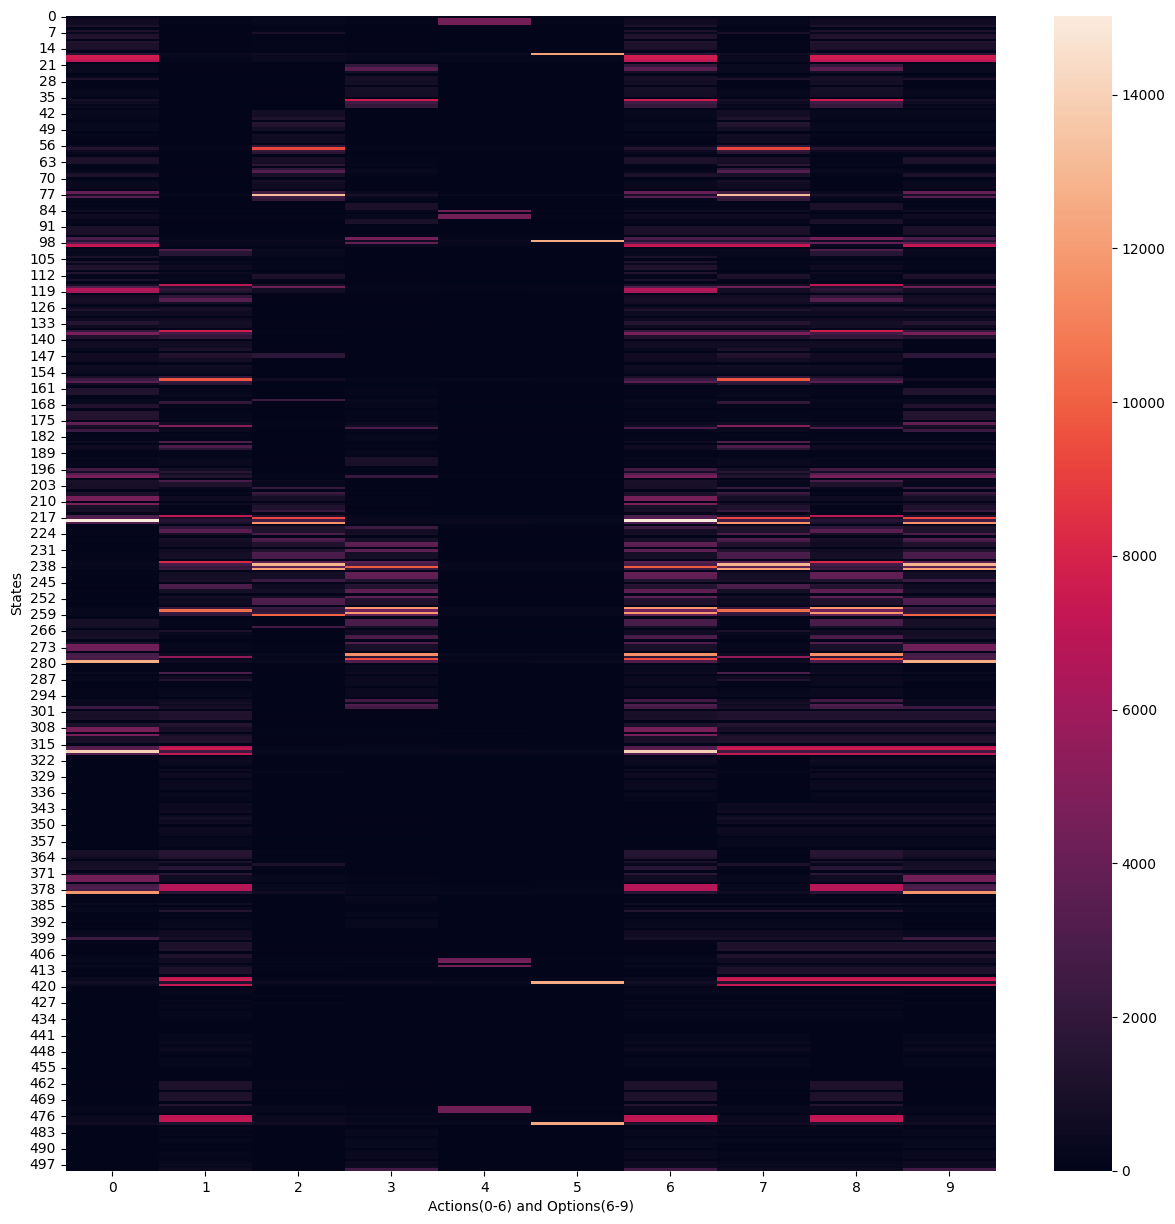

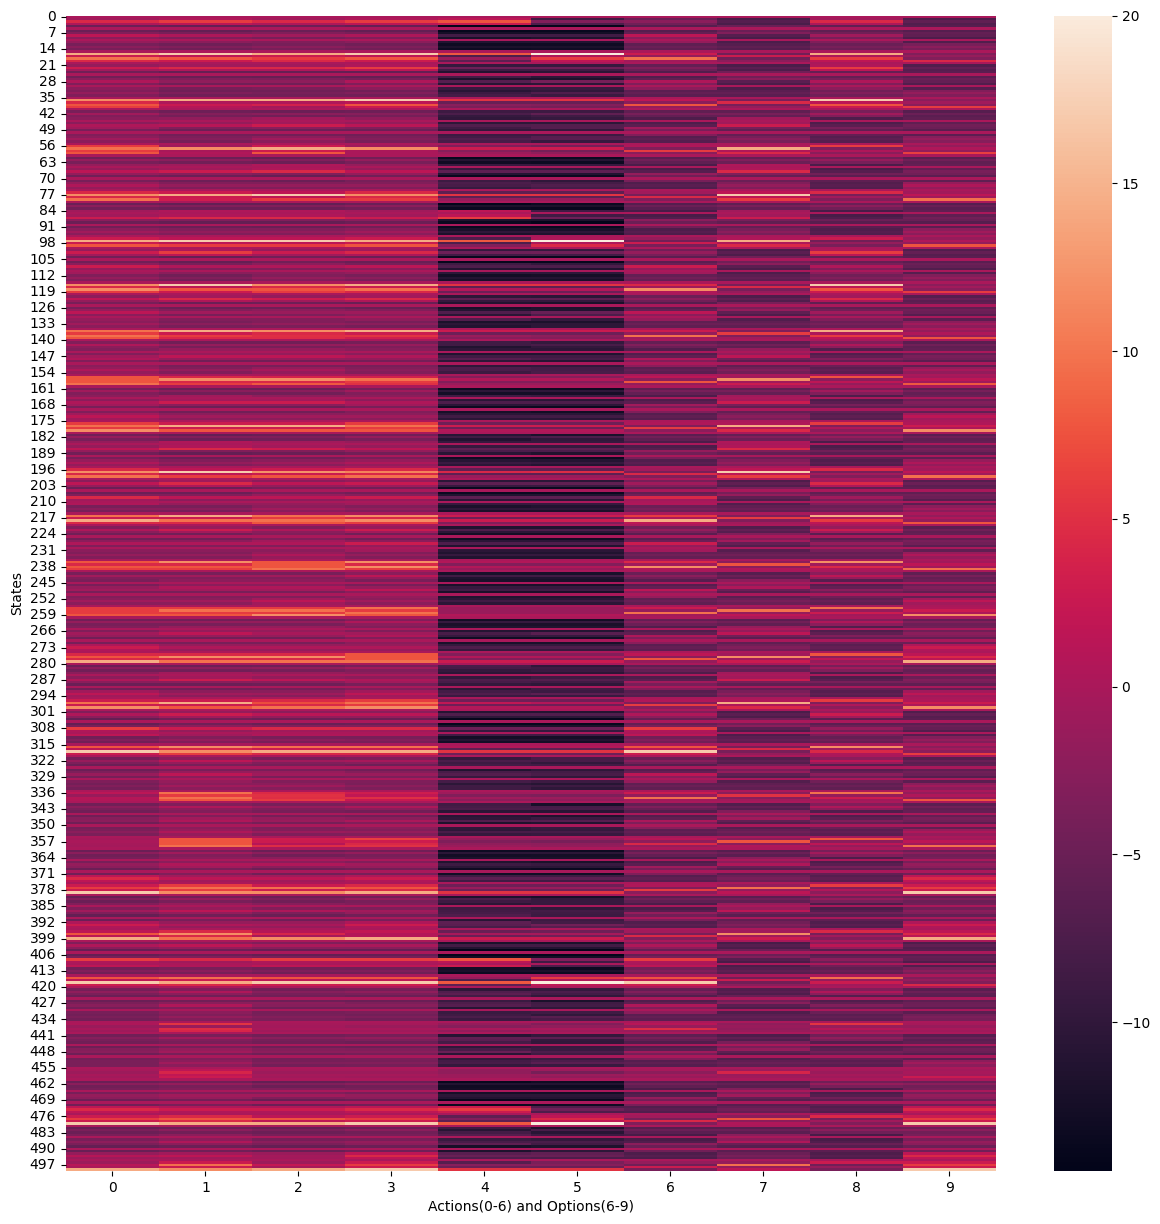

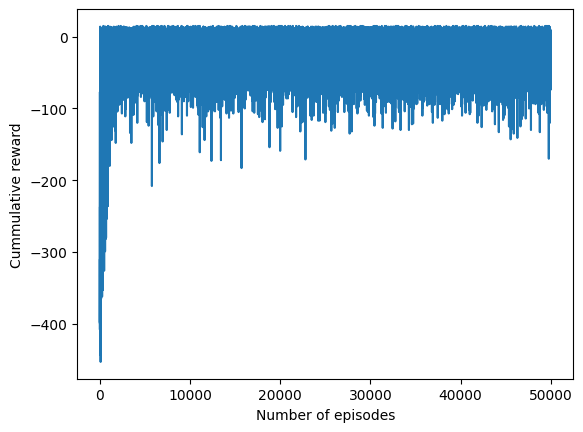

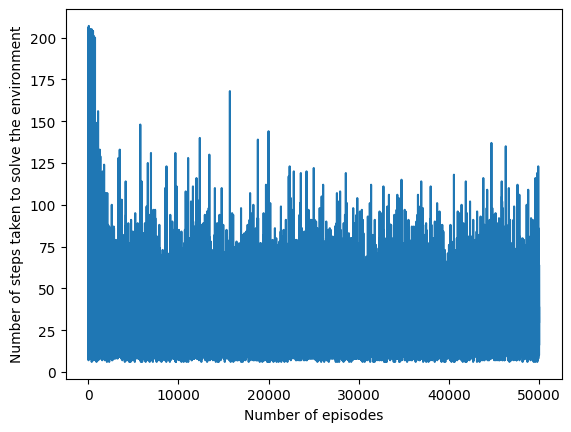

wandb: Agent Starting Run: lse8jd5b with config:
wandb: 	EPS: 0.0906673473860022
wandb: 	LR: 0.01
wandb: 	NUM_EPISODES: 100000


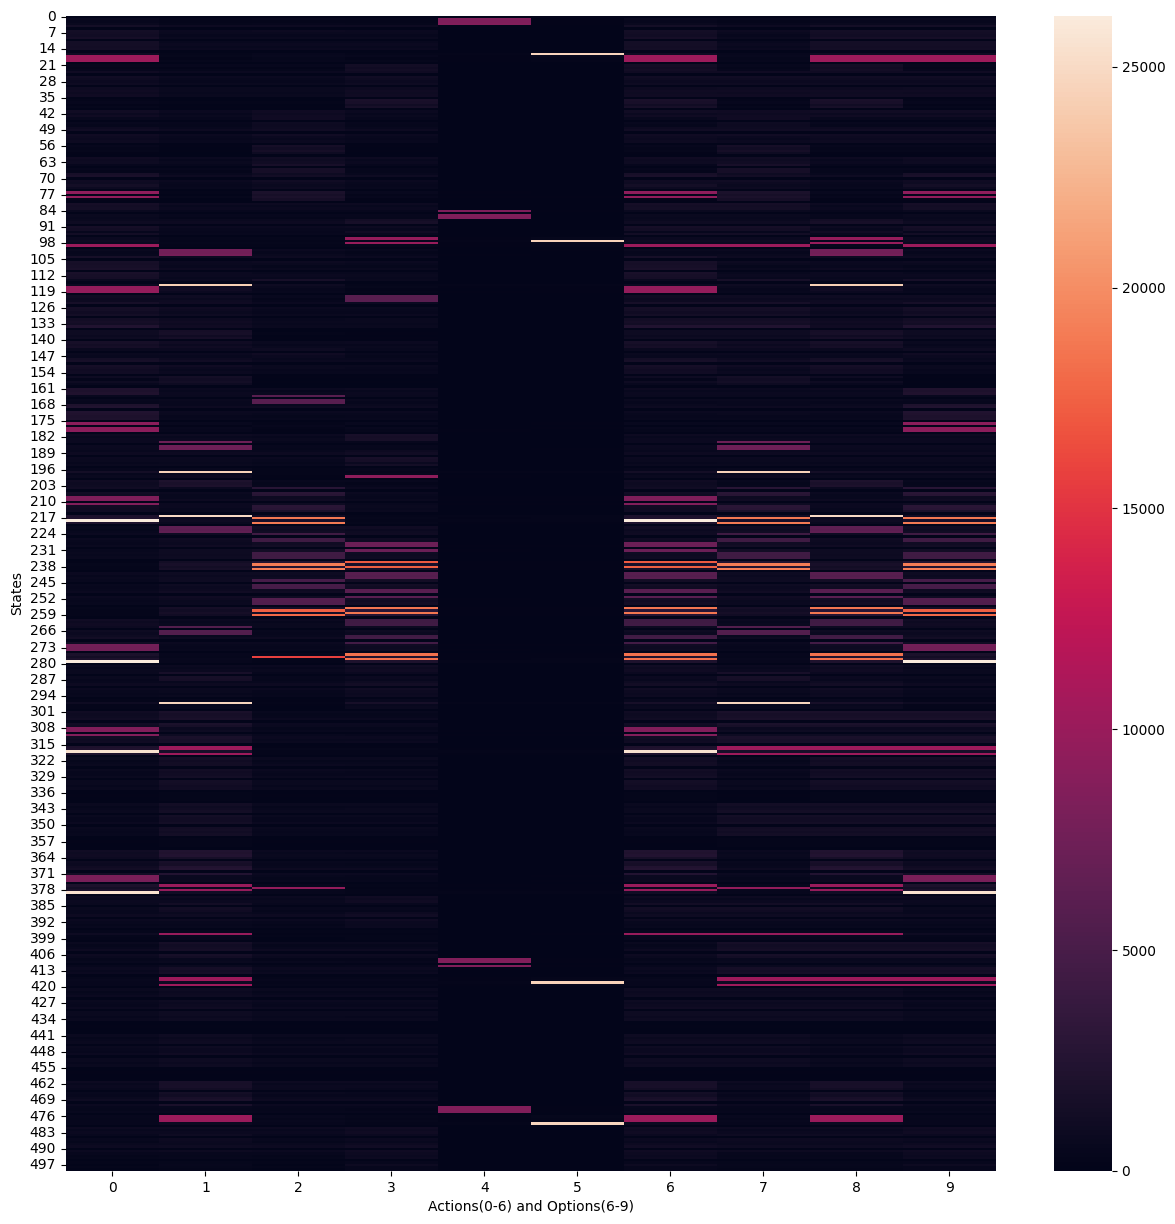

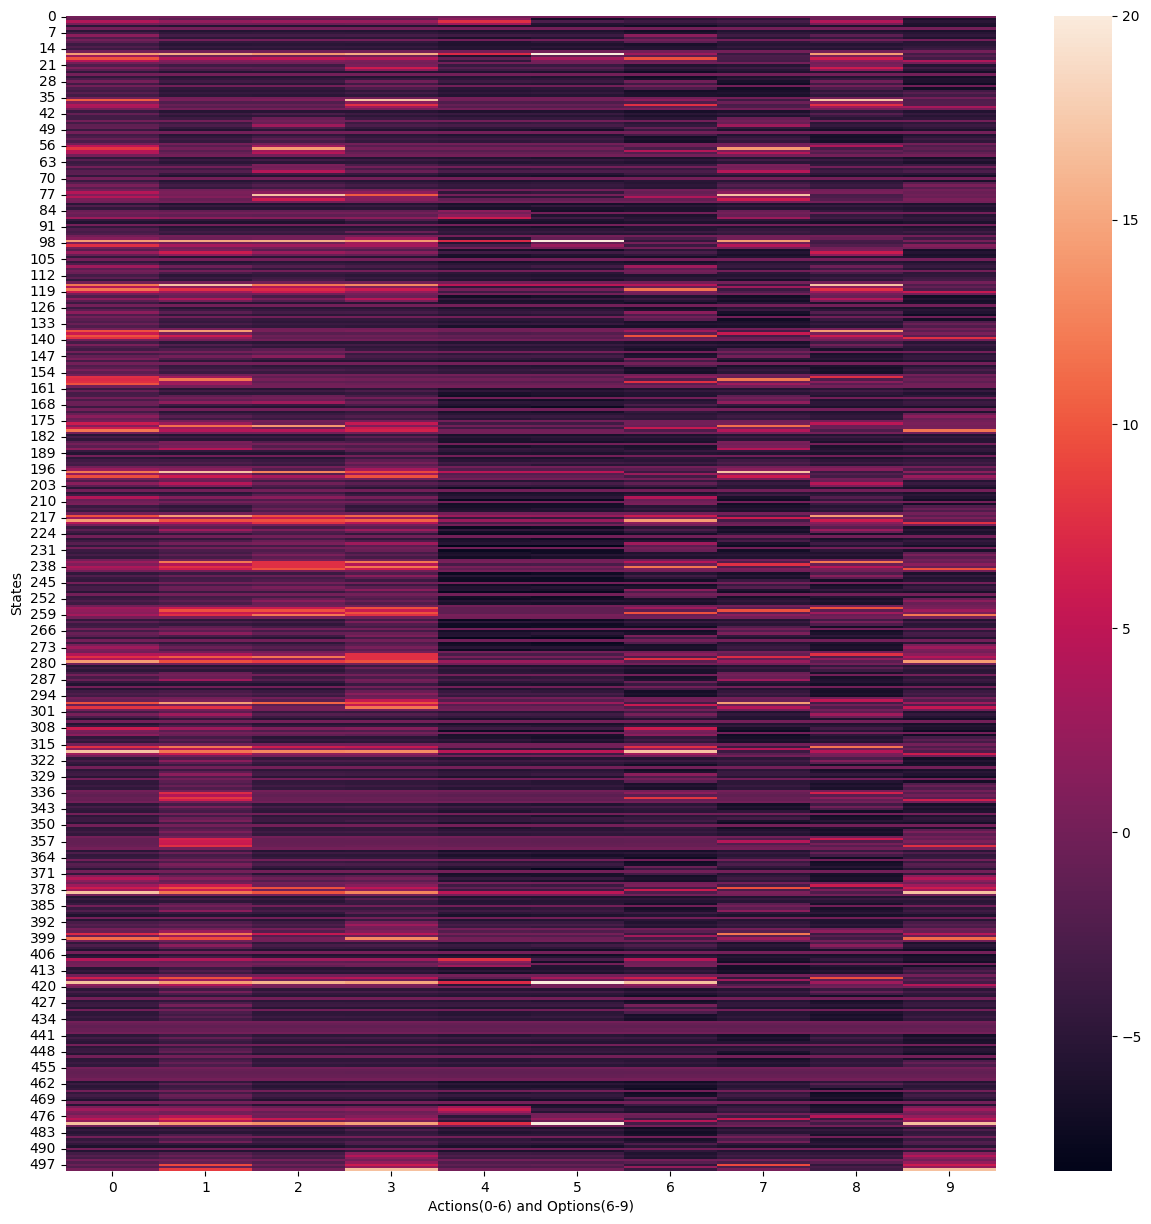

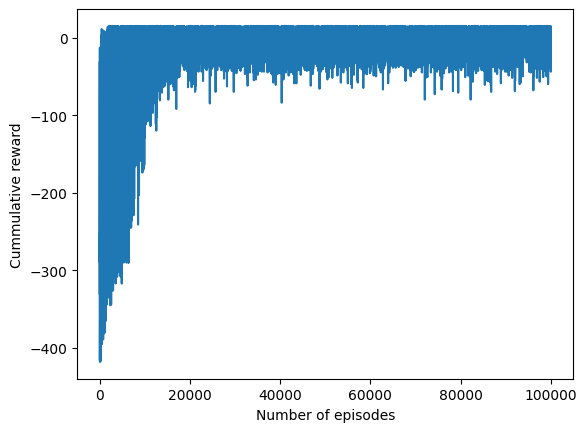

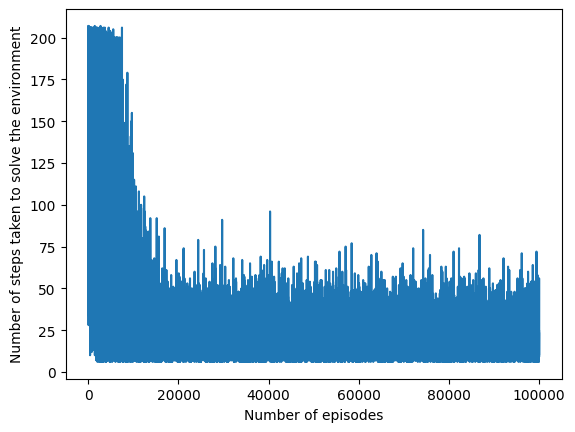

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ljuv8eeu with config:
wandb: 	EPS: 0.259360015128233
wandb: 	LR: 1
wandb: 	NUM_EPISODES: 50000


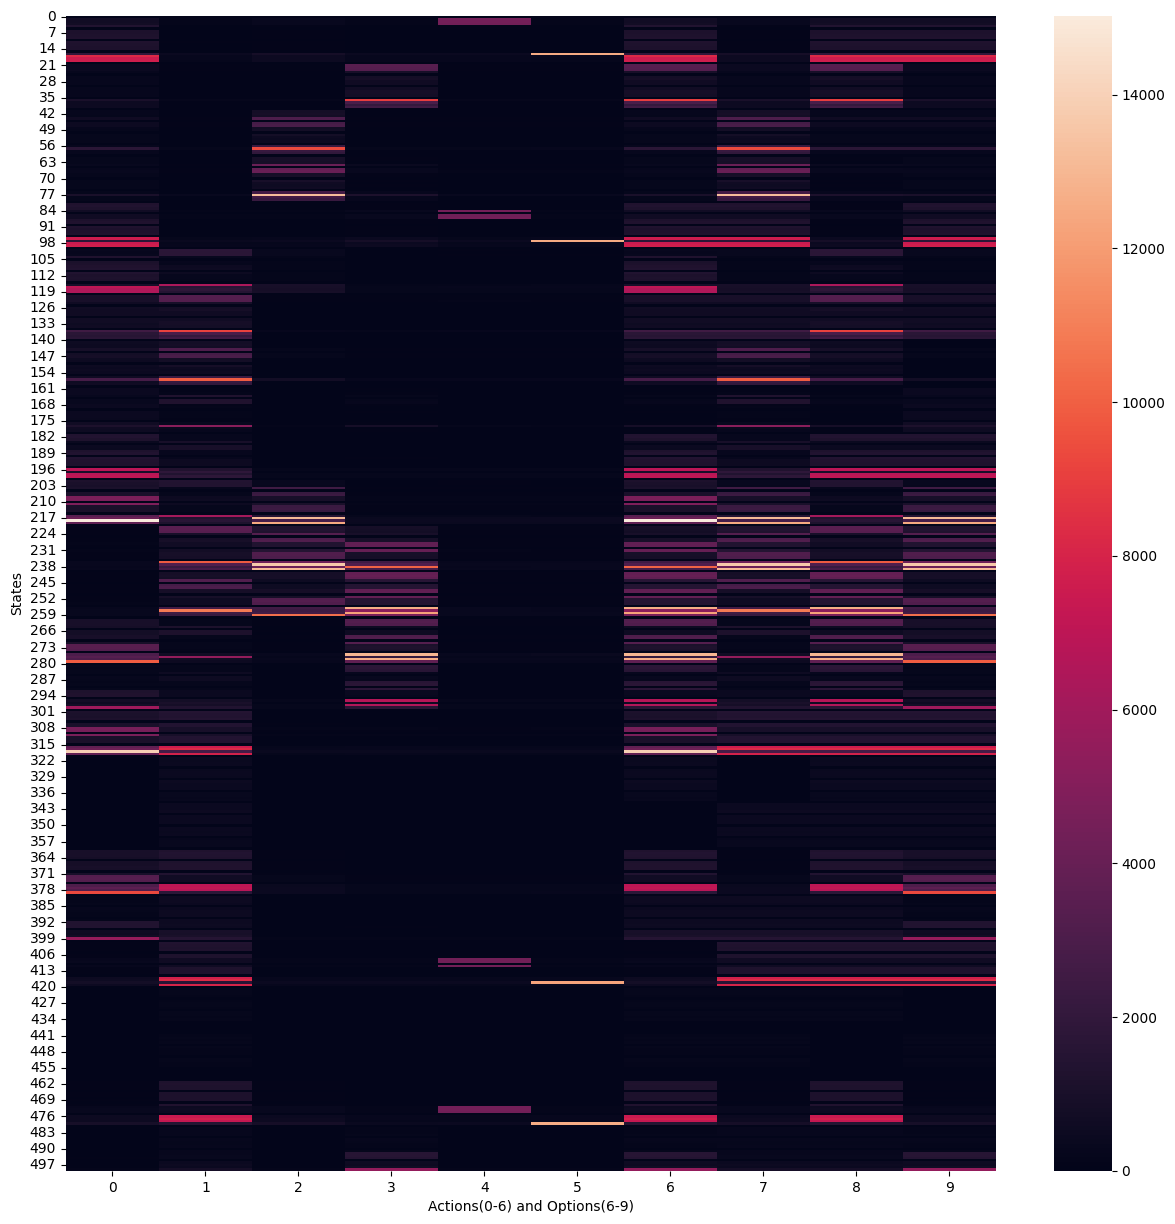

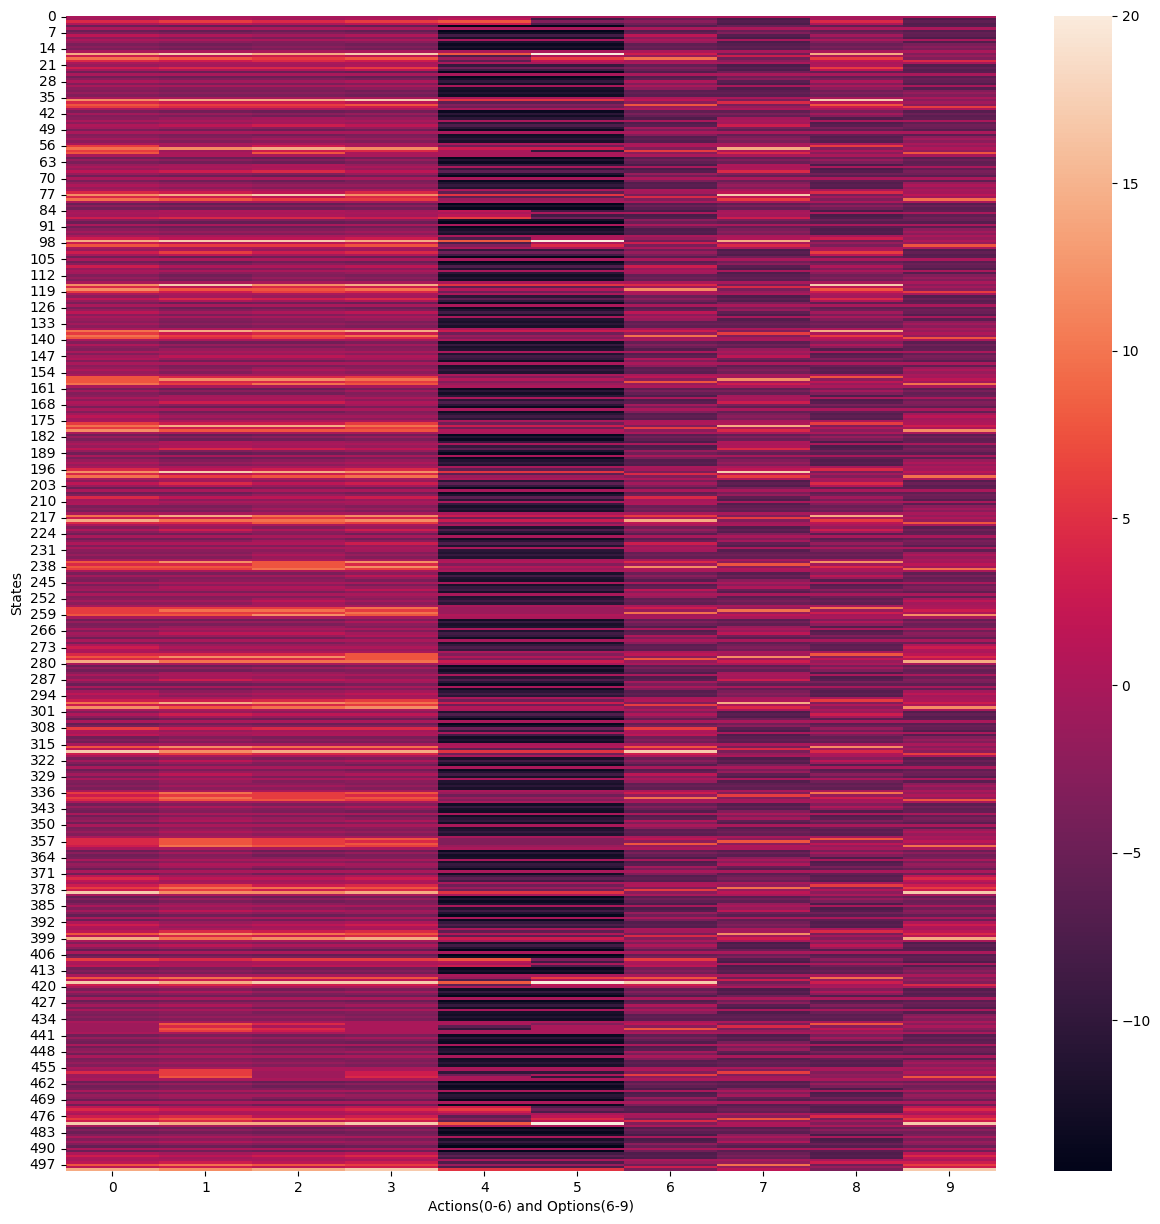

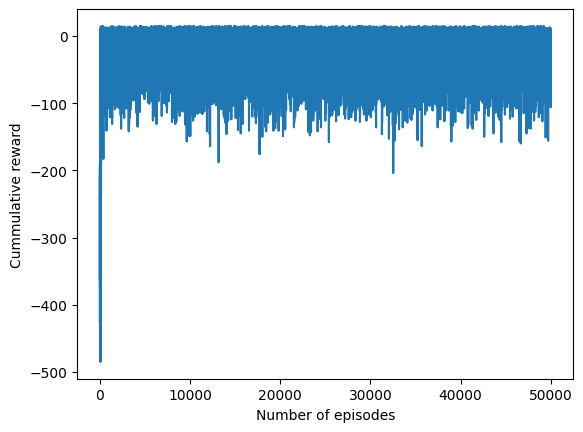

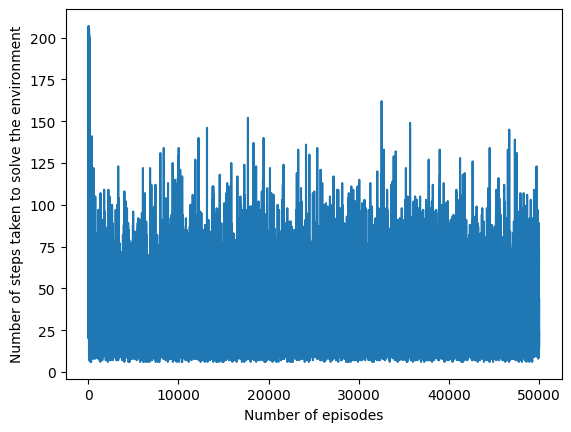

wandb: Agent Starting Run: k4kw916s with config:
wandb: 	EPS: 0.05110087864223421
wandb: 	LR: 0.3
wandb: 	NUM_EPISODES: 10000


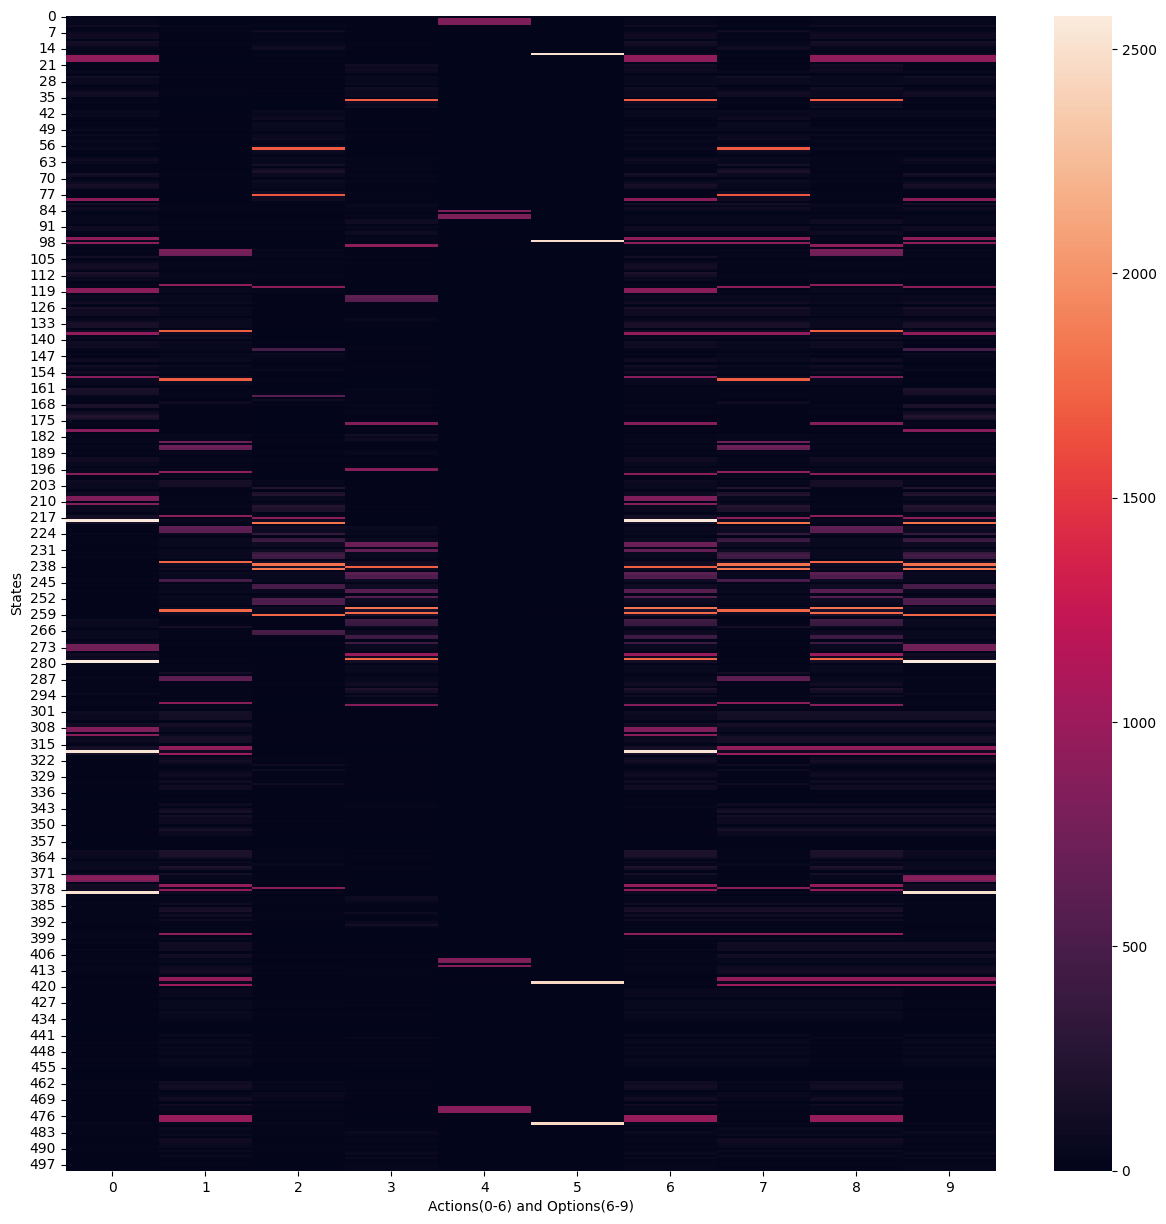

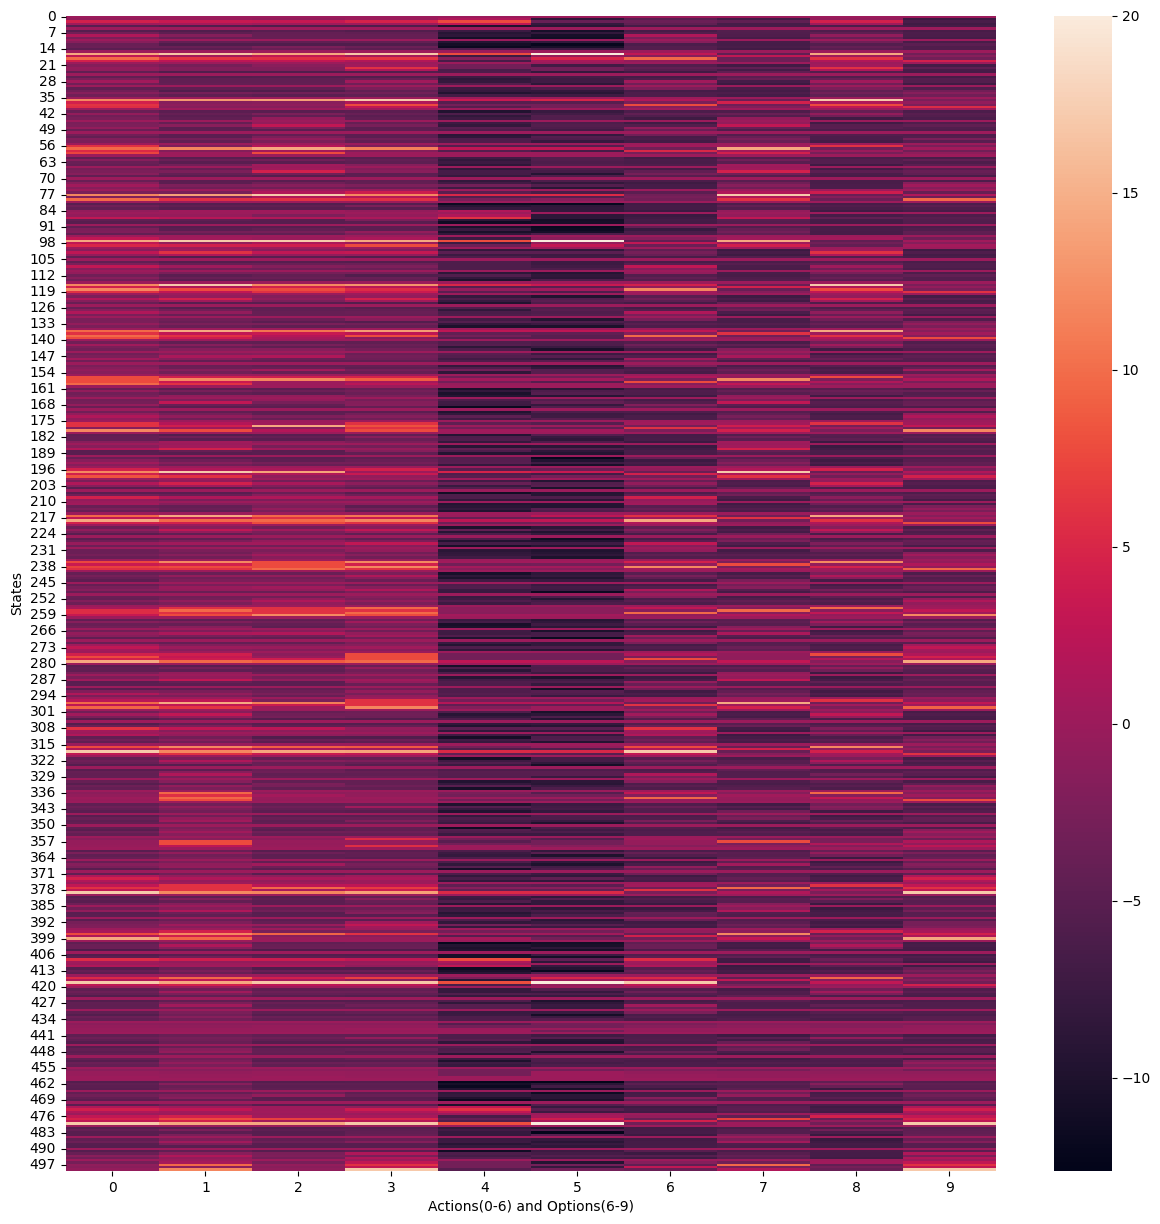

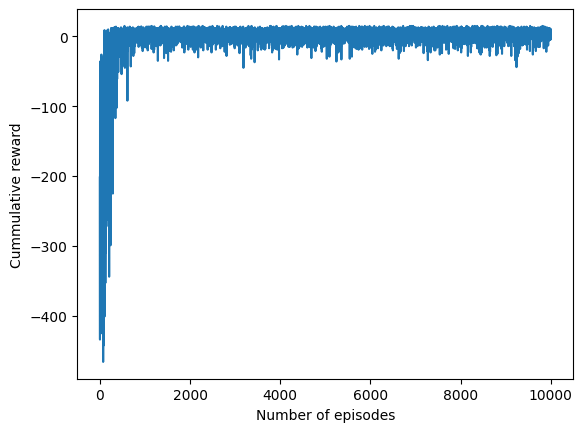

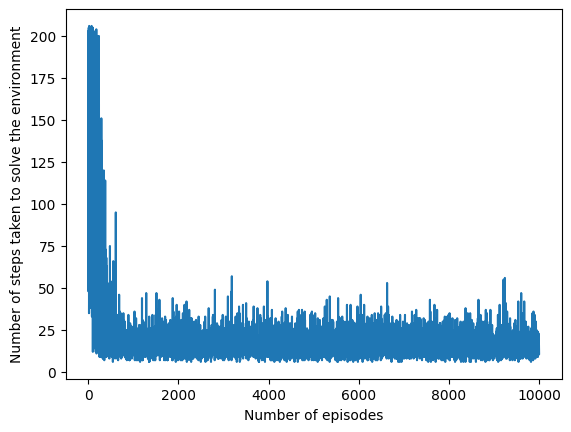

wandb: Agent Starting Run: q6b5whxw with config:
wandb: 	EPS: 0.2511775303518276
wandb: 	LR: 0.3
wandb: 	NUM_EPISODES: 50000


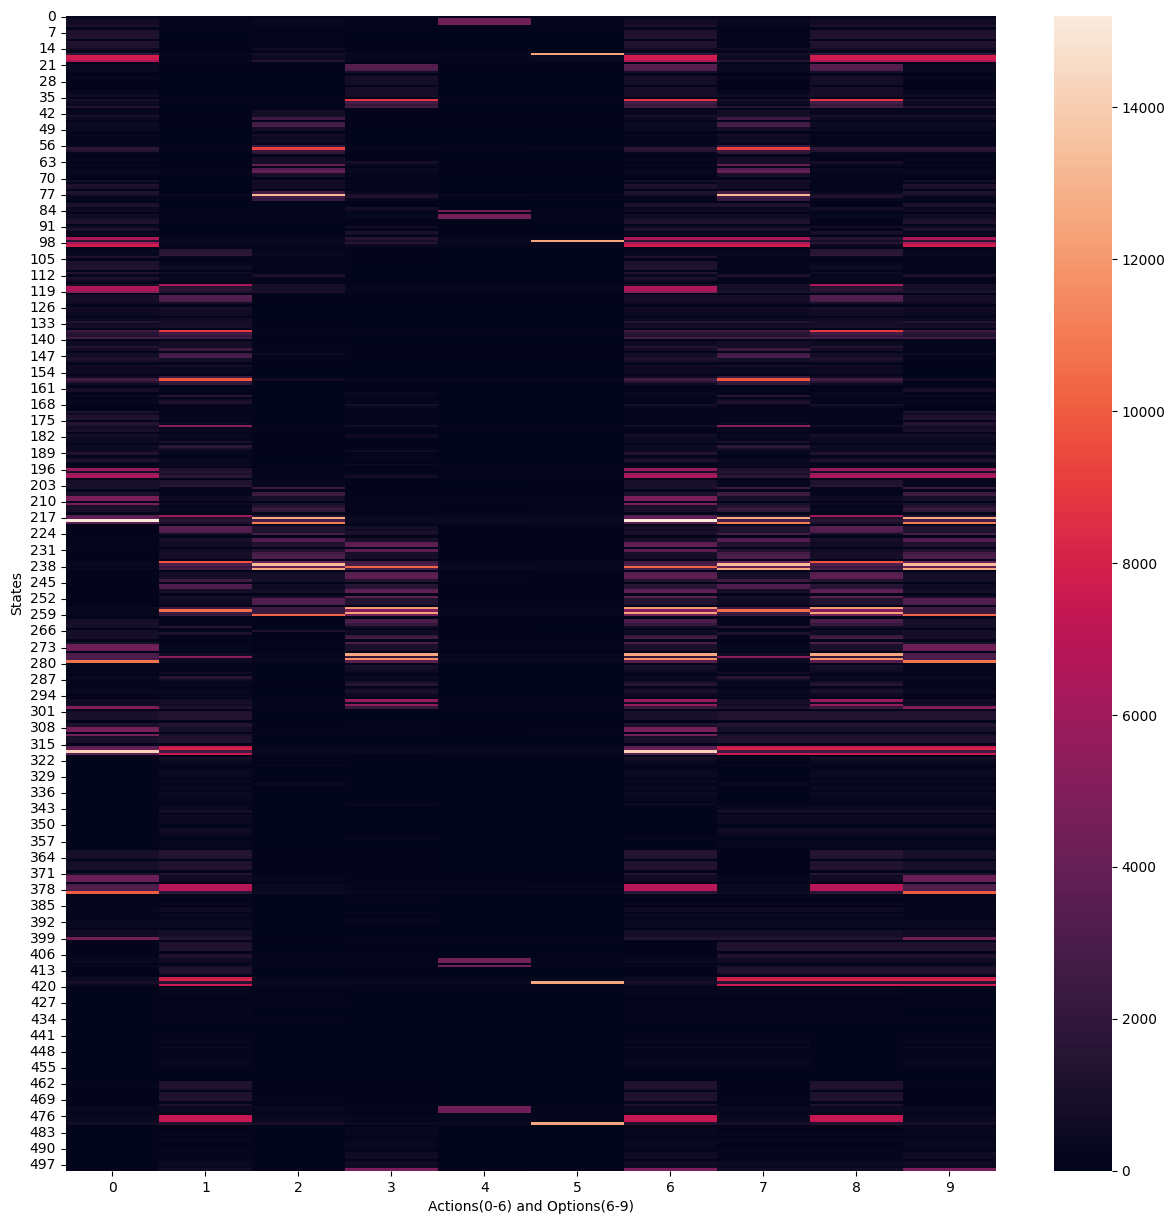

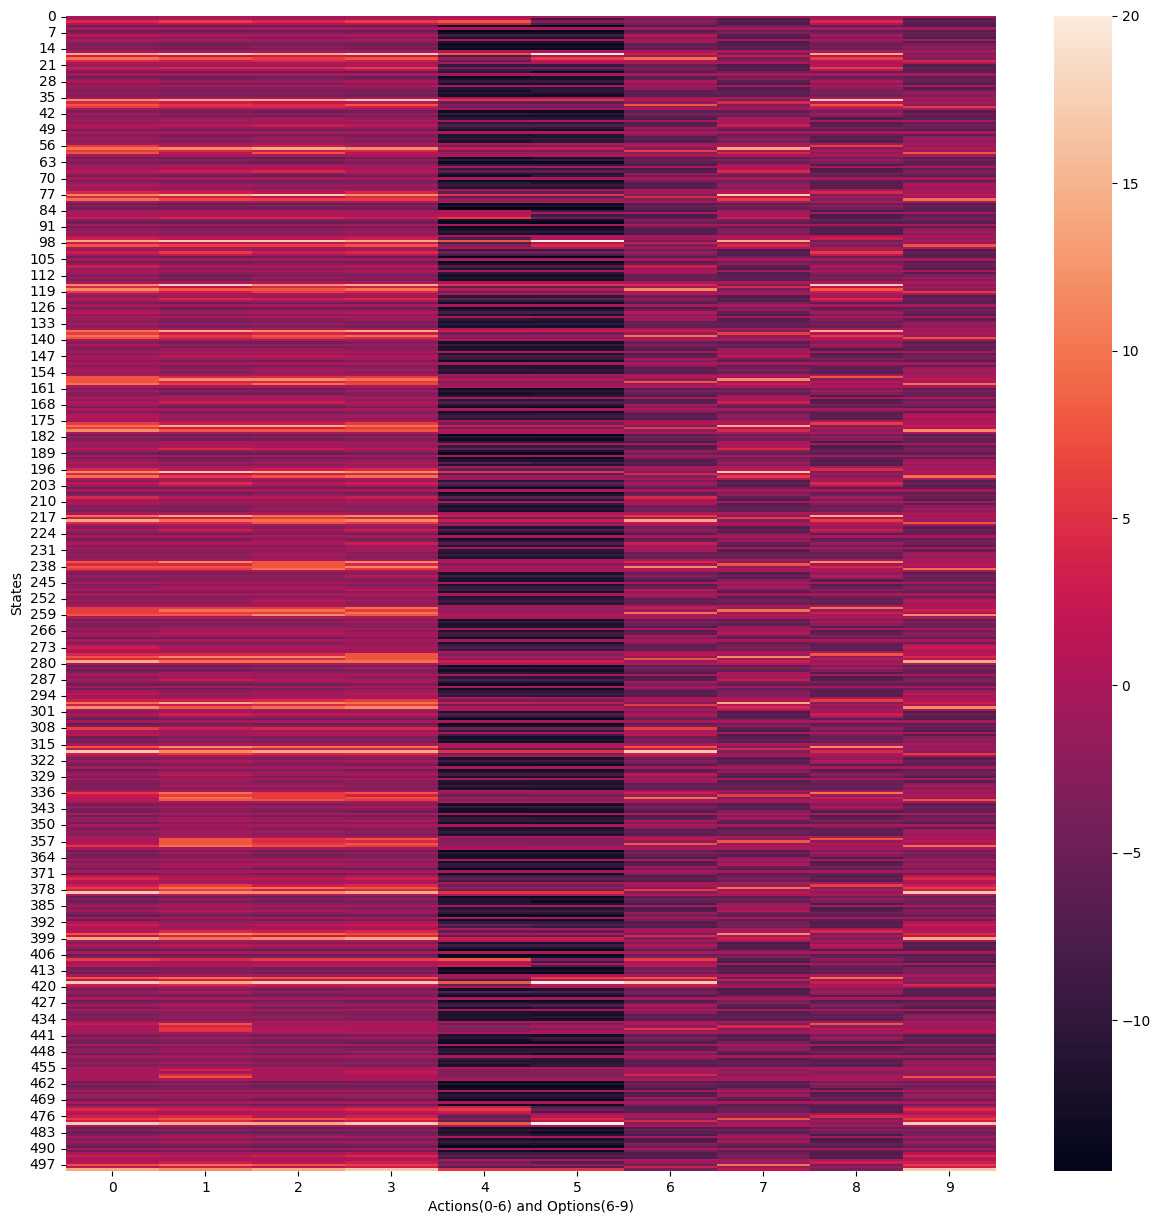

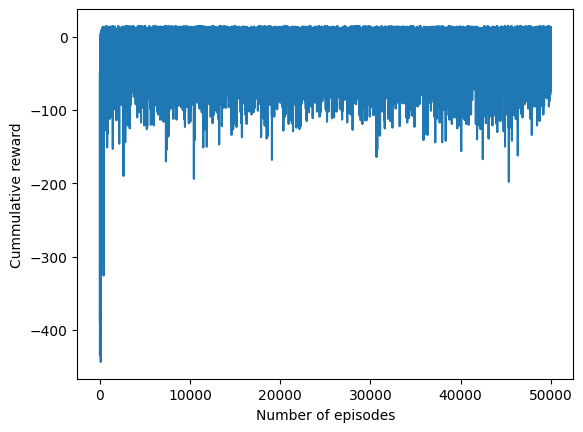

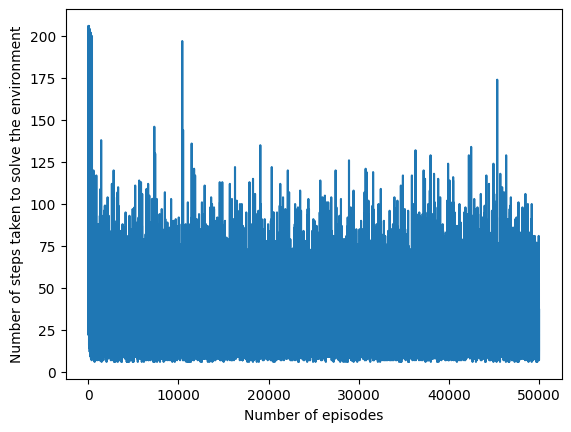

In [ ]:
wandb.agent(sweep_id, train_intra_option_Q, count=20)

In [ ]:
def Q_intra_option_Q_learning_(ALPHA,GAMMA,EPS,NUM_EPS):
  actions = [0,1,2,3,4,5,6,7,8,9] #6-9 options in the order -> y,g,r,b
  termination_dict = {6:20,7:4,8:0,9:23}
  options             = [None,None,None,None,None,None,policy_y,policy_g,policy_r,policy_b]
  Q_intra_option_Q = np.zeros((env.observation_space.n,len(actions))) 
  Update_Frequency_intra_q_learning = np.zeros((env.observation_space.n,len(actions)))
  alpha = ALPHA
  gamma = GAMMA
  cumul_reward_intra = []
  ep_steps = []
  def return_action(state,epsilon,Q):
    if np.random.rand()>epsilon:
      return np.argmax(Q[state])
    else:
      return np.random.choice(np.arange((len(actions))),1)[0]
  def average_episode_time(Q):
    steps = []
    trajectories_ep = []
    for i in range(1000):
      state = env.reset()
      done = False
      t = 0
      trajectory = []
      while not done:
        action = np.argmax(Q[state])
        if action<6:
          next_state,reward,done,_ = env.step(action)
          trajectory.append([state,action,next_state,reward,False])
          state = next_state
          t+=1
        if action>=6:
          optdone = False
          while not optdone:

            row_t,col_t,_,_ = env.decode(state)
            optaction = options[action][row_t][col_t] 
            next_state,reward,done,_ = env.step(optaction)
            trajectory.append([state,optaction,next_state,reward,True])
            t+=1
            state= next_state
            row_t_1,col_t_1,_,_ = env.decode(next_state)
            next_state_is_terminal = True if (5*(row_t_1) + col_t_1) == termination_dict[action] else False 
            if next_state_is_terminal:
              optdone = True
            state = next_state
      steps.append(t)
      trajectories_ep.append(trajectory)


    #print("Average number of steps taken for given hyperparameters is: ",np.array(steps).mean())
    return(np.array(steps).mean()),steps,trajectories_ep
  def update_intraoption_action(state,action,next_state,reward): #here action is a primitive action
    Q_intra_option_Q[state][action] += alpha*(reward + gamma*max(Q_intra_option_Q[next_state]) - Q_intra_option_Q[state][action])
    Update_Frequency_intra_q_learning[state][action] +=1 
    row_t,col_t,_,_ = env.decode(state)
    row_t_1,col_t_1,_,_ = env.decode(next_state)
    
    for option in range(6,10):
      optaction  = options[option][row_t][col_t]
      next_state_is_terminal = True if (5*(row_t_1) + col_t_1) == termination_dict[option] else False 
      if optaction == action:
        if next_state_is_terminal == False:
          Q_intra_option_Q[state][option] += alpha*(reward + (gamma*Q_intra_option_Q[next_state][option]) - Q_intra_option_Q[state][option])
          Update_Frequency_intra_q_learning[state][option] += 1  
        else:
          Q_intra_option_Q[state][option] += alpha*(reward + gamma*max(Q_intra_option_Q[next_state]) - Q_intra_option_Q[state][option])
          Update_Frequency_intra_q_learning[state][option] += 1  

  for ep in range(int(NUM_EPS)):
    state = env.reset()
    done = False
    t = 0
    r = 0
    while not done:
      eps = max((0.99**ep)*0.9,EPS)
      action = return_action(state,eps,Q_intra_option_Q)
      if action <6:
        next_state,reward,done,_ = env.step(action)
        r+=  reward
        t+=1
        update_intraoption_action(state,action,next_state,reward)
        state = next_state
        #print(state,action,next_state,reward)
      if action>=6:
        #print("current_option: ",action)
        optdone = False
        while not optdone:

          row_t,col_t,_,_ = env.decode(state)
          optaction = options[action][row_t][col_t] 
          next_state,reward,done,_ = env.step(optaction) 
          r+= reward
          t+=1
          update_intraoption_action(state,optaction,next_state,reward)
          state= next_state
          row_t_1,col_t_1,_,_ = env.decode(next_state)
          next_state_is_terminal = True if (5*(row_t_1) + col_t_1) == termination_dict[action] else False 
          #print(state,optaction,next_state,reward,termination_dict[action])
          if next_state_is_terminal:
            optdone = True
    cumul_reward_intra.append(r)
    ep_steps.append(t)

  plt.figure(figsize = (15,15))
  sns.heatmap(Update_Frequency_intra_q_learning,annot = False)
  plt.xlabel("Actions(0-6) and Options(6-9)")
  plt.ylabel("States")
  plt.savefig(str("Update_frequency_intra ")+str(alpha)+str(EPS)+str(GAMMA)+".png")
  plt.show()
  plt.figure(figsize = (15,15))
  sns.heatmap(Q_intra_option_Q,annot = False)
  plt.xlabel("Actions(0-6) and Options(6-9)")
  plt.ylabel("States")
  plt.savefig(str("Intra_option ")+str(alpha)+str(EPS)+str(GAMMA)+".png")
  plt.show()
  
  plt.plot(cumul_reward_intra)
  plt.xlabel("Number of episodes")
  plt.ylabel("Cummulative reward")
  plt.savefig(str("Reward_intra ")+str(alpha)+str(EPS)+str(GAMMA)+".png")
  plt.show()
  
  plt.plot(ep_steps)
  plt.xlabel("Number of episodes")
  plt.ylabel("Number of steps taken to solve the environment")
  plt.savefig(str("time_steps_intra ")+str(alpha)+str(EPS)+str(GAMMA)+".png")
  plt.show()

  mean_steps,_,_ =  average_episode_time(Q_intra_option_Q)
  return mean_steps,Q_intra_option_Q



/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


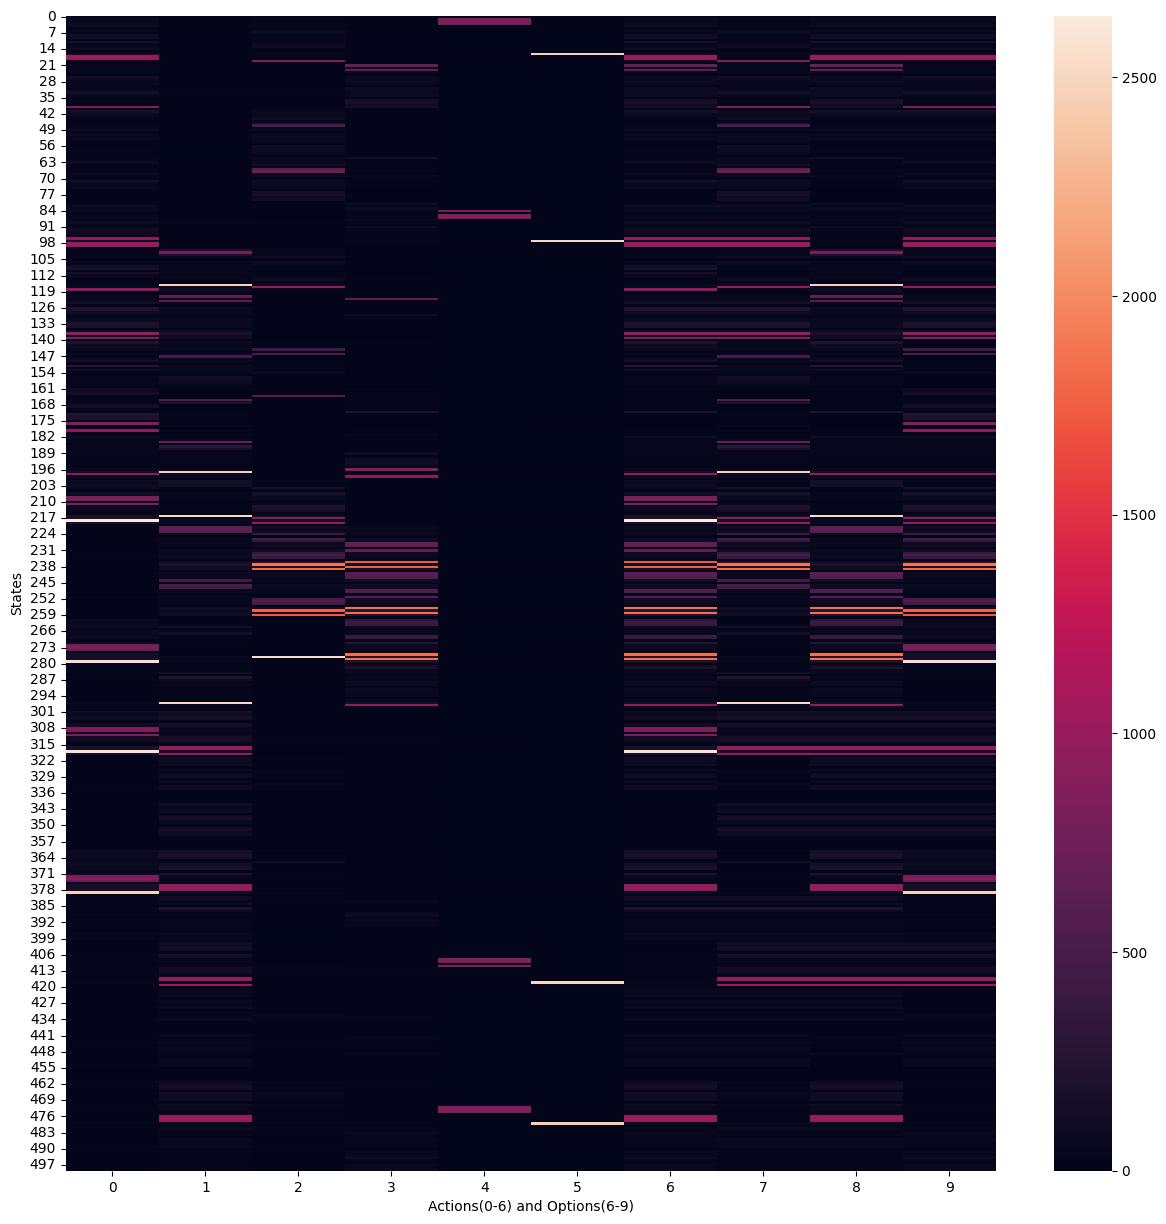

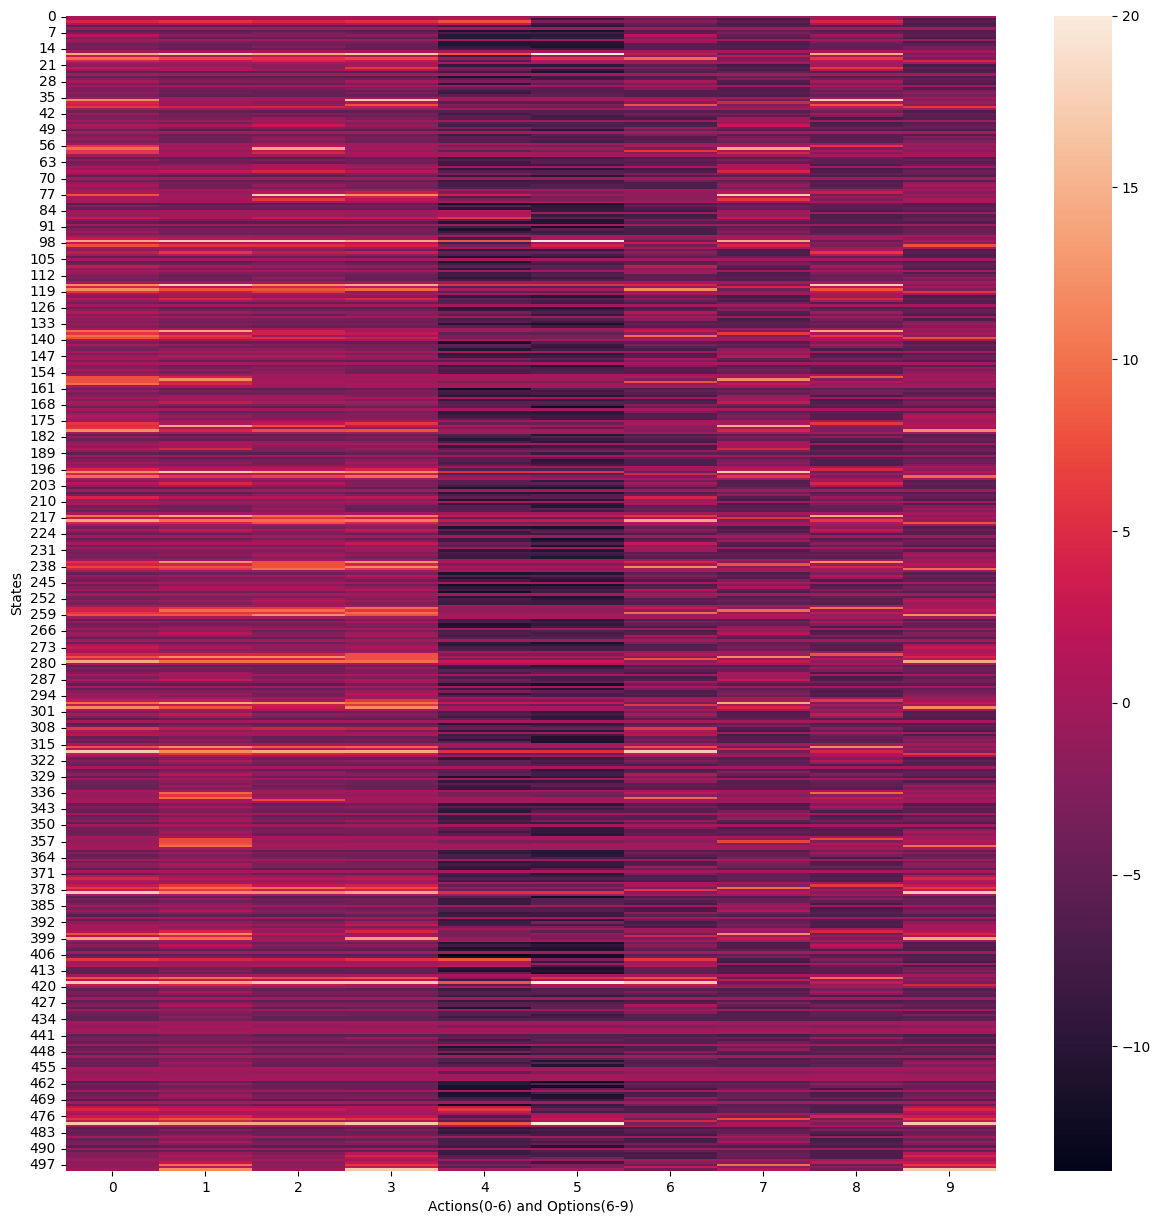

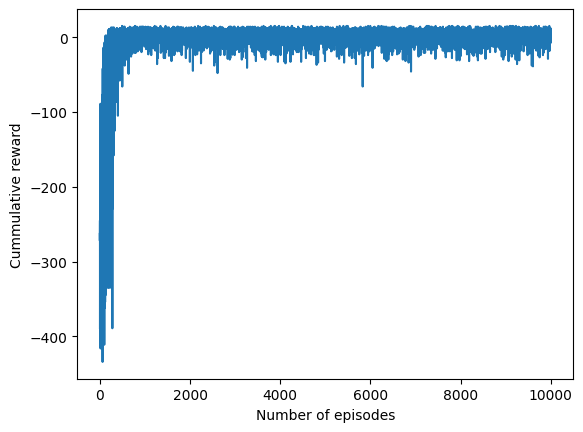

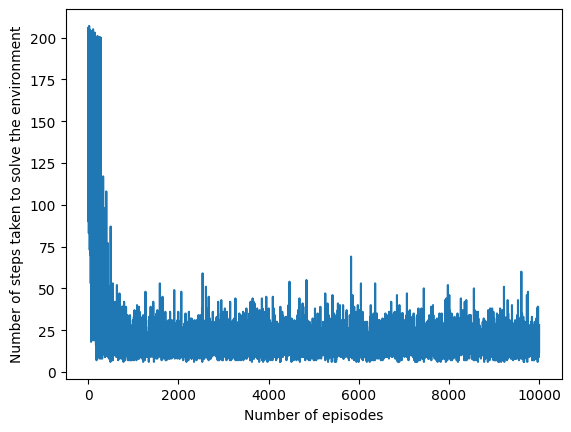

0    38
1    38
3    21
4     3
Name: 0, dtype: int64
1    43
0    32
2    22
4     3
Name: 1, dtype: int64
0    53
3    25
1    19
4     3
Name: 2, dtype: int64
0    51
2    19
1    16
3    11
4     3
Name: 3, dtype: int64
Destination
1    11
3     9
0     4
5     1
Name: 0, dtype: int64
1    14
2     7
0     3
5     1
Name: 1, dtype: int64
0    10
3     7
1     5
2     2
5     1
Name: 2, dtype: int64
0    11
2     7
3     3
1     3
5     1
Name: 3, dtype: int64


In [11]:
EPS = 0.07090224181026285
LR =  0.3 	
NUM_EPISODES =  10000

import pandas as pd

mean_steps,Q = Q_intra_option_Q_learning_(0.3,0.9,0.07090224181026285,10000)


arr = Q.argmax(-1)
actions = [0,1,2,3,4,5,6,7,8,9] #6-9 options in the order -> y,g,r,b
termination_dict = {6:20,7:4,8:0,9:23}
passenger_dest = {0:0, 1:4, 2:20, 3:23}

action_count_passenger = {0:[],1:[],2:[],3:[]}
action_count_destination = {0:[],1:[],2:[],3:[]}
notintaxi = []
intaxi = []
for i in range(len(arr)):
  action = arr[i]
  r,c,passenger_ind,destination = env.decode(i)
  if passenger_ind!=4:
    action_count_passenger[passenger_ind].append(action)
  if passenger_ind == 4:
    action_count_destination[destination].append(action)

  
    
df1 = pd.DataFrame(action_count_passenger)

for i in df1.columns:
  print(df1[i].value_counts())


print("Destination")


df2 = pd.DataFrame(action_count_destination)

for i in df2.columns:
  print(df2[i].value_counts())


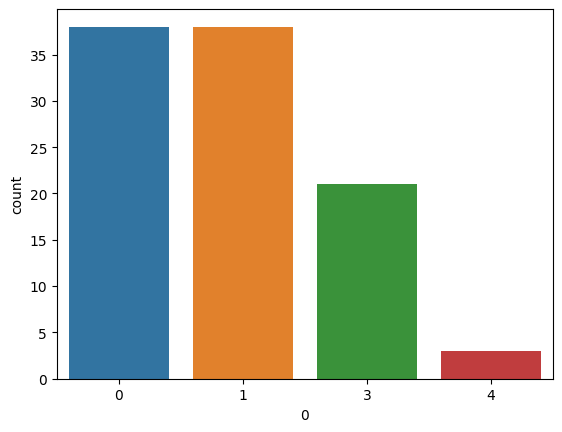

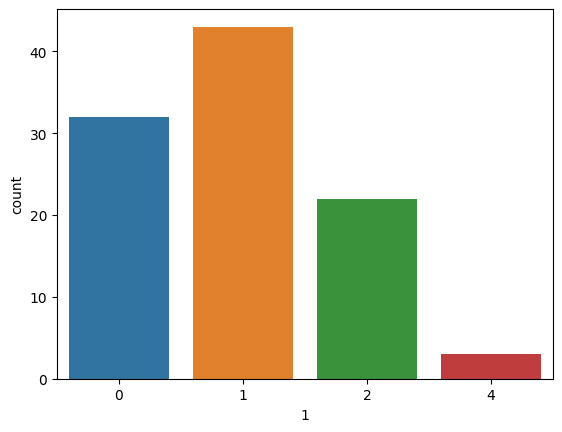

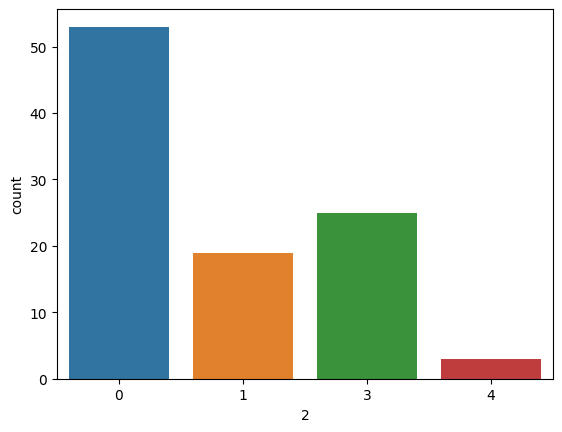

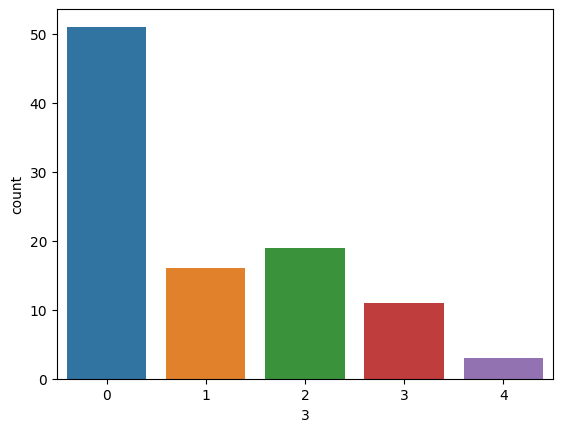

-------------DESTIN-----------------


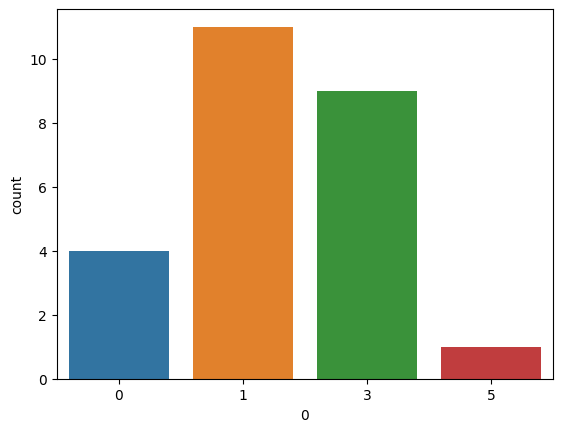

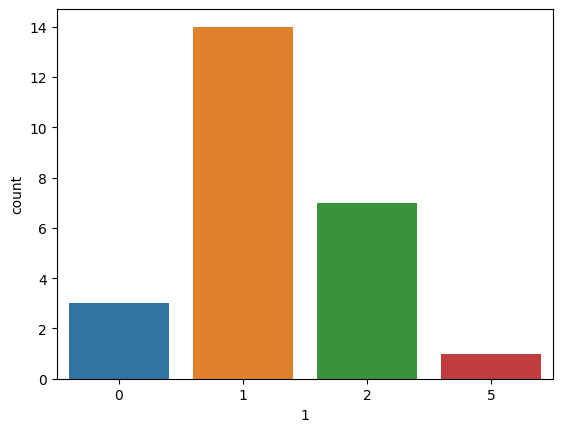

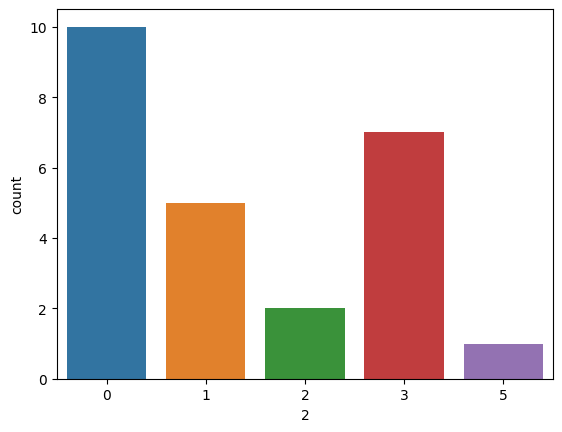

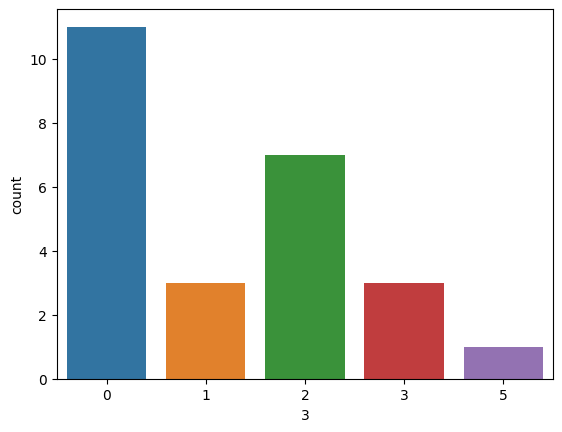

In [15]:
df1 = pd.DataFrame(action_count_passenger)

for i in df1.columns:
  sns.countplot(x = (df1[i]))
  plt.show()



print("-------------DESTIN-----------------")
df2 = pd.DataFrame(action_count_destination)

for i in df2.columns:
  sns.countplot(x = (df2[i]))
  plt.show()
